In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from dcr import *
data = pd.read_csv("dcr.csv")

In [3]:
data

id  time  orig_time  first_time  mat_time  res_time  balance_time  \
0          4    25         -2          25       119       NaN      61031.10   
1          4    26         -2          25       119       NaN      60882.42   
2          4    27         -2          25       119       NaN      60729.80   
3          4    28         -2          25       119       NaN      60576.14   
4          4    29         -2          25       119       NaN      60424.39   
...      ...   ...        ...         ...       ...       ...           ...   
62173  49972    52         25          52       145       NaN     180673.24   
62174  49972    53         25          52       145       NaN     179944.95   
62175  49972    54         25          52       145       NaN     179451.81   
62176  49972    55         25          52       145       NaN     178952.48   
62177  49972    56         25          52       145       NaN     178952.48   

         LTV_time  interest_rate_time  rate_time  ...  FICO_orig_time  \
0       33.911009              10.500       5.90  ...             587   
1       34.007232              10.500       5.90  ...             587   
2       34.335349              10.500       5.90  ...             587   
3       34.672545              10.875       5.90  ...             587   
4       34.951639              10.875       5.90  ...             587   
...           ...                 ...        ...  ...             ...   
62173  103.306966               7.500       5.15  ...             708   
62174   95.736862               7.500       5.15  ...             708   
62175   91.867079               7.500       5.15  ...             708   
62176   91.560581               7.500       5.15  ...             708   
62177   90.874242               7.500       5.15  ...             708   

       LTV_orig_time  Interest_Rate_orig_time  state_orig_time  hpi_orig_time  \
0               81.8                     10.5               KY          97.99   
1               81.8                     10.5               KY          97.99   
2               81.8                     10.5               KY          97.99   
3               81.8                     10.5               KY          97.99   
4               81.8                     10.5               KY          97.99   
...              ...                      ...              ...            ...   
62173           79.8                      7.5               AL         226.29   
62174           79.8                      7.5               AL         226.29   
62175           79.8                      7.5               AL         226.29   
62176           79.8                      7.5               AL         226.29   
62177           79.8                      7.5               AL         226.29   

       default_time  payoff_time  status_time  lgd_time  recovery_res  
0                 0            0            0       NaN           NaN  
1                 0            0            0       NaN           NaN  
2                 0            0            0       NaN           NaN  
3                 0            0            0       NaN           NaN  
4                 0            0            0       NaN           NaN  
...             ...          ...          ...       ...           ...  
62173             0            0            0       NaN           NaN  
62174             0            0            0       NaN           NaN  
62175             0            0            0       NaN           NaN  
62176             0            0            0       NaN           NaN  
62177             1            0            1       0.0     178952.48  

[62178 rows x 28 columns]

## Understanding the data

The dataset contains **62,178 entries** and **28 columns**, detailing various aspects of credit risk data. Here’s a brief overview of the columns:

- **id**: Unique identifier for each loan.
- **time**: Observation time.
- **orig_time, first_time, mat_time**: Original, first, and maturity times related to the loan.
- **res_time**: Time of resolution.
- **balance_time**: Outstanding loan balance at the time of observation.
- **LTV_time**: Loan-to-value ratio at the time of observation,in %.
- **interest_rate_time**: Interest rate at the time of observation,in %.
- **rate_time**: risk-free rate.
- **hpi_time**: house price index at observation time, base year=100.
- **gdp_time**: GDP growth at the time of observation, in %.
- **uer_time**: unemployment rate at observation time, in %.
- **REtype_CO_orig_time**: real estate type condominium: 1, otherwise: 0.
- **REtype_PU_orig_time**: real estate type planned urban developments: 1, otherwise: 0.
- **REtype_SF_orig_time**: single family home: 1, otherwise: 0.
- **investor_orig_time**: Whether the loan was originally made to an investor; investor borrower: 1, otherwise: 0.
- **balance_orig_time**: outstanding balance at origination time.
- **FICO_orig_time**: FICO score at origination time, in %.
- **LTV_orig_time**: loan to value ratio at origination time, in %.
- **Interest_Rate_orig_time**: interest rate at origination time, in %.
- **state_orig_time**: US state in which the property is located.
- **hpi_orig_time**: house price index at observation time, base year=100.
- **default_time**: Indicator of default.
- **payoff_time**: Indicator of loan payoff.
- **status_time**: Loan status at the time of observation; default (1), payoff (2) and non-default/non-payoff (0).
- **lgd_time**: LGD assuming no discounting of cash flows.
- **recovery_res**: sum of all cash flows received during resolution period.


In [4]:
# Lets look at missing values 
missing_values = data.isnull().sum()
missing_values

id                  0
time                0
orig_time           0
first_time          0
mat_time            0
                ...  
default_time        0
payoff_time         0
status_time         0
lgd_time        60653
recovery_res    60653
Length: 28, dtype: int64

This means we have :
1) 61018 loans which have not been resolved yet
2) 1525 loans defaulted 
3) 25 missing values for Loan to value ratio which can be median imputed
4) 350 states missing 

In [5]:
# Impute missing values for LTV_time with median
data['LTV_time'].fillna(data['LTV_time'].median(), inplace=True)

# Replace missing values in state_orig_time with 'Missing'
data['state_orig_time'].fillna('Missing', inplace=True)

## Problem 1 : Data-preprocessing

### A) Impact of Borrower's Income on Credit Risk Prediction


Borrower income is a crucial metric in credit risk prediction. It serves as a tangible piece of data that can be quantified and is frequently incorporated into models to assess the overall risk profile of a borrower. However, borrower income offers more than just concrete information; it also provides insights into factors that cannot be quantified but can be qualitatively evaluated i.e. soft information . These include:

- Income Stability: A stable income may indicate a lower risk of default.
- Mental Acuity: Higher income brackets may suggest a higher level of cognitive ability, which could correlate with better financial decision-making.
- Intention Towards Loan Utilization: A steady income might imply that the borrower has no malicious intent regarding the use of the loan funds.

Therefore, the information on borrower income enriches the hard data with qualitative insights, offering a comprehensive view of the borrower. This combined analysis not only aids in assessing credit risk but also hints at the borrower's business acumen.

### B) Time series data on borrower incomes 

In [6]:
TS_data = pd.read_csv("h08_reworked.csv")

In [7]:
TS_data.head()

Year  United States  Alabama  Alaska  Arizona  Arkansas  California  \
0  2001          42230    35160   57360    42700     33340       47260   
1  2002          42410    37600   52770    39730     32390       47440   
2  2003          43320    37260   51840    41170     32000       49300   
3  2004          44330    36630   55060    43850     34980       49220   
4  2005          46330    37150   55890    45250     36660       51760   

   Colorado  Connecticut  Delaware  ...  South Dakota  Tennessee  Texas  \
0     49400        53350     49600  ...         39670      35780  40860   
1     48290        53390     49650  ...         37870      37030  40150   
2     49940        54970     49020  ...         39520      37520  39270   
3     50890        55100     48050  ...         41110      38070  41400   
4     50450        56840     51240  ...         43150      39410  41420   

    Utah  Vermont  Virginia  Washington  West Virginia  Wisconsin  Wyoming  
0  47340    40790     50240       42490          29670      45350    39720  
1  47860    43000     49630       45180          29360      45900    39760  
2  49280    43260     54780       47510          32760      46270    42560  
3  50870    47330     51140       49920          33370      45730    45400  
4  54810    50700     51910       50650          36450      44650    44720  

[5 rows x 53 columns]

In [8]:
TS_data.describe()

Year  United States       Alabama        Alaska       Arizona  \
count    15.000000      15.000000     15.000000     15.000000     15.000000   
mean   2008.000000   48750.000000  40634.000000  60804.000000  46393.333333   
std       4.472136    4297.594011   3565.370748   6888.105483   3598.501011   
min    2001.000000   42230.000000  35160.000000  51840.000000  39730.000000   
25%    2004.500000   45330.000000  37430.000000  56155.000000  44550.000000   
50%    2008.000000   49780.000000  40930.000000  57850.000000  46900.000000   
75%    2011.500000   50660.000000  43025.000000  63820.000000  47920.000000   
max    2015.000000   56520.000000  47320.000000  75110.000000  52610.000000   

           Arkansas    California      Colorado   Connecticut      Delaware  \
count     15.000000     15.000000     15.000000     15.000000     15.000000   
mean   37958.000000  54584.000000  56950.000000  62515.333333  52374.000000   
std     3766.106743   4945.294733   6205.021008   6323.159096   3133.065135   
min    32000.000000  47260.000000  48290.000000  53350.000000  48050.000000   
25%    35760.000000  50530.000000  50670.000000  55970.000000  49625.000000   
50%    38590.000000  55320.000000  57260.000000  64250.000000  52110.000000   
75%    40195.000000  57015.000000  60940.000000  65710.000000  54625.000000   
max    44920.000000  63640.000000  67910.000000  72890.000000  57760.000000   

       ...  South Dakota     Tennessee         Texas          Utah  \
count  ...     15.000000     15.000000     15.000000     15.000000   
mean   ...  46274.666667  40546.666667  46429.333333  56038.000000   
std    ...   5421.071147   3043.610794   5358.833117   5747.885574   
min    ...  37870.000000  35780.000000  39270.000000  47340.000000   
25%    ...  42130.000000  38330.000000  41410.000000  52200.000000   
50%    ...  45830.000000  40520.000000  46490.000000  55490.000000   
75%    ...  50510.000000  42640.000000  50230.000000  59770.000000   
max    ...  55070.000000  47330.000000  56470.000000  66260.000000   

            Vermont      Virginia    Washington  West Virginia     Wisconsin  \
count     15.000000     15.000000     15.000000      15.000000     15.000000   
mean   51770.666667  58510.000000  55400.000000   38279.333333  50269.333333   
std     6925.861954   5716.087573   7046.014071    4905.193264   3938.831347   
min    40790.000000  49630.000000  42490.000000   29360.000000  44650.000000   
25%    47360.000000  53345.000000  50285.000000   34910.000000  46085.000000   
50%    51860.000000  60370.000000  56630.000000   39550.000000  51240.000000   
75%    55755.000000  62305.000000  59730.000000   42435.000000  51895.000000   
max    65510.000000  66160.000000  67240.000000   43550.000000  58080.000000   

            Wyoming  
count     15.000000  
mean   50802.000000  
std     7885.159841  
min    39720.000000  
25%    45060.000000  
50%    52200.000000  
75%    55100.000000  
max    67440.000000  

[8 rows x 53 columns]

*Lets first standardize the data first so that our analysis is not affected by the absolute values of state incomes which can be affected by different states having different cost of living,etc.*  Standardization allows us to compare the relative performance of states directly. While absolute income levels may vary widely, the standardized values indicate how each state's incomes deviate from the U.S. average in a given year.

In [9]:
from sklearn.preprocessing import StandardScaler
TS_data_for_stand= TS_data.drop('Year', axis=1)
scaler = StandardScaler()
TS_data_stand = scaler.fit_transform(TS_data_for_stand)
TS_data_stand = pd.DataFrame(TS_data_stand, columns=TS_data_for_stand.columns)
TS_data_stand['Year'] = TS_data['Year']
TS_data_stand

United States   Alabama    Alaska   Arizona  Arkansas  California  \
0       -1.570377 -1.589212 -0.517541 -1.062377 -1.269238   -1.532985   
1       -1.527023 -0.880831 -1.207296 -1.916688 -1.530341   -1.495309   
2       -1.307844 -0.979540 -1.347050 -1.502477 -1.637531   -1.105993   
3       -1.064580 -1.162441 -0.863170 -0.731582 -0.818491   -1.122737   
4       -0.582870 -1.011475 -0.738443 -0.328877 -0.356750   -0.591091   
..            ...       ...       ...       ...       ...         ...   
10       0.313112  0.567866 -0.507022  0.640494  0.918534   -0.254102   
11       0.546742  0.820444  0.427678  0.186012  0.291886    0.509879   
12       1.165740  1.941079  1.753088  1.788206  0.390831    1.298976   
13       1.182600  0.477867  1.025766  0.821712  1.913476    1.236183   
14       1.871446  1.125280  2.149810  1.684653  1.330803    1.895509   

    Colorado  Connecticut  Delaware  District of Columbia  ...  Tennessee  \
0  -1.259463    -1.500361 -0.916471             -1.274555  ...  -1.621091   
1  -1.444629    -1.493813 -0.899952             -1.497602  ...  -1.195979   
2  -1.169382    -1.235168 -1.108091             -0.863511  ...  -1.029336   
3  -1.010906    -1.213887 -1.428558             -1.032390  ...  -0.842287   
4  -1.084306    -0.929050 -0.374650             -0.868822  ...  -0.386568   
..       ...          ...       ...                   ...  ...        ...   
10  0.280251     0.475493  0.755246              0.220923  ...   0.589487   
11  0.051713     0.283964 -1.124609              1.283052  ...   0.834352   
12  1.828306     1.109010  0.566930              0.731807  ...   0.956784   
13  0.665597     1.251429  1.700129              1.604877  ...   1.079216   
14  1.609777     1.698328  1.779420              1.794998  ...   2.306937   

       Texas      Utah   Vermont  Virginia  Washington  West Virginia  \
0  -1.075758 -1.566365 -1.641105 -1.497574   -1.896550      -1.816749   
1  -1.212900 -1.472721 -1.310812 -1.608036   -1.501374      -1.882166   
2  -1.382878 -1.217003 -1.271954 -0.675447   -1.159085      -1.164695   
3  -0.971453 -0.930671 -0.663676 -1.334597   -0.805042      -1.035972   
4  -0.967590 -0.221142 -0.160016 -1.195162   -0.697801      -0.386028   
..       ...       ...       ...       ...         ...            ...   
10  0.506201 -0.098686  0.013351  0.744260    0.213013       0.747155   
11  1.062495  0.414552  0.569320  1.108241    0.997488       1.112221   
12  0.962053  0.902578  2.053399  1.340030    1.251635       1.010931   
13  1.439151  1.322172  1.336020  1.385301    0.539143       0.268137   
14  1.939429  1.840812  1.153686  0.539634    1.739361       0.958176   

    Wisconsin   Wyoming  Year  
0   -1.292768 -1.454753  2001  
1   -1.148231 -1.449502  2002  
2   -1.050998 -1.081941  2003  
3   -1.192906 -0.709130  2004  
4   -1.476723 -0.798394  2005  
..        ...       ...   ...  
10   0.470575  0.486755  2011  
11   0.738624  0.880571  2012  
12   0.383853  2.184099  2013  
13   2.052591  0.641656  2014  
14   1.356188  1.329520  2015  

[15 rows x 53 columns]

*Lets visualize the borrower incomes now,*

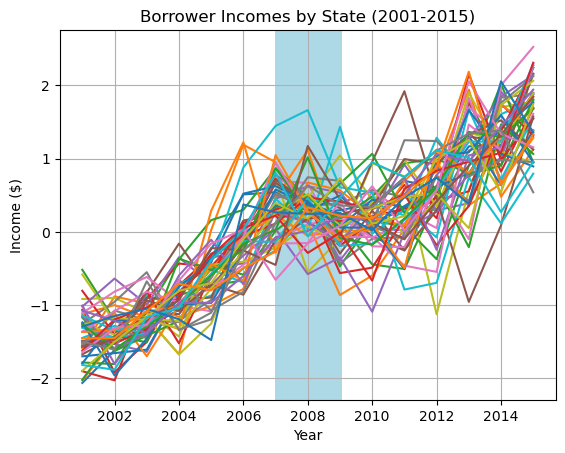

In [10]:
for column in TS_data_stand.columns[:-1]: 
    plt.plot(TS_data_stand['Year'], TS_data_stand[column])
    plt.axvspan(2007,2009,color = 'lightblue')

plt.title('Borrower Incomes by State (2001-2015)')
plt.xlabel('Year')
plt.ylabel('Income ($)')
plt.grid(True)
plt.show()

- Most states follow a similar overall trend, regional areas are affected by nationwide economic factors.
- Stunted growth due to the Great Recession.
- 4 year long recovery period saw convergence between states as high income states saw a sharper decline bringing them closer to the national average.
- due to economic growth in certain sectors (energy in Texas or tech again in California) some states saw rapid growth as compared to others leading to divergence and income disparity.

Lets look at states we know have higher economic activity,

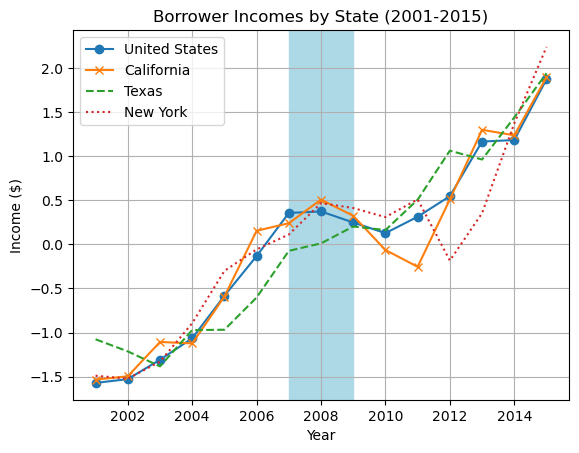

In [11]:
plt.plot(TS_data_stand['Year'], TS_data_stand['United States'], label='United States', marker='o')
plt.plot(TS_data_stand['Year'], TS_data_stand['California'], label='California', marker='x')
plt.plot(TS_data_stand['Year'], TS_data_stand['Texas'], label='Texas', linestyle='--')
plt.plot(TS_data_stand['Year'], TS_data_stand['New York'], label='New York', linestyle=':')
plt.axvspan(2007,2009, color = 'lightblue')
plt.title('Borrower Incomes by State (2001-2015)')
plt.xlabel('Year')
plt.ylabel('Income ($)')
plt.legend()
plt.grid(True)
plt.show()

Top performing states according to our data,

In [12]:
row_2015 =TS_data_stand[TS_data_stand['Year'] == 2015].drop('Year',axis = 1).T
row_2015.columns = ['Income']

In [13]:
row_2015.sort_values(by = 'Income', ascending = False).head()

Income
Missouri      2.522576
Tennessee     2.306937
Pennsylvania  2.293174
Ohio          2.268309
Illinois      2.268029

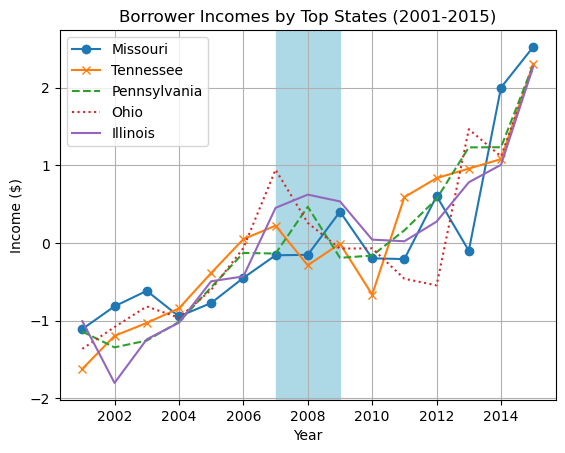

In [14]:
plt.plot(TS_data_stand['Year'], TS_data_stand['Missouri'], label='Missouri', marker='o')
plt.plot(TS_data_stand['Year'], TS_data_stand['Tennessee'], label='Tennessee', marker='x')
plt.plot(TS_data_stand['Year'], TS_data_stand['Pennsylvania'], label='Pennsylvania', linestyle='--')
plt.plot(TS_data_stand['Year'], TS_data_stand['Ohio'], label='Ohio', linestyle=':')
plt.plot(TS_data_stand['Year'], TS_data_stand['Illinois'], label='Illinois', linestyle='solid')
plt.axvspan(2007,2009, color = 'lightblue')
plt.title('Borrower Incomes by Top States (2001-2015)')
plt.xlabel('Year')
plt.ylabel('Income ($)')
plt.legend()
plt.grid(True)
plt.show()

### C) Heterogeneity and Merging

In [15]:
growth_rates = TS_data.set_index('Year').pct_change().dropna() * 100

In [16]:
growth_rates

United States    Alabama     Alaska    Arizona   Arkansas  California  \
Year                                                                          
2002       0.426237   6.939704  -8.002092  -6.955504  -2.849430    0.380872   
2003       2.145720  -0.904255  -1.762365   3.624465  -1.204075    3.920742   
2004       2.331487  -1.690821   6.211420   6.509594   9.312500   -0.162272   
2005       4.511617   1.419601   1.507446   3.192702   4.802744    5.160504   
2006       4.036262   2.153432   0.948291   3.116022   1.091107    6.877898   
...             ...        ...        ...        ...        ...         ...   
2011       1.562500   4.055705  -0.726016   3.667377   7.022545   -1.676492   
2012       1.938062   2.042733  10.830576  -3.249691  -5.520581    6.839048   
2013       5.037240   8.881730  13.857031  11.840986   0.922604    6.611715   
2014       0.130621 -10.650888  -6.678626  -6.386619  14.068055   -0.493502   
2015       5.329855   5.274361  11.060180   6.091371  -4.719501    5.207472   

       Colorado  Connecticut   Delaware  District of Columbia  ...  \
Year                                                           ...   
2002  -2.246964     0.074977   0.100806             -5.100802  ...   
2003   3.416856     2.959356  -1.268882             15.280266  ...   
2004   1.902283     0.236493  -1.978784             -3.530195  ...   
2005  -0.864610     3.157895   6.638918              3.544304  ...   
2006  10.406343     9.781844   2.341920              7.757279  ...   
...         ...          ...        ...                   ...  ...   
2011  -2.656483    -0.878788  -0.996196             -2.950992  ...   
2012  -2.336688    -1.788444 -10.409806             18.099548  ...   
2013  18.599371     7.844358  10.455381             -7.954023  ...   
2014 -10.263584     1.255592   6.341283             13.686314  ...   
2015   9.287824     3.891106   0.417246              2.621558  ...   

      South Dakota  Tennessee     Texas      Utah    Vermont   Virginia  \
Year                                                                      
2002     -4.537434   3.493572 -1.737641  1.098437   5.417995  -1.214172   
2003      4.357011   1.323251 -2.191781  2.966987   0.604651  10.376788   
2004      4.023279   1.465885  5.423988  3.226461   9.408229  -6.644761   
2005      4.962296   3.519832  0.048309  7.745233   7.120220   1.505671   
2006      5.283893   3.247907  4.563013 -0.328407   2.524655  10.036602   
...            ...        ...       ...       ...        ...        ...   
2011      4.123484   9.562063  3.765602 -2.134039  -7.276953   3.727017   
2012      4.659043   1.702933  5.871560  5.136061   7.173159   3.209837   
2013      8.073654   0.837209 -1.001348  4.645183  17.866139   1.980504   
2014     -0.674031   0.830258  4.804513  3.816544  -7.327126   0.379305   
2015      3.807729   8.257091  4.806978  4.544020  -2.009554  -7.058646   

      Washington  West Virginia  Wisconsin    Wyoming  
Year                                                   
2002    6.330901      -1.044826   1.212789   0.100705  
2003    5.157149      11.580381   0.806100   7.042254  
2004    5.072616       1.862027  -1.167063   6.672932  
2005    1.462340       9.229847  -2.361688  -1.497797  
2006    8.035538       5.404664  15.767077   5.187835  
...          ...            ...        ...        ...  
2011    1.228632      -2.244039   3.396226   4.425287  
2012    9.393140       4.136777   1.959278   5.503577  
2013    2.781798      -1.102181  -2.543331  17.266562  
2014   -7.587610      -8.172742  12.275275 -17.422894  
2015   13.831048       8.268015  -4.562672   9.409230  

[14 rows x 52 columns]

In [17]:
growth_rates

United States    Alabama     Alaska    Arizona   Arkansas  California  \
Year                                                                          
2002       0.426237   6.939704  -8.002092  -6.955504  -2.849430    0.380872   
2003       2.145720  -0.904255  -1.762365   3.624465  -1.204075    3.920742   
2004       2.331487  -1.690821   6.211420   6.509594   9.312500   -0.162272   
2005       4.511617   1.419601   1.507446   3.192702   4.802744    5.160504   
2006       4.036262   2.153432   0.948291   3.116022   1.091107    6.877898   
...             ...        ...        ...        ...        ...         ...   
2011       1.562500   4.055705  -0.726016   3.667377   7.022545   -1.676492   
2012       1.938062   2.042733  10.830576  -3.249691  -5.520581    6.839048   
2013       5.037240   8.881730  13.857031  11.840986   0.922604    6.611715   
2014       0.130621 -10.650888  -6.678626  -6.386619  14.068055   -0.493502   
2015       5.329855   5.274361  11.060180   6.091371  -4.719501    5.207472   

       Colorado  Connecticut   Delaware  District of Columbia  ...  \
Year                                                           ...   
2002  -2.246964     0.074977   0.100806             -5.100802  ...   
2003   3.416856     2.959356  -1.268882             15.280266  ...   
2004   1.902283     0.236493  -1.978784             -3.530195  ...   
2005  -0.864610     3.157895   6.638918              3.544304  ...   
2006  10.406343     9.781844   2.341920              7.757279  ...   
...         ...          ...        ...                   ...  ...   
2011  -2.656483    -0.878788  -0.996196             -2.950992  ...   
2012  -2.336688    -1.788444 -10.409806             18.099548  ...   
2013  18.599371     7.844358  10.455381             -7.954023  ...   
2014 -10.263584     1.255592   6.341283             13.686314  ...   
2015   9.287824     3.891106   0.417246              2.621558  ...   

      South Dakota  Tennessee     Texas      Utah    Vermont   Virginia  \
Year                                                                      
2002     -4.537434   3.493572 -1.737641  1.098437   5.417995  -1.214172   
2003      4.357011   1.323251 -2.191781  2.966987   0.604651  10.376788   
2004      4.023279   1.465885  5.423988  3.226461   9.408229  -6.644761   
2005      4.962296   3.519832  0.048309  7.745233   7.120220   1.505671   
2006      5.283893   3.247907  4.563013 -0.328407   2.524655  10.036602   
...            ...        ...       ...       ...        ...        ...   
2011      4.123484   9.562063  3.765602 -2.134039  -7.276953   3.727017   
2012      4.659043   1.702933  5.871560  5.136061   7.173159   3.209837   
2013      8.073654   0.837209 -1.001348  4.645183  17.866139   1.980504   
2014     -0.674031   0.830258  4.804513  3.816544  -7.327126   0.379305   
2015      3.807729   8.257091  4.806978  4.544020  -2.009554  -7.058646   

      Washington  West Virginia  Wisconsin    Wyoming  
Year                                                   
2002    6.330901      -1.044826   1.212789   0.100705  
2003    5.157149      11.580381   0.806100   7.042254  
2004    5.072616       1.862027  -1.167063   6.672932  
2005    1.462340       9.229847  -2.361688  -1.497797  
2006    8.035538       5.404664  15.767077   5.187835  
...          ...            ...        ...        ...  
2011    1.228632      -2.244039   3.396226   4.425287  
2012    9.393140       4.136777   1.959278   5.503577  
2013    2.781798      -1.102181  -2.543331  17.266562  
2014   -7.587610      -8.172742  12.275275 -17.422894  
2015   13.831048       8.268015  -4.562672   9.409230  

[14 rows x 52 columns]

In [18]:
def custom_interpolate(start, end):
    growth_rate = (end - start) / start * 100
    if growth_rate > 5:
        weights = np.array([0.15, 0.20, 0.25, 0.40])
    elif growth_rate < 0:
        weights = np.array([0.30, 0.30, 0.20, 0.20])
    else:
        weights = np.array([0.25, 0.25, 0.25, 0.25])
    total_growth = end - start
    quarterly_gains = total_growth * weights
    quarterly_values = np.cumsum(quarterly_gains) + start
    return quarterly_values.tolist()

quarterly_growth_rates = pd.DataFrame(index=np.arange(1, 61), columns=growth_rates.columns)

for state in growth_rates.columns:
    interpolated_values = []
    years = growth_rates.index
    for i in range(len(years) - 1):
        start = growth_rates.loc[years[i], state]
        end = growth_rates.loc[years[i + 1], state]
        interpolated_values.extend(custom_interpolate(start, end))
    
    last_value = growth_rates.loc[years[-1], state]
    extrapolation = custom_interpolate(last_value, last_value * 1.05)  
    interpolated_values.extend(extrapolation)

    
    if len(interpolated_values) > 60:
        interpolated_values = interpolated_values[:60] 
    elif len(interpolated_values) < 60:
        
        last_known_value = interpolated_values[-1]
        interpolated_values += [last_known_value] * (60 - len(interpolated_values))

    quarterly_growth_rates[state] = interpolated_values

print(quarterly_growth_rates.head())
print("Data shape:", quarterly_growth_rates.shape)


   United States   Alabama    Alaska   Arizona  Arkansas  California  \
1       0.684160  4.586516 -6.130174 -3.781513 -2.355824    0.911852   
2       1.028056  2.233328 -4.258256 -0.607522 -1.862217    1.619826   
3       1.457927  0.664537 -3.010310  1.508471 -1.533146    2.504794   
4       2.145720 -0.904255 -1.762365  3.624465 -1.204075    3.920742   
5       2.173585 -1.022240  0.629770  4.057235  1.950897    2.695838   

   Colorado  Connecticut  Delaware  District of Columbia  ...  South Dakota  \
1 -0.547818     0.507633 -0.310100              1.013519  ...     -1.869100   
2  1.151328     1.084509 -0.721007              7.127839  ...      0.799233   
3  2.284092     1.805604 -0.994944             11.204053  ...      2.578122   
4  3.416856     2.959356 -1.268882             15.280266  ...      4.357011   
5  2.962484     2.142497 -1.375367              9.637128  ...      4.256891   

   Tennessee     Texas      Utah   Vermont   Virginia  Washington  \
1   2.842476 -1.805762 

In [19]:
quarterly_growth_rates.describe()

United States    Alabama     Alaska    Arizona   Arkansas  California  \
count      60.000000  60.000000  60.000000  60.000000  60.000000   60.000000   
mean        2.460836   1.887035   3.581373   2.471465   1.252912    2.599590   
std         2.069452   4.522700   6.012563   3.451566   5.066479    2.948250   
min        -1.033797 -10.650888  -6.678626  -6.386619  -7.703966   -3.295920   
25%         1.009495  -0.794335  -1.645057  -0.006666  -3.609826    0.843913   
50%         2.233959   2.410758   2.881434   2.818899   1.462271    2.600316   
75%         4.140444   5.338104   9.178367   5.395289   5.633891    5.353932   
max         5.596347  11.225296  13.857031  11.840986  14.068055    6.877898   

        Colorado  Connecticut   Delaware  District of Columbia  ...  \
count  60.000000    60.000000  60.000000             60.000000  ...   
mean    3.541129     2.442276   1.252691              4.340037  ...   
std     5.823294     2.424317   3.981642              4.924204  ...   
min   -10.263584    -1.788444 -10.409806             -7.954023  ...   
25%    -0.557751     0.754475  -1.042572              1.883186  ...   
50%     2.512394     1.897469   0.669359              4.050582  ...   
75%     9.479385     4.049182   3.871513              7.067555  ...   
max    18.599371     9.781844  10.455381             18.099548  ...   

       South Dakota  Tennessee      Texas       Utah    Vermont   Virginia  \
count     60.000000  60.000000  60.000000  60.000000  60.000000  60.000000   
mean       2.852669   2.654238   2.771453   2.824087   2.072127   0.602091   
std        3.756382   3.466024   2.283618   4.140068   5.484580   4.744715   
min      -11.182171  -4.763080  -2.191781  -6.475855  -8.830319  -7.411578   
25%        2.148170   0.836688   1.081454  -0.046859  -2.110031  -1.989963   
50%        3.998115   1.859130   3.013953   3.749292   2.588398   1.502908   
75%        4.489150   3.597875   4.812117   4.771221   5.770278   3.610651   
max       11.158983   9.562063   6.326483  16.831683  17.866139  10.376788   

       Washington  West Virginia  Wisconsin    Wyoming  
count   60.000000      60.000000  60.000000  60.000000  
mean     4.452749       3.634988   0.902945   4.010852  
std      5.662750       4.877274   4.520740   5.598700  
min     -7.587610      -9.741031  -4.790806 -17.422894  
25%      1.161026       0.699896  -1.426731   1.098298  
50%      4.942489       4.710314  -0.120887   4.456408  
75%      6.704299       7.940515   2.277400   7.058760  
max     14.522600      11.580381  15.767077  17.266562  

[8 rows x 52 columns]

In [20]:
state_mapping = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming',
    'DC': 'District of Columbia' , 'Missing': 'Missing'
}
data['state_full_name'] = data['state_orig_time'].map(state_mapping)

In [21]:
quarterly_growth_rates_transposed = quarterly_growth_rates.T.reset_index()
quarterly_growth_rates_transposed.columns = ['state_full_name'] + list(range(1, 61))


In [22]:
data['time'] = data['time'].astype(int)

merged_data = pd.merge(data, quarterly_growth_rates_transposed, how='left', on='state_full_name')

for i in range(1, 61):
    merged_data.loc[merged_data['time'] == i, 'quarterly_growth_rate'] = merged_data[i]

columns_to_drop = list(range(1, 61))
merged_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

print(merged_data.head())

   id  time  orig_time  first_time  mat_time  res_time  balance_time  \
0   4    25         -2          25       119       NaN      61031.10   
1   4    26         -2          25       119       NaN      60882.42   
2   4    27         -2          25       119       NaN      60729.80   
3   4    28         -2          25       119       NaN      60576.14   
4   4    29         -2          25       119       NaN      60424.39   

    LTV_time  interest_rate_time  rate_time  ...  Interest_Rate_orig_time  \
0  33.911009              10.500        5.9  ...                     10.5   
1  34.007232              10.500        5.9  ...                     10.5   
2  34.335349              10.500        5.9  ...                     10.5   
3  34.672545              10.875        5.9  ...                     10.5   
4  34.951639              10.875        5.9  ...                     10.5   

   state_orig_time  hpi_orig_time  default_time  payoff_time  status_time  \
0               KY         

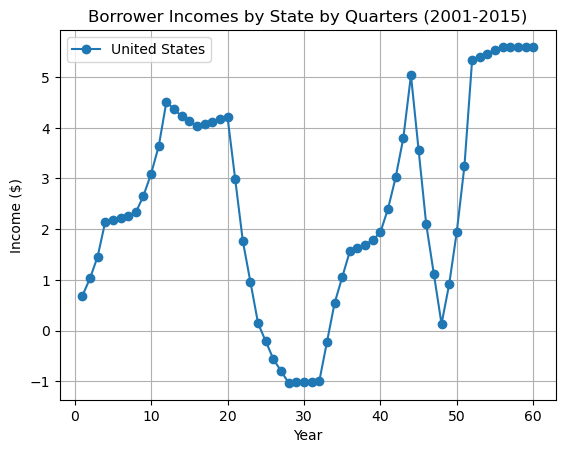

In [23]:
plt.plot(quarterly_growth_rates.index, quarterly_growth_rates['United States'], label='United States', marker='o')
plt.title('Borrower Incomes by State by Quarters (2001-2015)')
plt.xlabel('Year')
plt.ylabel('Income ($)')
plt.legend()
plt.grid(True)
plt.show()

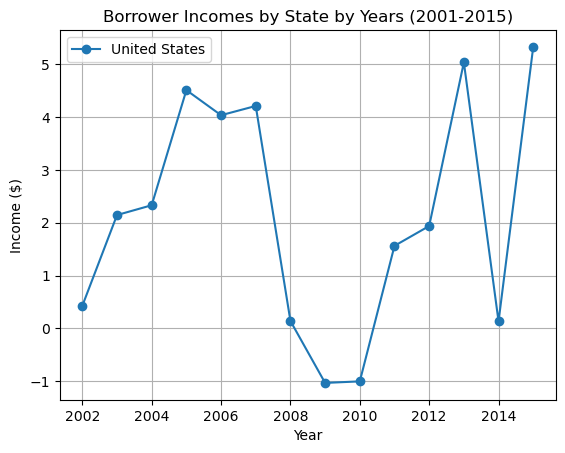

In [24]:
plt.plot(growth_rates.index , growth_rates['United States'], label='United States', marker='o')
plt.title('Borrower Incomes by State by Years (2001-2015)')
plt.xlabel('Year')
plt.ylabel('Income ($)')
plt.legend()
plt.grid(True)
plt.show()

Therefore, My yearly to quarterly transformation has been successful and the merged dataset is ready for further analysis.

## Problem 2 : PD modelling

### A) PD model using FICO and LTV as explanatory variables

In [25]:
merged_data

id  time  orig_time  first_time  mat_time  res_time  balance_time  \
0          4    25         -2          25       119       NaN      61031.10   
1          4    26         -2          25       119       NaN      60882.42   
2          4    27         -2          25       119       NaN      60729.80   
3          4    28         -2          25       119       NaN      60576.14   
4          4    29         -2          25       119       NaN      60424.39   
...      ...   ...        ...         ...       ...       ...           ...   
62173  49972    52         25          52       145       NaN     180673.24   
62174  49972    53         25          52       145       NaN     179944.95   
62175  49972    54         25          52       145       NaN     179451.81   
62176  49972    55         25          52       145       NaN     178952.48   
62177  49972    56         25          52       145       NaN     178952.48   

         LTV_time  interest_rate_time  rate_time  ...  \
0       33.911009              10.500       5.90  ...   
1       34.007232              10.500       5.90  ...   
2       34.335349              10.500       5.90  ...   
3       34.672545              10.875       5.90  ...   
4       34.951639              10.875       5.90  ...   
...           ...                 ...        ...  ...   
62173  103.306966               7.500       5.15  ...   
62174   95.736862               7.500       5.15  ...   
62175   91.867079               7.500       5.15  ...   
62176   91.560581               7.500       5.15  ...   
62177   90.874242               7.500       5.15  ...   

       Interest_Rate_orig_time  state_orig_time  hpi_orig_time  default_time  \
0                         10.5               KY          97.99             0   
1                         10.5               KY          97.99             0   
2                         10.5               KY          97.99             0   
3                         10.5               KY          97.99             0   
4                         10.5               KY          97.99             0   
...                        ...              ...            ...           ...   
62173                      7.5               AL         226.29             0   
62174                      7.5               AL         226.29             0   
62175                      7.5               AL         226.29             0   
62176                      7.5               AL         226.29             0   
62177                      7.5               AL         226.29             1   

       payoff_time  status_time  lgd_time  recovery_res  state_full_name  \
0                0            0       NaN           NaN         Kentucky   
1                0            0       NaN           NaN         Kentucky   
2                0            0       NaN           NaN         Kentucky   
3                0            0       NaN           NaN         Kentucky   
4                0            0       NaN           NaN         Kentucky   
...            ...          ...       ...           ...              ...   
62173            0            0       NaN           NaN          Alabama   
62174            0            0       NaN           NaN          Alabama   
62175            0            0       NaN           NaN          Alabama   
62176            0            0       NaN           NaN          Alabama   
62177            0            1       0.0     178952.48          Alabama   

       quarterly_growth_rate  
0                   4.117327  
1                   3.925402  
2                   3.797452  
3                   3.669502  
4                   1.471605  
...                      ...  
62173               5.274361  
62174               5.313919  
62175               5.366663  
62176               5.432592  
62177               5.538079  

[62178 rows x 30 columns]

Let's break this model building process into steps for clarity :
-  Visualize the distribution and relationship of predictor variables (FICO scores and LTV ratios) with the default outcome to gain deeper insights and justify the choice of a logit or probit model.
- Fit a regression model using these variables.
- Compute the predicted probabilities of default for each mortgage loan.
- Calculate the average probability of default by time and plot it against time.

In [26]:
description = merged_data[['FICO_orig_time', 'LTV_orig_time', 'default_time']].describe()
description

FICO_orig_time  LTV_orig_time  default_time
count    62178.000000   62178.000000  62178.000000
mean       673.357200      78.702839      0.024526
std         72.100064      10.243045      0.154678
min        429.000000      50.100000      0.000000
25%        628.000000      75.000000      0.000000
50%        675.000000      80.000000      0.000000
75%        730.000000      80.000000      0.000000
max        819.000000     119.800000      1.000000

- FICO_orig_time: The FICO scores range from 429 to 819, with an average score of approximately 673.
- LTV_orig_time: The Loan-to-Value ratios range from 50.1 to 119.8, with an average of about 78.7.
- default_time: This is a binary variable where '1' indicates a default. The mean suggests about 2.45% of the loans in this sample have defaulted.

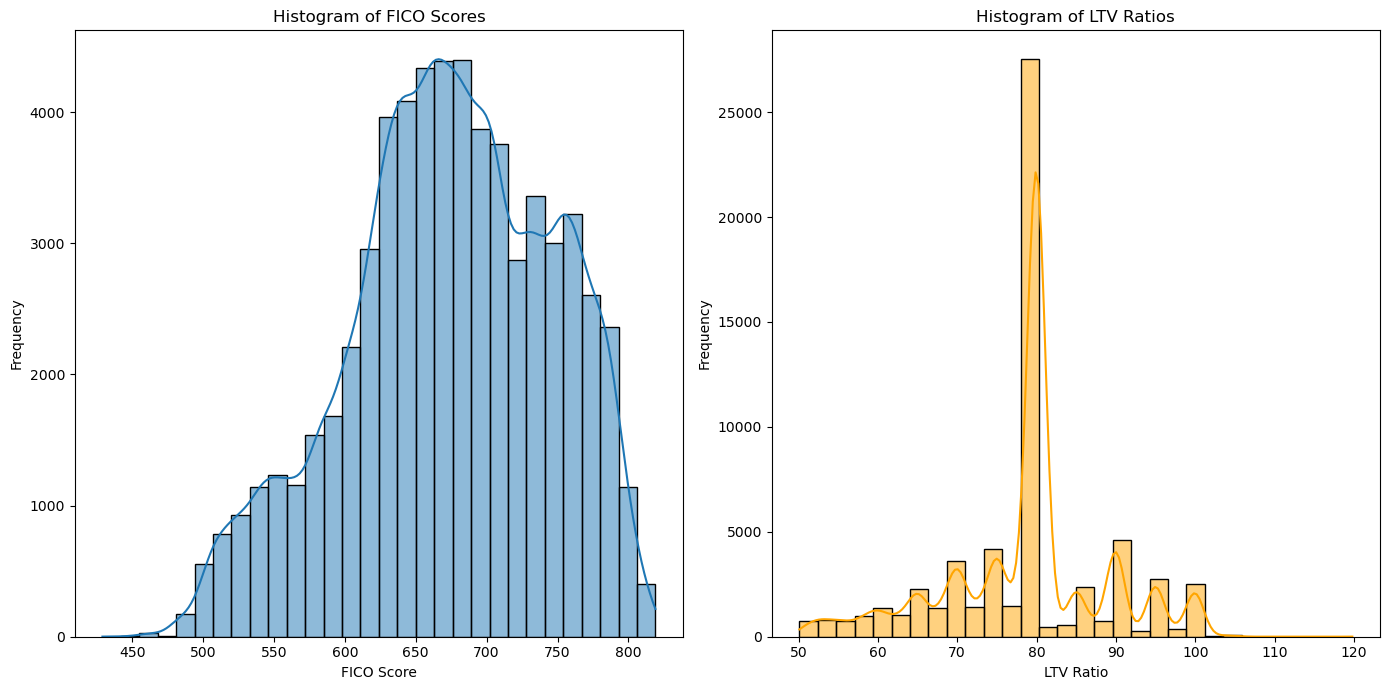

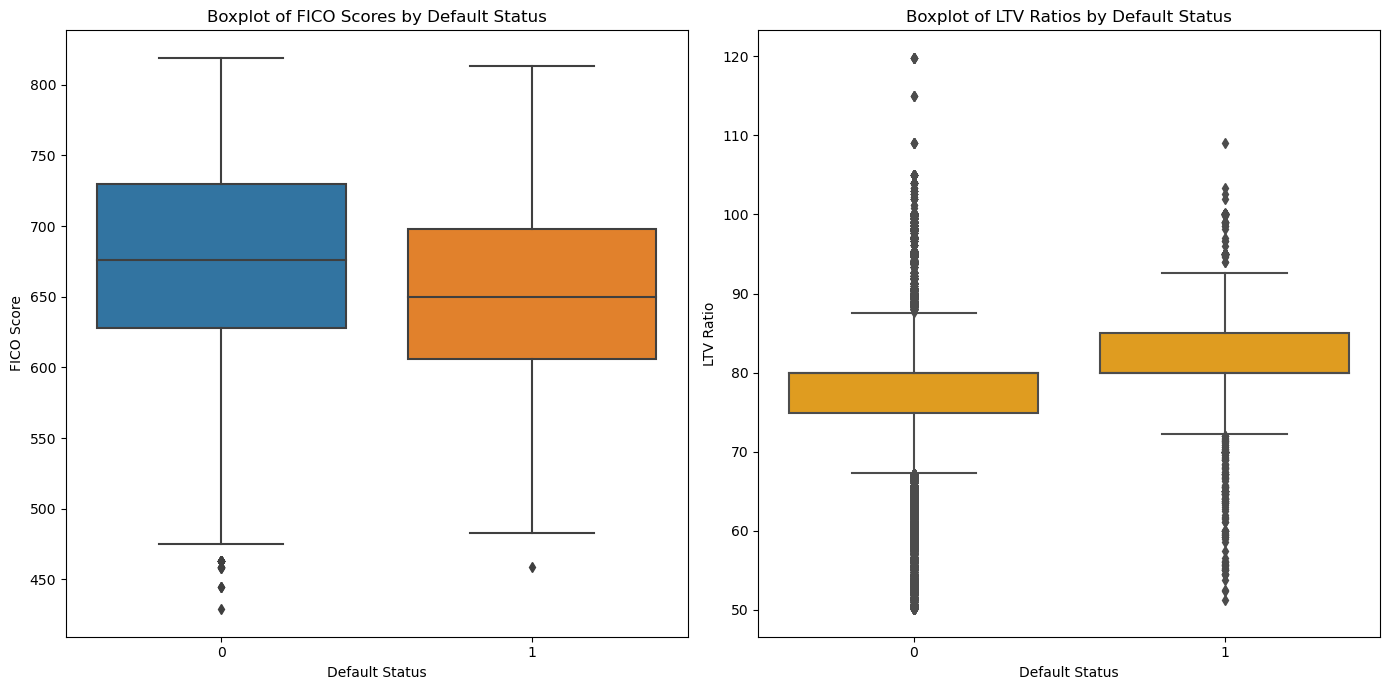

In [27]:
plt.figure(figsize=(14, 7))

# Histograms of FICO scores and LTV ratios
plt.subplot(1, 2, 1)
sns.histplot(merged_data['FICO_orig_time'], bins=30, kde=True)
plt.title('Histogram of FICO Scores')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(merged_data['LTV_orig_time'], bins=30, kde=True, color='orange')
plt.title('Histogram of LTV Ratios')
plt.xlabel('LTV Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Boxplots of FICO scores and LTV ratios by default status
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.boxplot(x='default_time', y='FICO_orig_time', data=merged_data)
plt.title('Boxplot of FICO Scores by Default Status')
plt.xlabel('Default Status')
plt.ylabel('FICO Score')

plt.subplot(1, 2, 2)
sns.boxplot(x='default_time', y='LTV_orig_time', data=merged_data, color='orange')
plt.title('Boxplot of LTV Ratios by Default Status')
plt.xlabel('Default Status')
plt.ylabel('LTV Ratio')

plt.tight_layout()
plt.show()


**Histograms**
- FICO Scores: The distribution of FICO scores shows a fairly normal but slightly right-skewed pattern, which suggests most borrowers have moderately high credit scores, which is a good sign for the banks.
- LTV Ratios: The LTV ratios are distributed in a peculiar way where they peak at 80, indicating the banks have set a cap for a major portion of loans at 80%, this might be something to do with a risk tolreance for majority of banks.

**Boxplots**
- FICO Scores by Default Status: The boxplot indicates that defaulted loans tend to have lower FICO scores compared to non-defaulted loans. This supports the intuition that lower credit scores are associated with higher risk of default.
- LTV Ratios by Default Status: Similarly, loans that ended in default show higher LTV ratios on average than those that did not default. This suggests that higher loan-to-value ratios are indicative of greater default risk.

In [28]:
correlation_matrix = merged_data[['FICO_orig_time', 'LTV_orig_time', 'default_time']].corr()
correlation_matrix

FICO_orig_time  LTV_orig_time  default_time
FICO_orig_time        1.000000      -0.139082     -0.052535
LTV_orig_time        -0.139082       1.000000      0.036249
default_time         -0.052535       0.036249      1.000000

- **FICO_orig_time and default_time:** Weak negative correlation (-0.052), indicating that higher FICO scores are slightly associated with lower default rates.
- **LTV_orig_time and default_time:** Slight positive correlation (0.036), showing a weak relationship where higher LTV ratios are somewhat linked to higher default probabilities.
- **FICO_orig_time and LTV_orig_time:** Weak negative correlation (-0.139), which is good as it suggests no strong multicollinearity that would impair the model's estimation.

Fitting a Logistic Regression Model

In [317]:
data_PD1 = merged_data[['FICO_orig_time', 'LTV_orig_time','default_time','time']].dropna()

In [318]:
formula = 'default_time ~ FICO_orig_time + LTV_orig_time'

Logit_result = smf.glm(formula=formula, data=data_PD1, family=sm.families.Binomial()).fit()


Logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           default_time   No. Observations:                62178
Model:                            GLM   Df Residuals:                    62175
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7049.0
Date:                Tue, 14 May 2024   Deviance:                       14098.
Time:                        21:59:58   Pearson chi2:                 6.11e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.003593
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.4153      0.331     -7.292      0.000      -3.065      -1.766
FICO_orig_time    -0.0043      0.000    -11.944      0.000      -0.005      -0.004
LTV_orig_time      0.0194      0.003      7.457      0.000       0.014       0.024
==================================================================================
"""

Model Coefficients:
- Intercept (const): -2.4153, which is the log-odds of default when the FICO score and LTV ratio are zero (not practical but serves as a baseline in the model).
- FICO_orig_time: -0.0043, indicating that higher FICO scores decrease the log-odds of defaulting, as expected. The negative coefficient shows an inverse relationship.
- LTV_orig_time: +0.0194, showing that higher LTV ratios increase the log-odds of defaulting, which aligns with intuition that more leveraged loans are riskier.

Model Statistics:
- Pseudo R-squared: 0.003593, which is relatively low, indicating that the model explains a small portion of the variability in defaults. This is common in credit risk models where default events are rare and influenced by many factors not included in the model.
- Log-Likelihood and LLR p-value: The model is statistically significant overall (p-value near zero).

In [319]:
PD_logit = pd.DataFrame(Logit_result.predict(X_test), columns=['Logit_result'])
PD_logit

Logit_result
29758      0.040234
29935      0.036369
280        0.023784
42635      0.017980
59949      0.020449
...             ...
24919      0.012713
51664      0.014764
48738      0.017101
31204      0.026868
6535       0.019666

[18425 rows x 1 columns]

In [320]:
merged_data_PD1 = pd.merge(data_PD1,PD_logit, right_index=True, left_index=True)

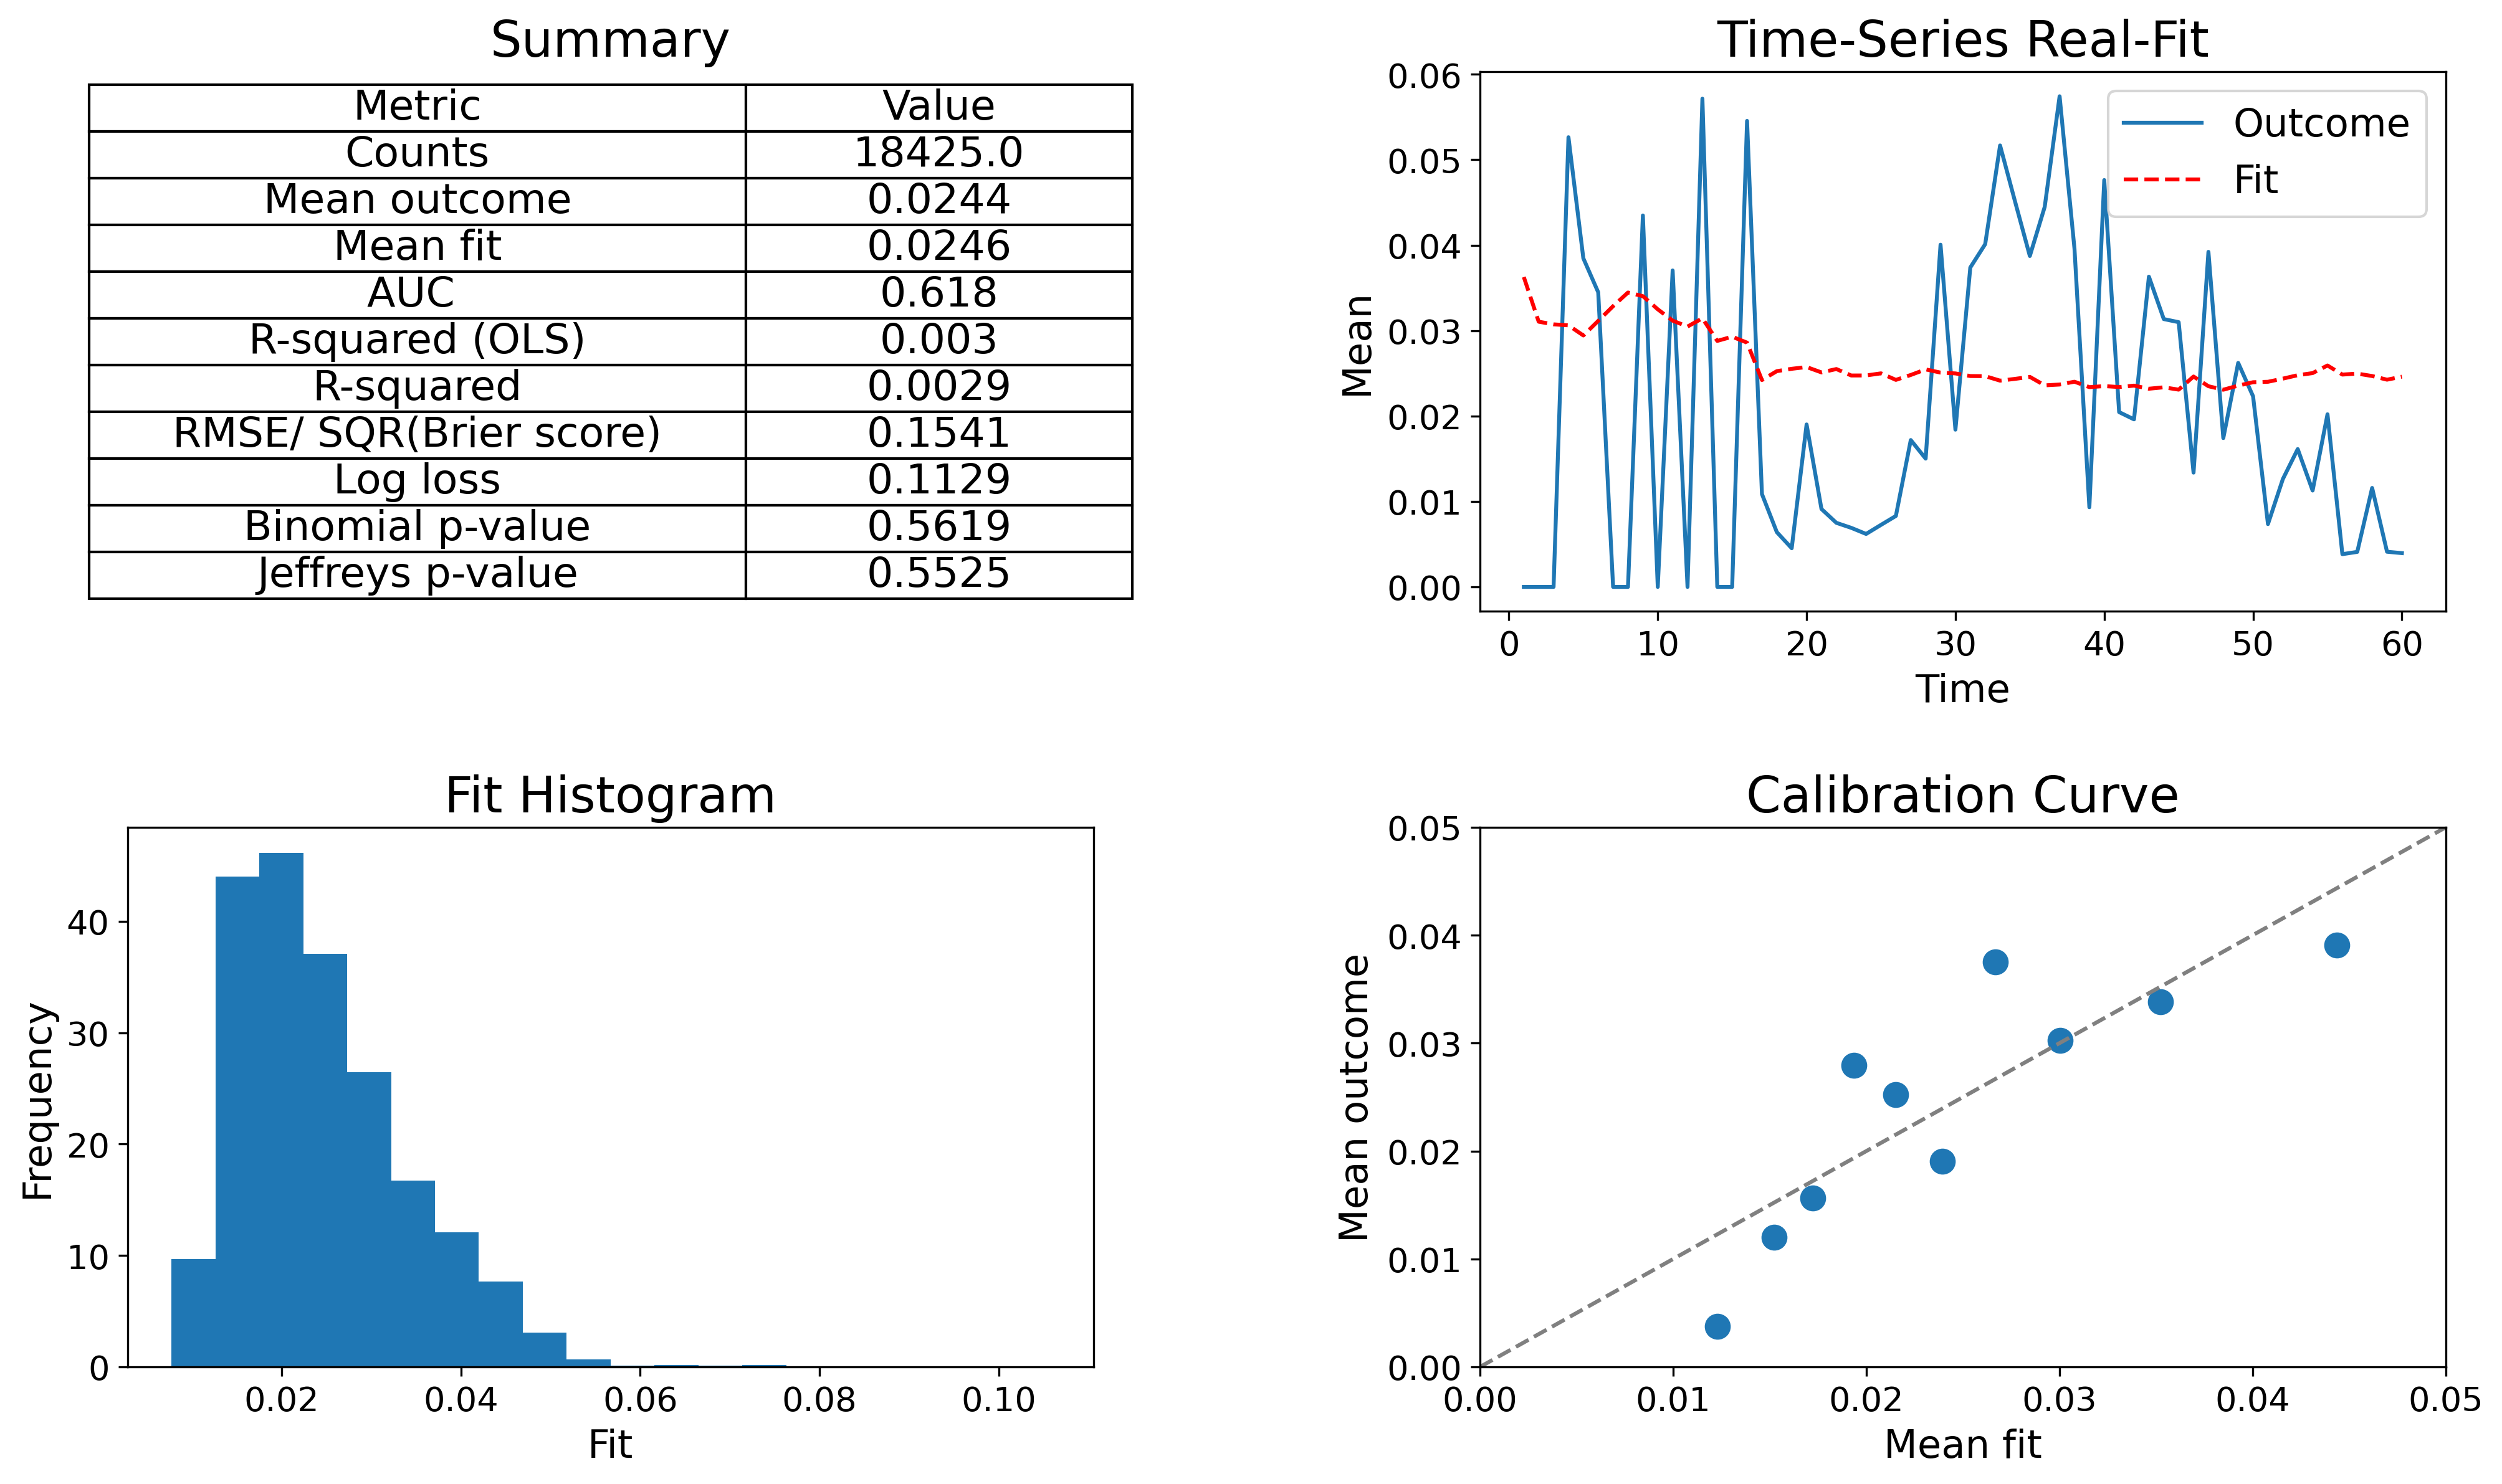

In [321]:
validation(merged_data_PD1.Logit_result, merged_data_PD1.default_time, merged_data_PD1.time)

Calcculating average probability of default and plotting it against time

In [322]:
average_pd_by_time = merged_data_PD1.groupby('time')['Logit_result'].mean()

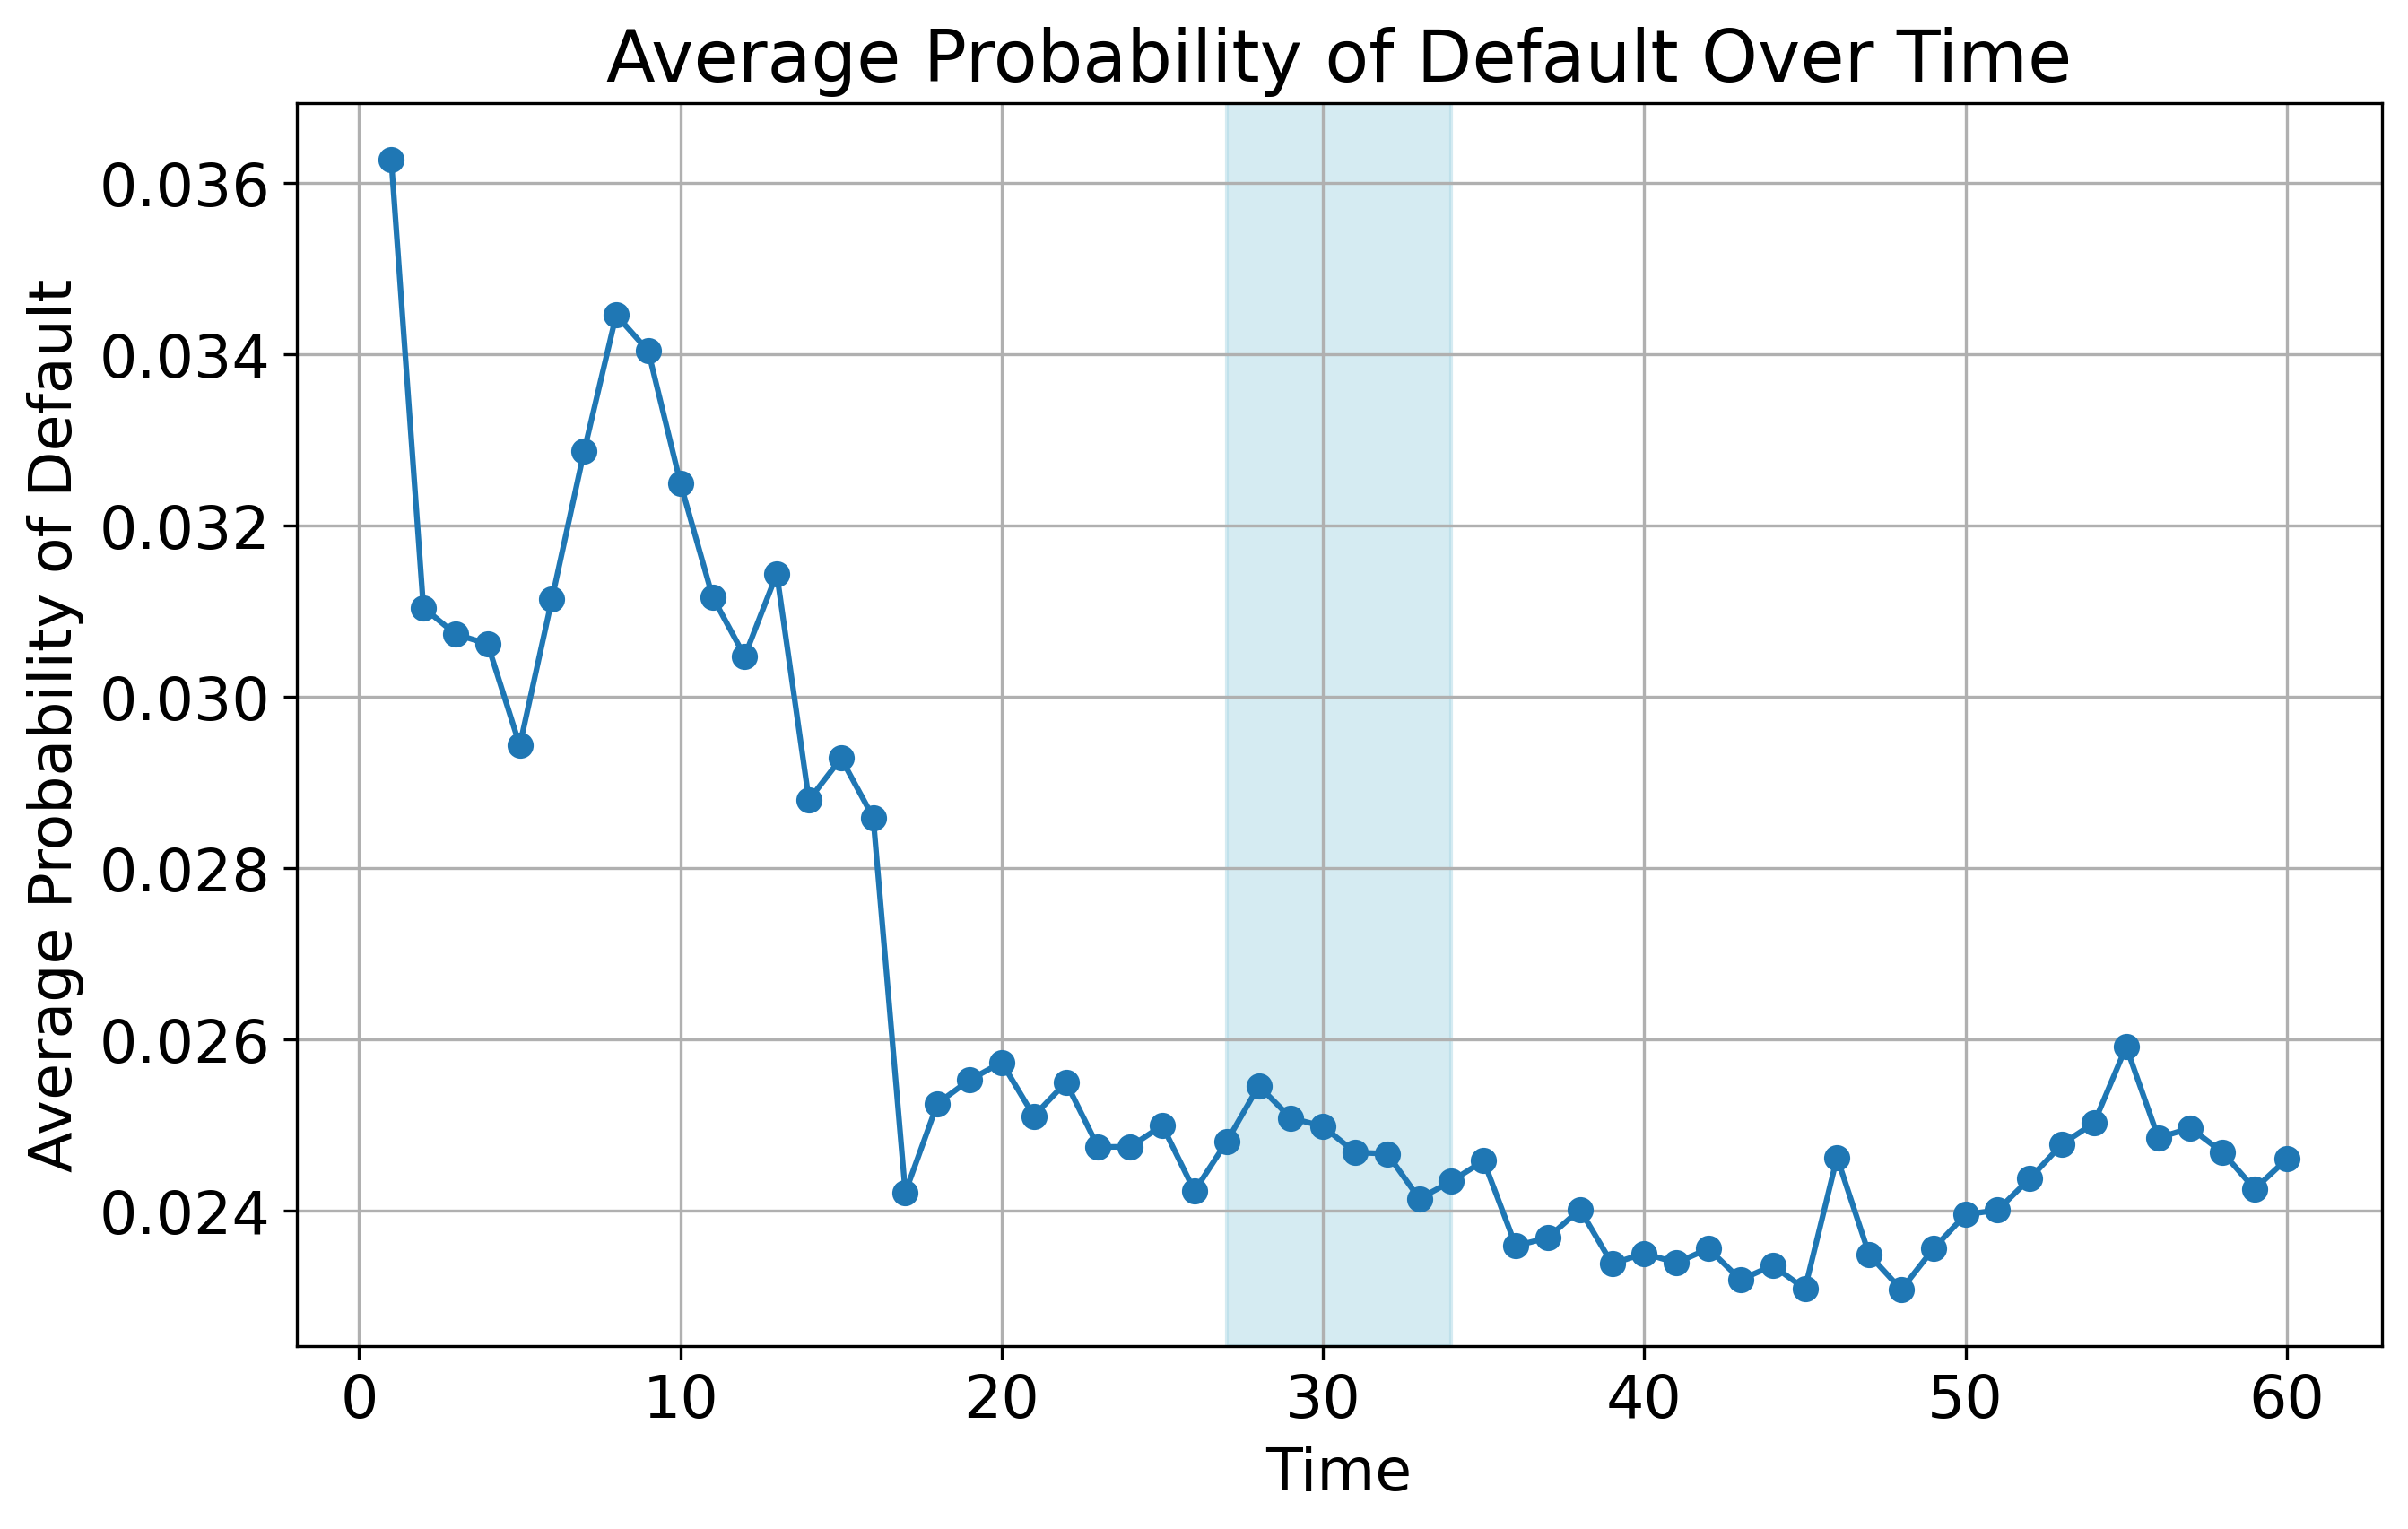

In [323]:
plt.figure(figsize=(10, 6))
plt.plot(average_pd_by_time, marker='o', linestyle='-')
plt.axvspan(27, 34, color="lightblue", alpha=0.5)
plt.title('Average Probability of Default Over Time')
plt.xlabel('Time')
plt.ylabel('Average Probability of Default')
plt.grid(True)
plt.show()

We have attempted to create a logistic regression model which helps us to predict the probablitity of a default , 1 or 0 , then we plotted this probability over time to see how time effects the probability of default. Major insights gained from this visualization are :
- Early Volatility: New loans display higher default probability this can be due to uncertainties regarding the borrowers' financial situations and adjustments to their new repayment schedules, also LTVs are higher at the beginning of the term if everything goes well and the loan amount is paid slowly the LTV goes down bringing down the probability to default this is in line with our exploratory analysis.
- Sharp Decline: The sharp decline in default probabilities as time progresses could indicate that borrowers who survive the initial risky periods tend to stabilize financially. This could also be weeding out of higher risk loans that default early in the loan term. This was also the period between 2003 - 2005 which could possibly mean somthing in economic terms. 
- Middle Period Stability: The middle period, where default probability is lower and more stable, likely represents a "seasoning" effect where loans that have not defaulted early are less likely to default as they mature. Also at this point with considerable payments already made to repay the loan the LTV ration is much lower. However, there can be cases where LTV goes up if the price of the collateral goes drops significantly which can be the case with property.

### B) PD Model using FICO, LTV, and Borrower income growth rates

Now we repeat the same process as before but this time we will use the borrower income as an additional explanatory variable.

In [35]:
merged_data

id  time  orig_time  first_time  mat_time  res_time  balance_time  \
0          4    25         -2          25       119       NaN      61031.10   
1          4    26         -2          25       119       NaN      60882.42   
2          4    27         -2          25       119       NaN      60729.80   
3          4    28         -2          25       119       NaN      60576.14   
4          4    29         -2          25       119       NaN      60424.39   
...      ...   ...        ...         ...       ...       ...           ...   
62173  49972    52         25          52       145       NaN     180673.24   
62174  49972    53         25          52       145       NaN     179944.95   
62175  49972    54         25          52       145       NaN     179451.81   
62176  49972    55         25          52       145       NaN     178952.48   
62177  49972    56         25          52       145       NaN     178952.48   

         LTV_time  interest_rate_time  rate_time  ...  \
0       33.911009              10.500       5.90  ...   
1       34.007232              10.500       5.90  ...   
2       34.335349              10.500       5.90  ...   
3       34.672545              10.875       5.90  ...   
4       34.951639              10.875       5.90  ...   
...           ...                 ...        ...  ...   
62173  103.306966               7.500       5.15  ...   
62174   95.736862               7.500       5.15  ...   
62175   91.867079               7.500       5.15  ...   
62176   91.560581               7.500       5.15  ...   
62177   90.874242               7.500       5.15  ...   

       Interest_Rate_orig_time  state_orig_time  hpi_orig_time  default_time  \
0                         10.5               KY          97.99             0   
1                         10.5               KY          97.99             0   
2                         10.5               KY          97.99             0   
3                         10.5               KY          97.99             0   
4                         10.5               KY          97.99             0   
...                        ...              ...            ...           ...   
62173                      7.5               AL         226.29             0   
62174                      7.5               AL         226.29             0   
62175                      7.5               AL         226.29             0   
62176                      7.5               AL         226.29             0   
62177                      7.5               AL         226.29             1   

       payoff_time  status_time  lgd_time  recovery_res  state_full_name  \
0                0            0       NaN           NaN         Kentucky   
1                0            0       NaN           NaN         Kentucky   
2                0            0       NaN           NaN         Kentucky   
3                0            0       NaN           NaN         Kentucky   
4                0            0       NaN           NaN         Kentucky   
...            ...          ...       ...           ...              ...   
62173            0            0       NaN           NaN          Alabama   
62174            0            0       NaN           NaN          Alabama   
62175            0            0       NaN           NaN          Alabama   
62176            0            0       NaN           NaN          Alabama   
62177            0            1       0.0     178952.48          Alabama   

       quarterly_growth_rate  
0                   4.117327  
1                   3.925402  
2                   3.797452  
3                   3.669502  
4                   1.471605  
...                      ...  
62173               5.274361  
62174               5.313919  
62175               5.366663  
62176               5.432592  
62177               5.538079  

[62178 rows x 30 columns]

In [36]:
description = merged_data[['FICO_orig_time', 'LTV_orig_time', 'quarterly_growth_rate', 'default_time']].describe()
description

FICO_orig_time  LTV_orig_time  quarterly_growth_rate  default_time
count    62178.000000   62178.000000           61414.000000  62178.000000
mean       673.357200      78.702839               1.591936      0.024526
std         72.100064      10.243045               3.973333      0.154678
min        429.000000      50.100000             -17.422894      0.000000
25%        628.000000      75.000000              -1.364702      0.000000
50%        675.000000      80.000000               1.357956      0.000000
75%        730.000000      80.000000               4.298754      0.000000
max        819.000000     119.800000              22.311015      1.000000

quarterly_growth_rate varies significantly, ranging from -17.42% to 22.31%.The mean quarterly growth rate is about 1.59%, but the standard deviation is relatively high at 3.97%.

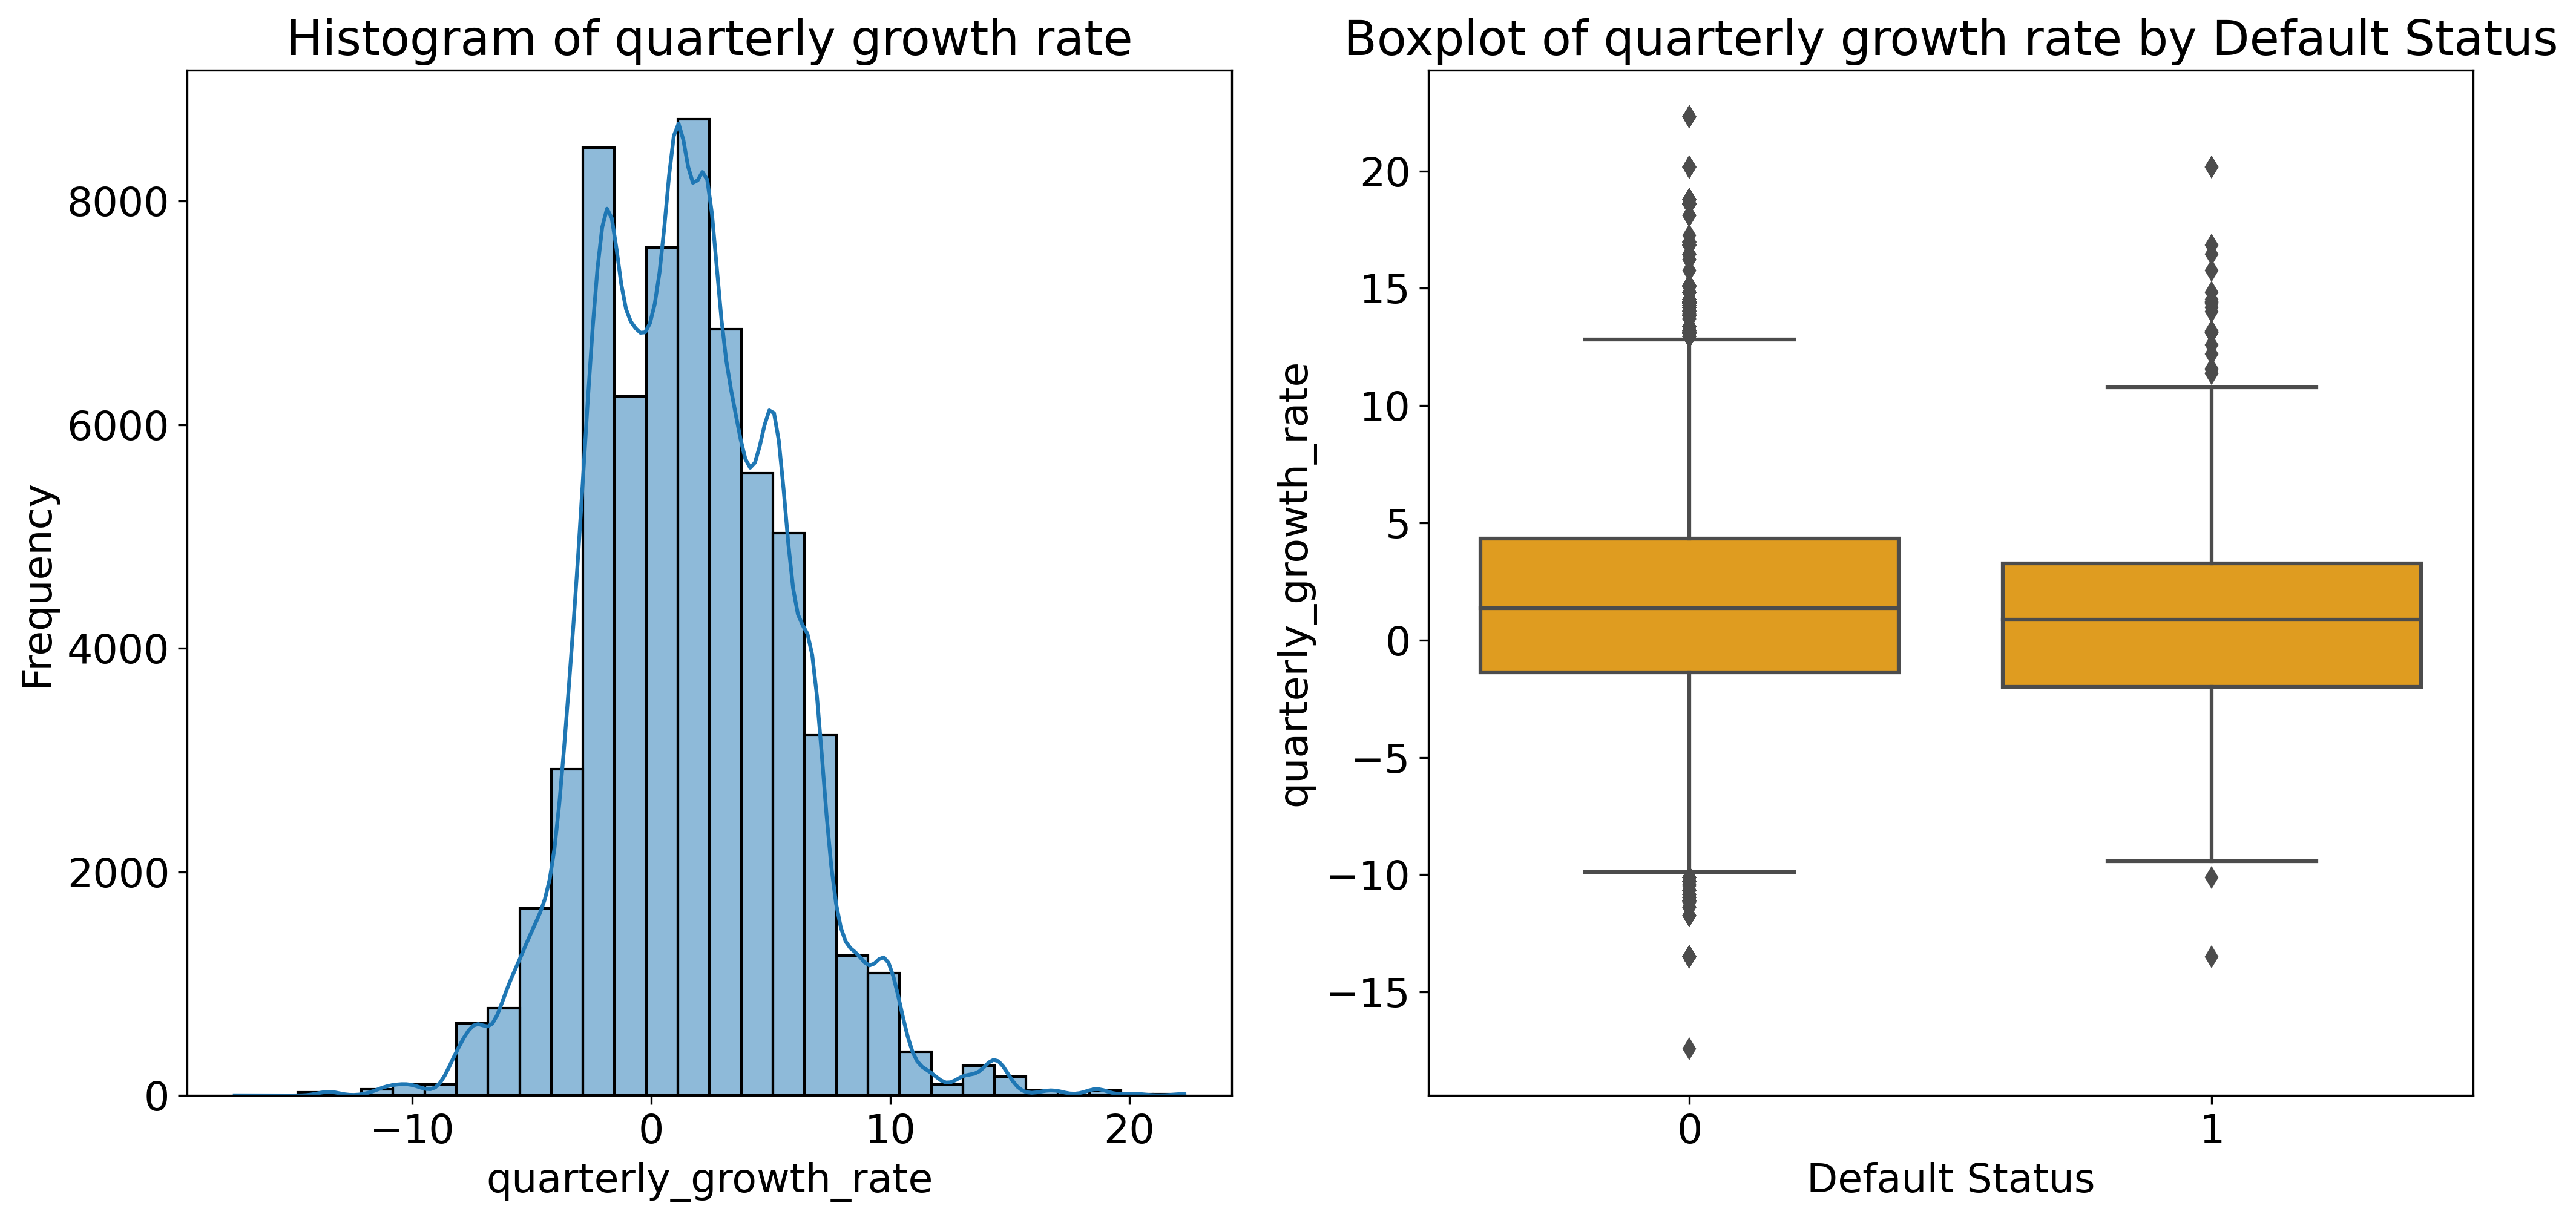

In [37]:
plt.figure(figsize=(14, 7))

# Histogram of quarterly_growth_rate
plt.subplot(1, 2, 1)
sns.histplot(merged_data['quarterly_growth_rate'], bins=30, kde=True)
plt.title('Histogram of quarterly growth rate')
plt.xlabel('quarterly_growth_rate')
plt.ylabel('Frequency')

# Boxplot of quarterly_growth_rate
plt.subplot(1, 2, 2)
sns.boxplot(x='default_time', y='quarterly_growth_rate', data=merged_data, color='orange')
plt.title('Boxplot of quarterly growth rate by Default Status')
plt.xlabel('Default Status')
plt.ylabel('quarterly_growth_rate')

plt.tight_layout()
plt.show()

Histogram : 
- quarterly growth rates cluster around a central value with a roughly normal distribution.

Boxplot : 
- Both defaulted and non-defaulted loans have similar median quarterly growth rates, suggesting that the median economic condition does not drastically differ between these groups.
- Defaulted loans (1) exhibit a wider interquartile range and more extreme outliers in negative growth rates compared to non-defaulted loans. This could imply that worse economic conditions might be a contributing factor to higher default rates.

In [38]:
correlation_matrix = merged_data[['FICO_orig_time', 'LTV_orig_time', 'quarterly_growth_rate','default_time']].corr()
correlation_matrix

FICO_orig_time  LTV_orig_time  quarterly_growth_rate  \
FICO_orig_time               1.000000      -0.139082              -0.030133   
LTV_orig_time               -0.139082       1.000000              -0.005428   
quarterly_growth_rate       -0.030133      -0.005428               1.000000   
default_time                -0.052535       0.036249              -0.025804   

                       default_time  
FICO_orig_time            -0.052535  
LTV_orig_time              0.036249  
quarterly_growth_rate     -0.025804  
default_time               1.000000

- Correlation with FICO Scores (FICO_orig_time): The correlation coefficient of -0.030133 indicates a very slight negative relationship between quarterly_growth_rate and FICO scores. This suggests that in periods of economic growth, FICO scores might marginally decrease, although the effect is very weak.

- Correlation with LTV Ratios (LTV_orig_time): The correlation of -0.005428 is almost negligible, showing that there is virtually no direct relationship between quarterly_growth_rate and LTV ratios at origination.

- Correlation with Default Status (default_time): The correlation coefficient of -0.025804 shows a weak negative relationship between economic growth and default probabilities. This implies that higher economic growth rates might slightly reduce the probability of default, although the effect is not strong.

In [284]:
data_PD2 = merged_data[['FICO_orig_time', 'LTV_orig_time', 'quarterly_growth_rate','default_time','time']].dropna()

In [285]:
data_PD2['FICO_orig_time_original'] = data_PD2['FICO_orig_time']

Fitiing a Regression Model 

In [286]:
scaler = StandardScaler()
data_PD2[['FICO_orig_time', 'LTV_orig_time', 'quarterly_growth_rate']] = scaler.fit_transform(data_PD2[['FICO_orig_time', 'LTV_orig_time', 'quarterly_growth_rate']])

In [287]:
data_PD2

FICO_orig_time  LTV_orig_time  quarterly_growth_rate  default_time  \
0           -1.205210       0.303500               0.635590             0   
1           -1.205210       0.303500               0.587286             0   
2           -1.205210       0.303500               0.555084             0   
3           -1.205210       0.303500               0.522882             0   
4           -1.205210       0.303500              -0.030285             0   
...               ...            ...                    ...           ...   
62173        0.480053       0.108096               0.926792             0   
62174        0.480053       0.108096               0.936748             0   
62175        0.480053       0.108096               0.950023             0   
62176        0.480053       0.108096               0.966616             0   
62177        0.480053       0.108096               0.993165             1   

       time  FICO_orig_time_original  
0        25                      587  
1        26                      587  
2        27                      587  
3        28                      587  
4        29                      587  
...     ...                      ...  
62173    52                      708  
62174    53                      708  
62175    54                      708  
62176    55                      708  
62177    56                      708  

[61414 rows x 6 columns]

In [288]:
formula = 'default_time ~ FICO_orig_time + LTV_orig_time + quarterly_growth_rate'

Logit_result2 = smf.glm(formula=formula, data=data_PD2, family=sm.families.Binomial()).fit()

Logit_result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           default_time   No. Observations:                61414
Model:                            GLM   Df Residuals:                    61410
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6973.8
Date:                Tue, 14 May 2024   Deviance:                       13948.
Time:                        21:04:02   Pearson chi2:                 6.05e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.004382
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.7632      0.028   -133.813      0.000      -3.818      -3.708
FICO_orig_time           -0.3141      0.026    -12.177      0.000      -0.365      -0.264
LTV_orig_time             0.1961      0.027      7.334      0.000       0.144       0.248
quarterly_growth_rate    -0.1745      0.026     -6.659      0.000      -0.226      -0.123
=========================================================================================
"""

Model Coefficients:

- Intercept (const): -3.7632, representing the log-odds of default when FICO scores, LTV ratios, and quarterly growth rates are all zero. While this is a theoretical scenario rather than a practical one, it serves as the baseline for the model.
- FICO_orig_time: -0.3141, indicating that higher FICO scores significantly decrease the log-odds of defaulting. This negative coefficient underscores the inverse relationship, implying that better credit scores generally indicate lower credit risk.
- LTV_orig_time: +0.1969, showing that higher LTV ratios increase the log-odds of defaulting. This is consistent with financial principles that suggest loans with higher leverage are riskier due to a smaller equity cushion for the borrower.
- Quarterly_growth_rate: -0.0439, indicating that higher economic growth rates significantly reduce the log-odds of defaulting. This negative coefficient highlights the positive impact of better economic conditions on reducing default probabilities, suggesting that economic health improves borrowers' ability to manage and repay loans.

Model Statistics:
- Pseudo R-squared (Comparative Fit Index): 0.004382, which is relatively low, indicating that the model explains a minor fraction of the variability in default probabilities. This is typical for models predicting rare events like defaults.
- Log-Likelihood: providing a measure of the model's fit to the data, the closer to zero is better.

In [324]:
PD_logit2 = pd.DataFrame(Logit_result2.predict(data_PD2), columns=['Logit_result2'])
PD_logit2

Logit_result2
0           0.031189
1           0.031445
2           0.031617
3           0.031789
4           0.034899
...              ...
62173       0.017048
62174       0.017019
62175       0.016980
62176       0.016932
62177       0.016855

[61414 rows x 1 columns]

In [325]:
merged_data_PD2 = pd.merge(data_PD2, PD_logit2, right_index=True, left_index=True)

In [326]:
merged_data_PD2

FICO_orig_time  LTV_orig_time  quarterly_growth_rate  default_time  \
0           -1.205210       0.303500               0.635590             0   
1           -1.205210       0.303500               0.587286             0   
2           -1.205210       0.303500               0.555084             0   
3           -1.205210       0.303500               0.522882             0   
4           -1.205210       0.303500              -0.030285             0   
...               ...            ...                    ...           ...   
62173        0.480053       0.108096               0.926792             0   
62174        0.480053       0.108096               0.936748             0   
62175        0.480053       0.108096               0.950023             0   
62176        0.480053       0.108096               0.966616             0   
62177        0.480053       0.108096               0.993165             1   

       time  FICO_orig_time_original  Logit_result2  
0        25                      587       0.031189  
1        26                      587       0.031445  
2        27                      587       0.031617  
3        28                      587       0.031789  
4        29                      587       0.034899  
...     ...                      ...            ...  
62173    52                      708       0.017048  
62174    53                      708       0.017019  
62175    54                      708       0.016980  
62176    55                      708       0.016932  
62177    56                      708       0.016855  

[61414 rows x 7 columns]

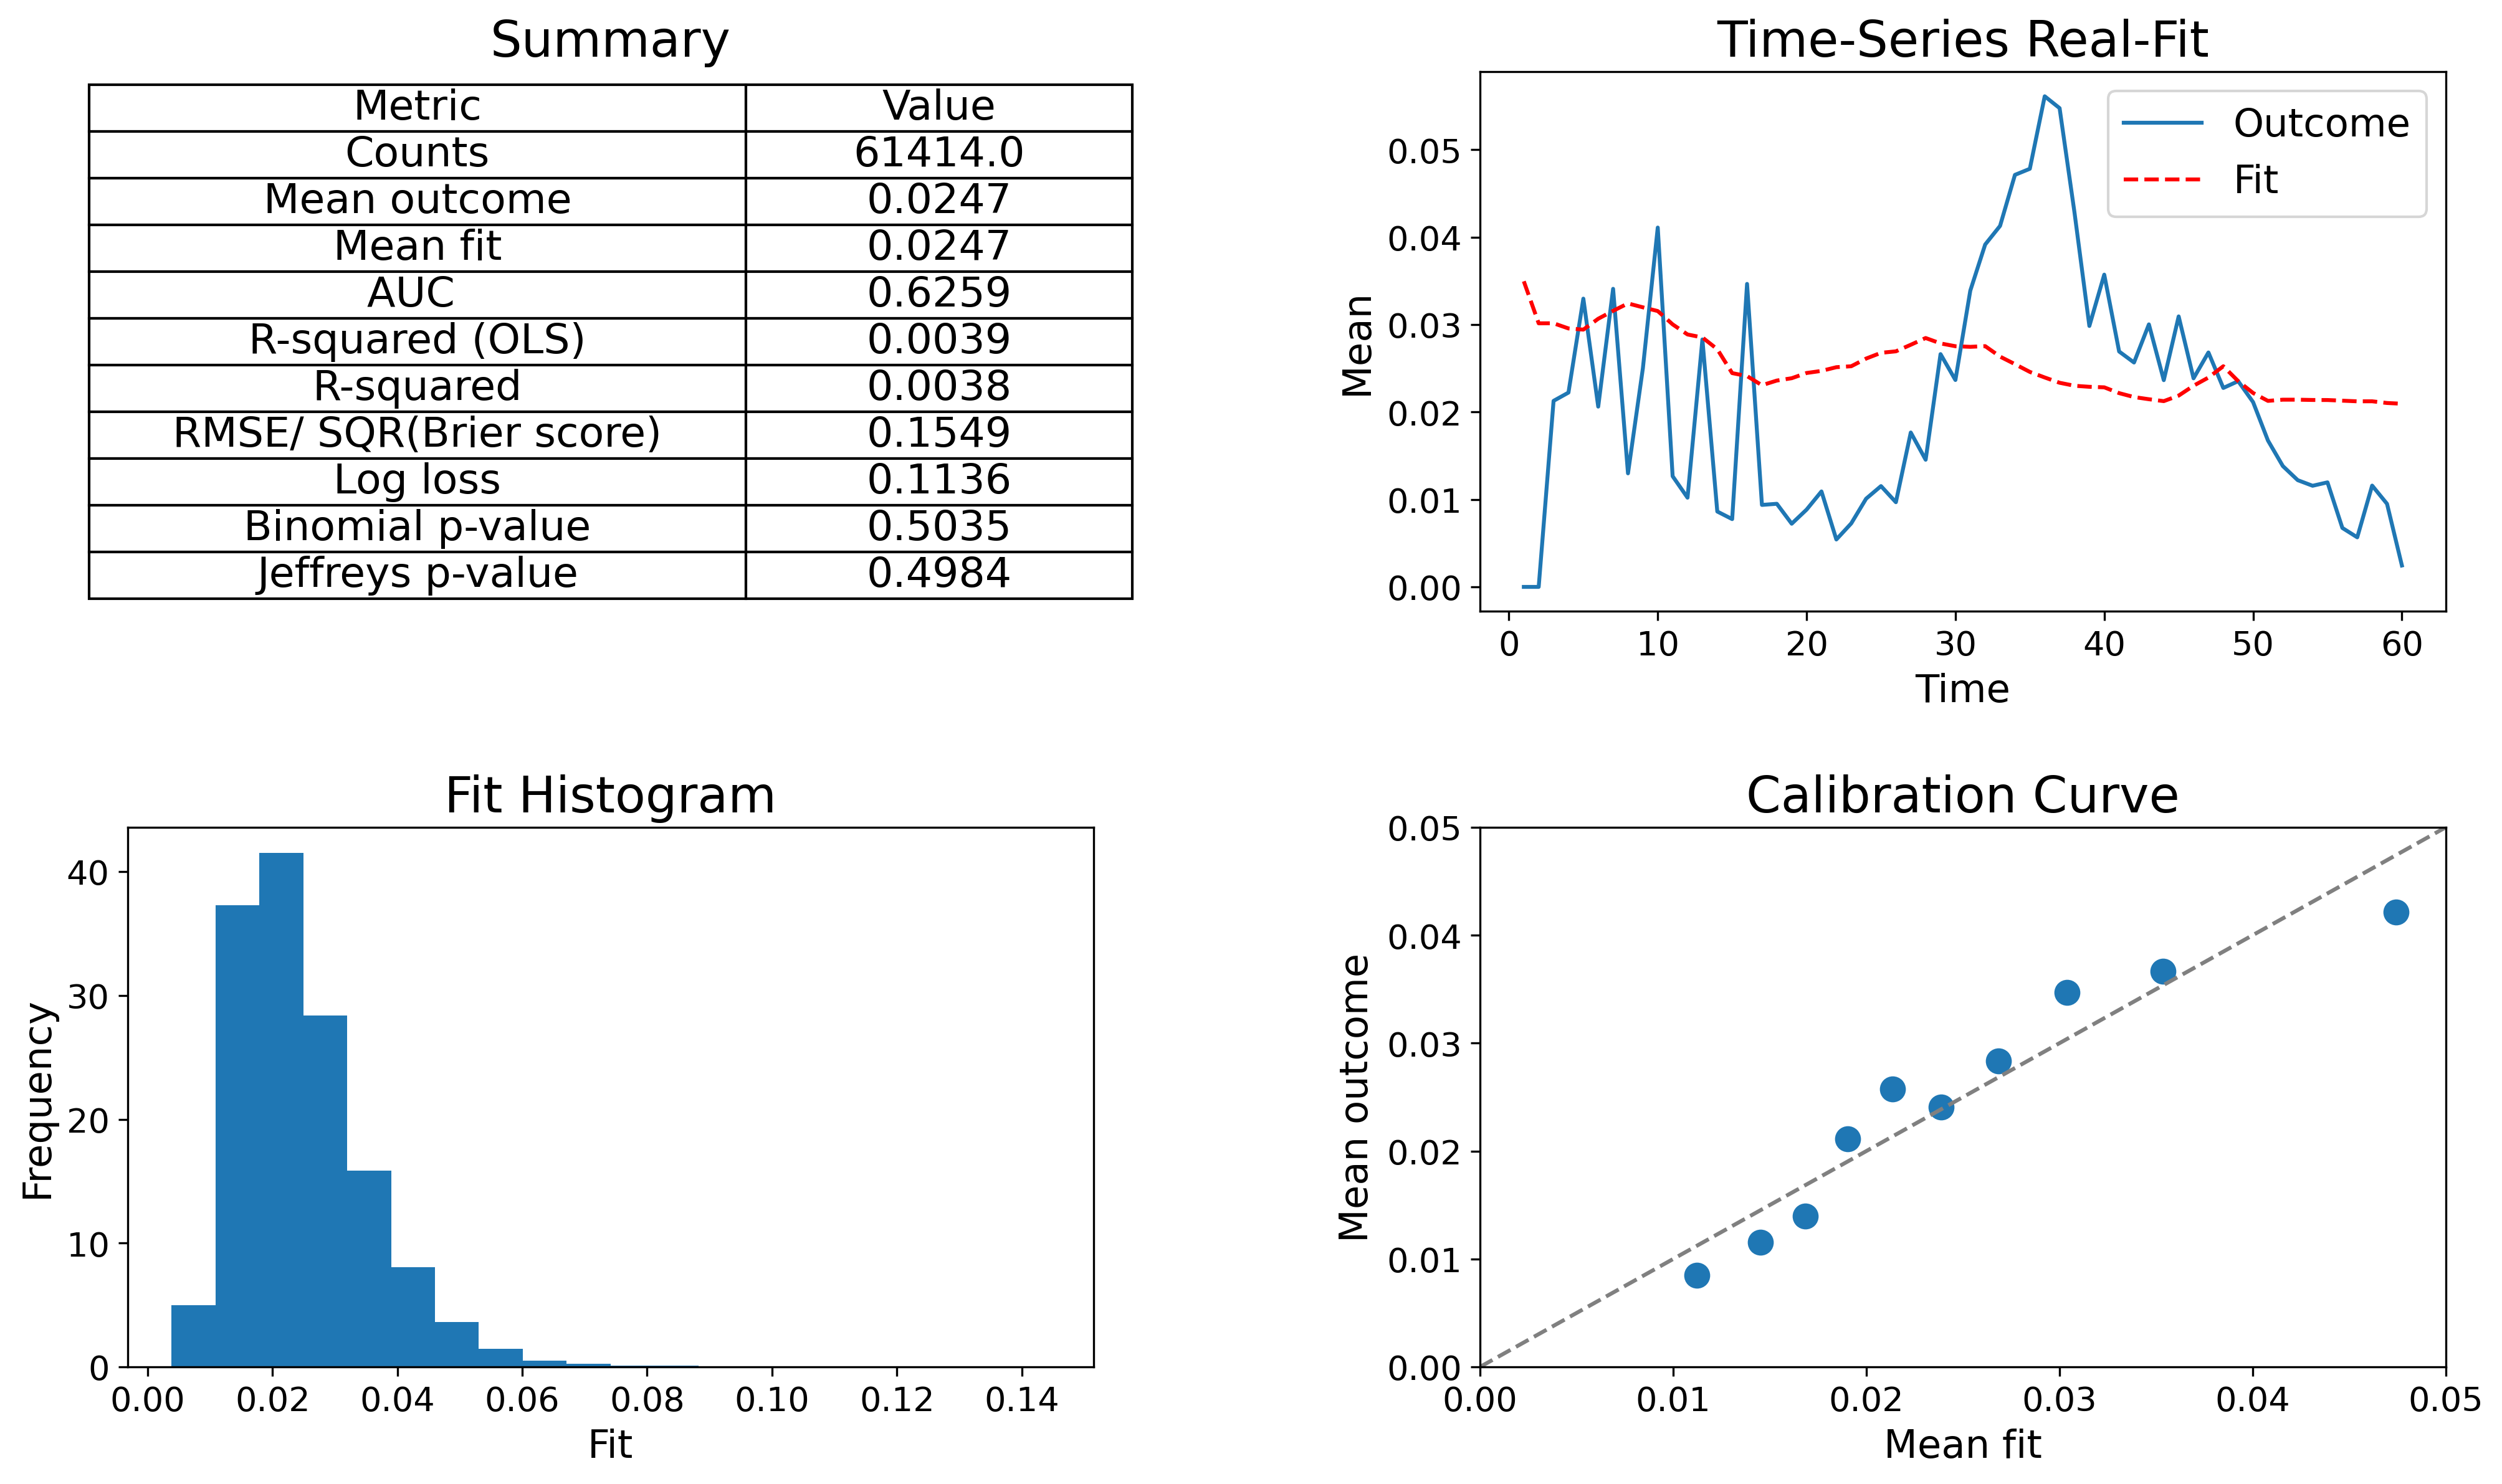

In [327]:
validation(merged_data_PD2.Logit_result2, merged_data_PD2.default_time, merged_data_PD2.time)

In [328]:
average_pd_by_time2 = merged_data_PD2.groupby('time')['Logit_result2'].mean()

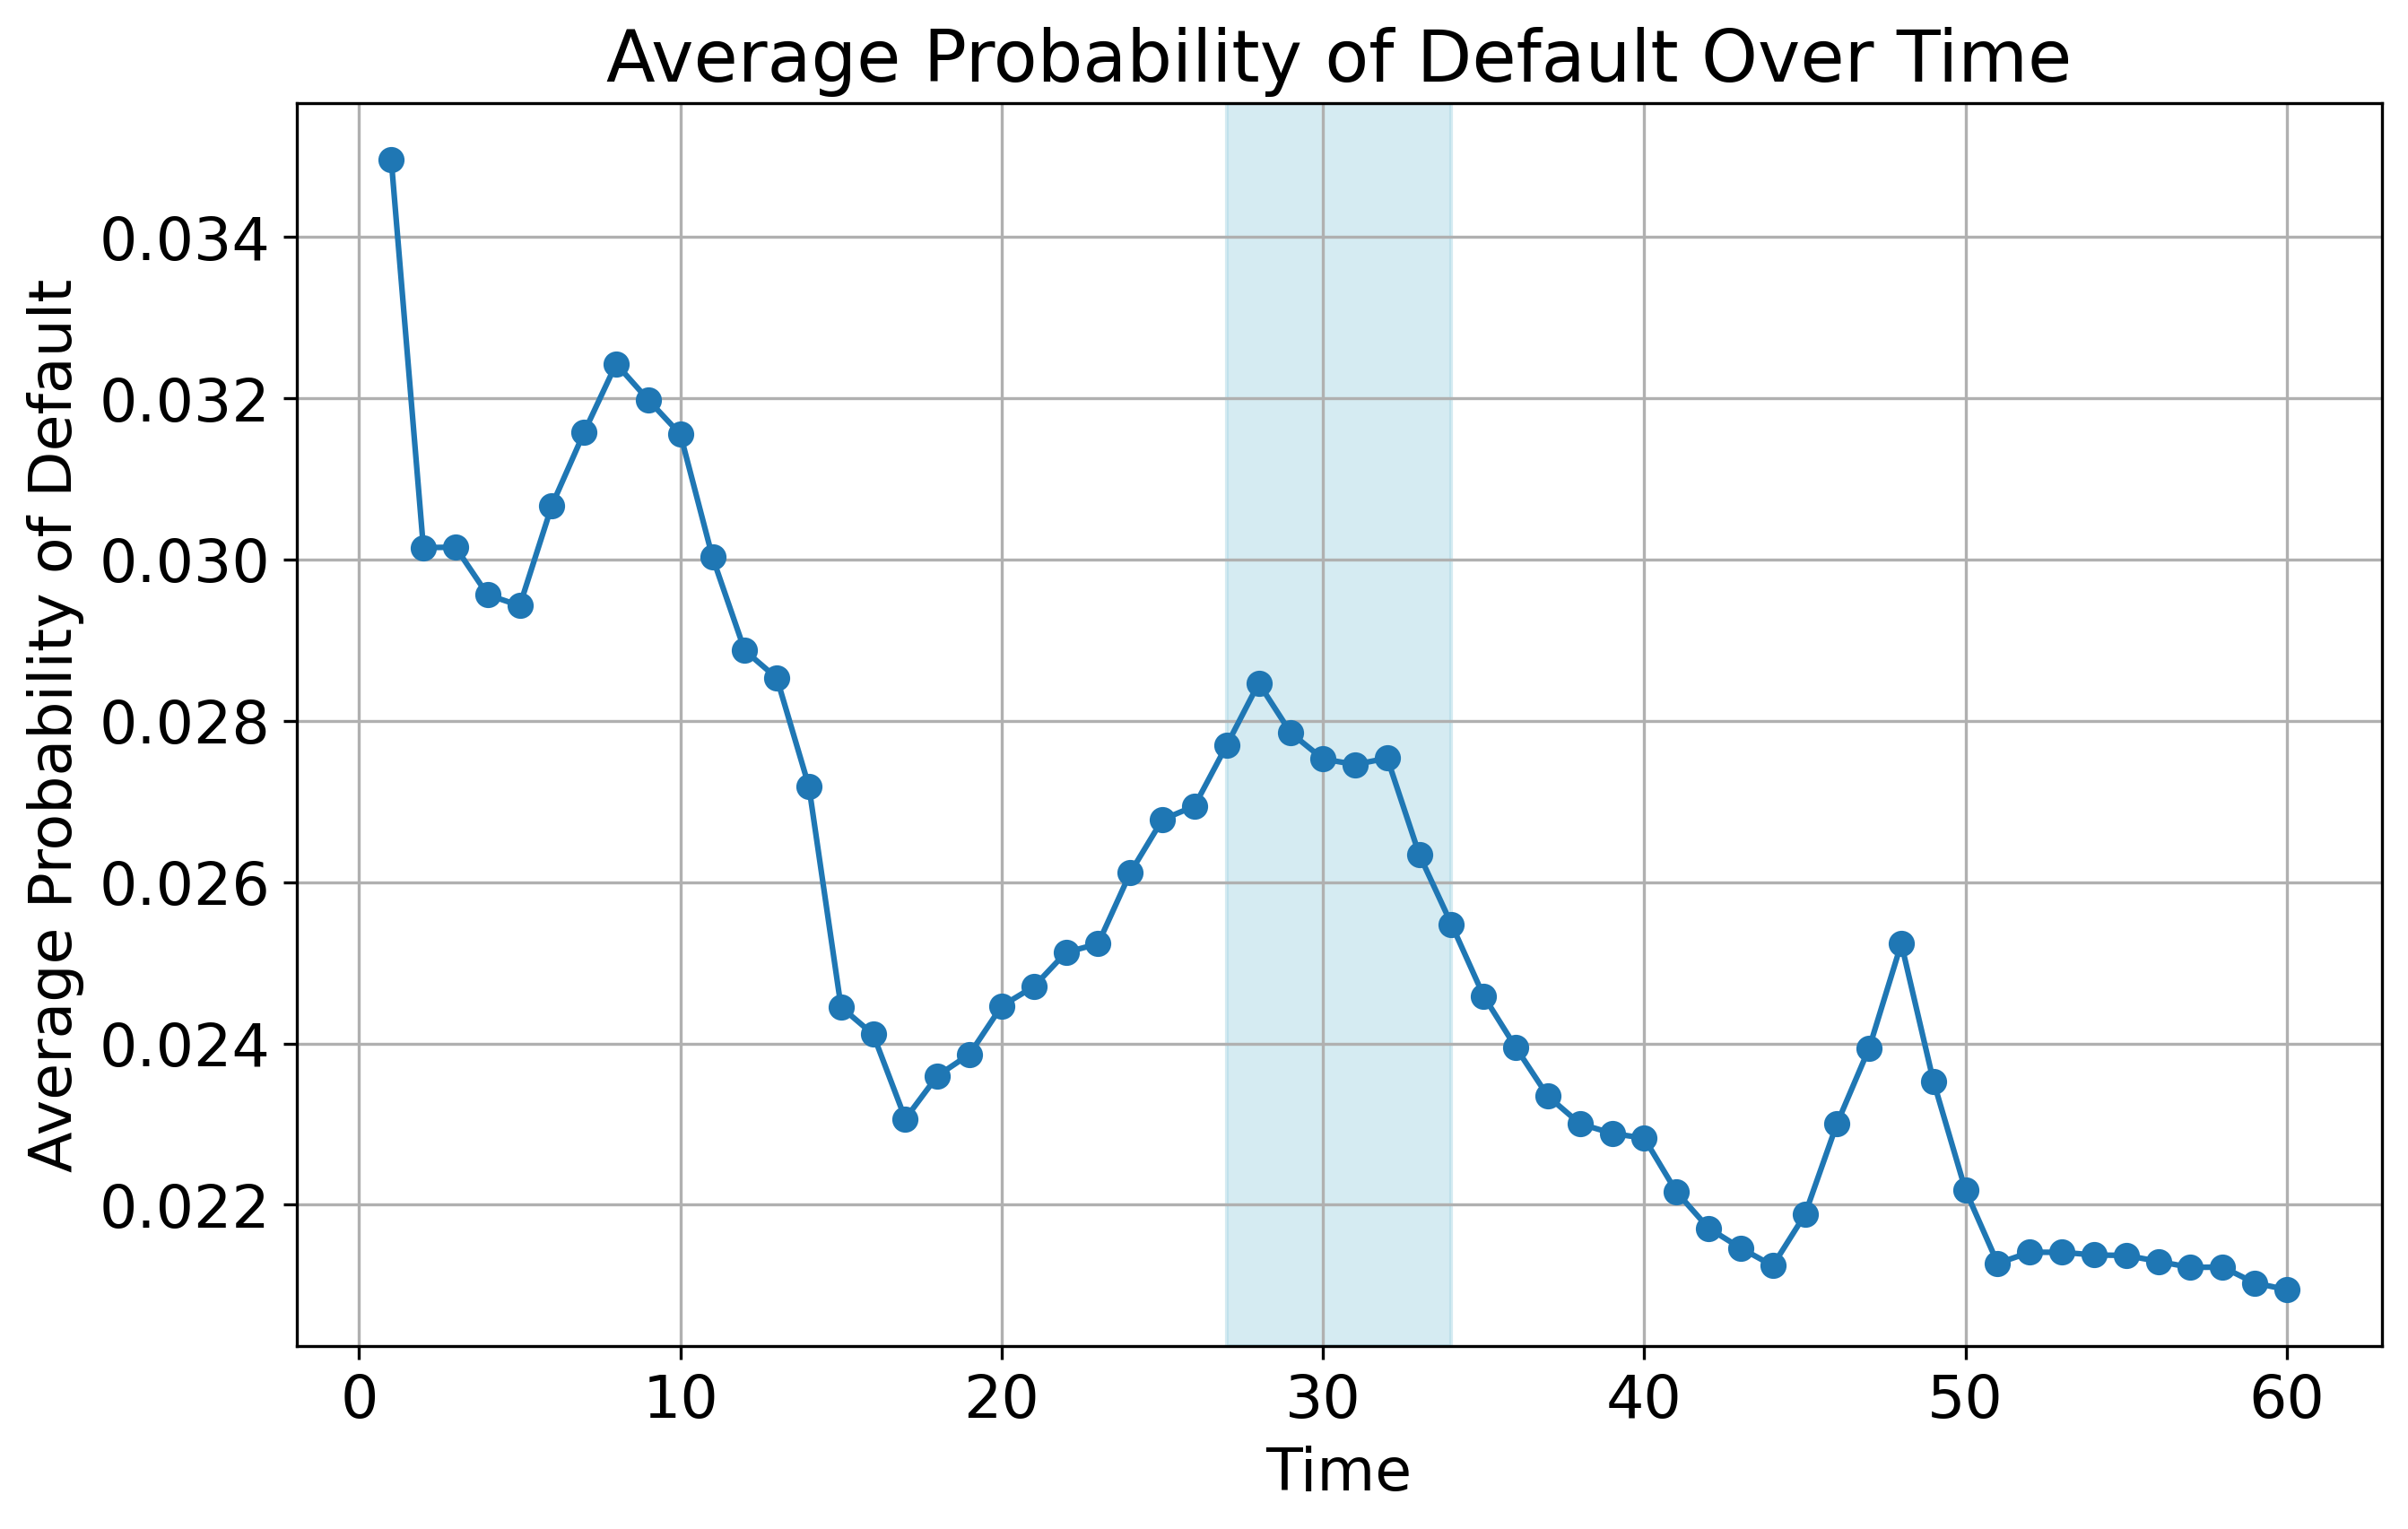

In [329]:
plt.figure(figsize=(10, 6))
plt.plot(average_pd_by_time2, marker='o', linestyle='-')
plt.axvspan(27, 34, color="lightblue", alpha=0.5)
plt.title('Average Probability of Default Over Time')
plt.xlabel('Time')
plt.ylabel('Average Probability of Default')
plt.grid(True)
plt.show()

After incorporating borrower incomes into our analysis, we achieved more than just an improved model fit; we also gained enhanced insights into the impact of the 2008 financial crisis, which spanned from period 27 to 34. During and around these periods, we observed a significant surge followed by a decline in defaults as the economy recovered. This dynamic was not evident in our previous models, which did not include borrower incomes as one of the explanatory variables. By adding this variable, we are now better equipped to visualize and understand the substantial fluctuations caused by the crisis, and any other economic factors.

### C) Comparing the accuracy of the two models 

Since we are comparing two PD models we will give AUC the most value and it will be the most significant factor for us in determining which model is more accurate. 

AUC (Area Under the Curve):
- Model 1: AUC = 0.6127
- Model 2: AUC = 0.6276
Model 2 i.e. the model with borrower income included in the explanatory variables has a higher AUC, indicating that it is generally better at distinguishing between default and non-default cases compared to Model 1. Apart for the fact that Model 2 generally performs better than Model 1 based on the higher AUC and better calibration. The marginal improvements in mean fit, RMSE, and log loss also support this conclusion. The analysis suggests that Model 2 might be more reliable for predicting default probabilities, although both models show room for improvement given their low R-squared values, but considering the nature of the data a low R-squared is justified as the dataset will always have low default rates.

## Problem 3 LGD Modelling

### A) OLS Regression Pridicting LGD

In [46]:
merged_data['lgd_time'].isnull().sum()

60653

Since, i noticed the amount of missing values are very large we can calculate LGD first as given in Lecture 8 so that we can perform the logistic regression model to our best efforts. 

In [47]:
data_default = merged_data.query('default_time==1').copy()
data_default2 =data_default[['lgd_time', 'LTV_time', 'FICO_orig_time', 'quarterly_growth_rate', 'time']].dropna()
data_default.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1525 entries, 47 to 62177
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1525 non-null   int64  
 1   time                     1525 non-null   int32  
 2   orig_time                1525 non-null   int64  
 3   first_time               1525 non-null   int64  
 4   mat_time                 1525 non-null   int64  
 5   res_time                 1160 non-null   float64
 6   balance_time             1525 non-null   float64
 7   LTV_time                 1525 non-null   float64
 8   interest_rate_time       1525 non-null   float64
 9   rate_time                1525 non-null   float64
 10  hpi_time                 1525 non-null   float64
 11  gdp_time                 1525 non-null   float64
 12  uer_time                 1525 non-null   float64
 13  REtype_CO_orig_time      1525 non-null   int64  
 14  REtype_PU_orig_time      15

In [48]:
model_ols = smf.ols(formula='lgd_time ~ LTV_time + FICO_orig_time + quarterly_growth_rate', data=data_default2).fit()

In [49]:
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lgd_time   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     15.90
Date:                Tue, 14 May 2024   Prob (F-statistic):           3.52e-10
Time:                        17:25:09   Log-Likelihood:                -665.40
No. Observations:                1516   AIC:                             1339.
Df Residuals:                    1512   BIC:                             1360.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.2509      0.096      2.603      0.009       0.062       0.440
LTV_time                  0.0027      0.000      5.630      0.000       0.002       0.004
FICO_orig_time        -6.622e-06      0.000     -0.044      0.965      -0.000       0.000
quarterly_growth_rate    -0.0109      0.003     -4.341      0.000      -0.016      -0.006
==============================================================================
Omnibus:                       41.334   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.300
Skew:                           0.419   Prob(JB):                     2.40e-10
Kurtosis:                       2.998   Cond. No.                     6.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [330]:
fittedvalues=pd.DataFrame(model_ols.fittedvalues, columns=['LGD_fit'])
data_default3=pd.merge(data_default2, fittedvalues, right_index=True, left_index=True)

In [331]:
data_default3

lgd_time    LTV_time  FICO_orig_time  quarterly_growth_rate  time  \
47     0.007838   99.138105             501               4.265688    37   
174    0.000000  101.403077             536               2.290357    37   
190    0.000000  102.571882             556              -0.604703    40   
232    0.000000   67.548782             622              -0.715937    31   
263    0.883919   87.176730             630              -2.391752    31   
...         ...         ...             ...                    ...   ...   
61639  0.000000   78.170651             648               5.021459    57   
61642  0.895569   57.774088             607              -4.642519    54   
61750  2.022767   53.126569             659               5.830082    52   
61941  0.000000   93.643138             606               5.272566    53   
62177  0.000000   90.874242             708               5.538079    56   

        LGD_fit  
47     0.465710  
174    0.493028  
190    0.527534  
232    0.434849  
263    0.505418  
...         ...  
61639  0.400557  
61642  0.451613  
61750  0.324851  
61941  0.439390  
62177  0.428435  

[1516 rows x 6 columns]

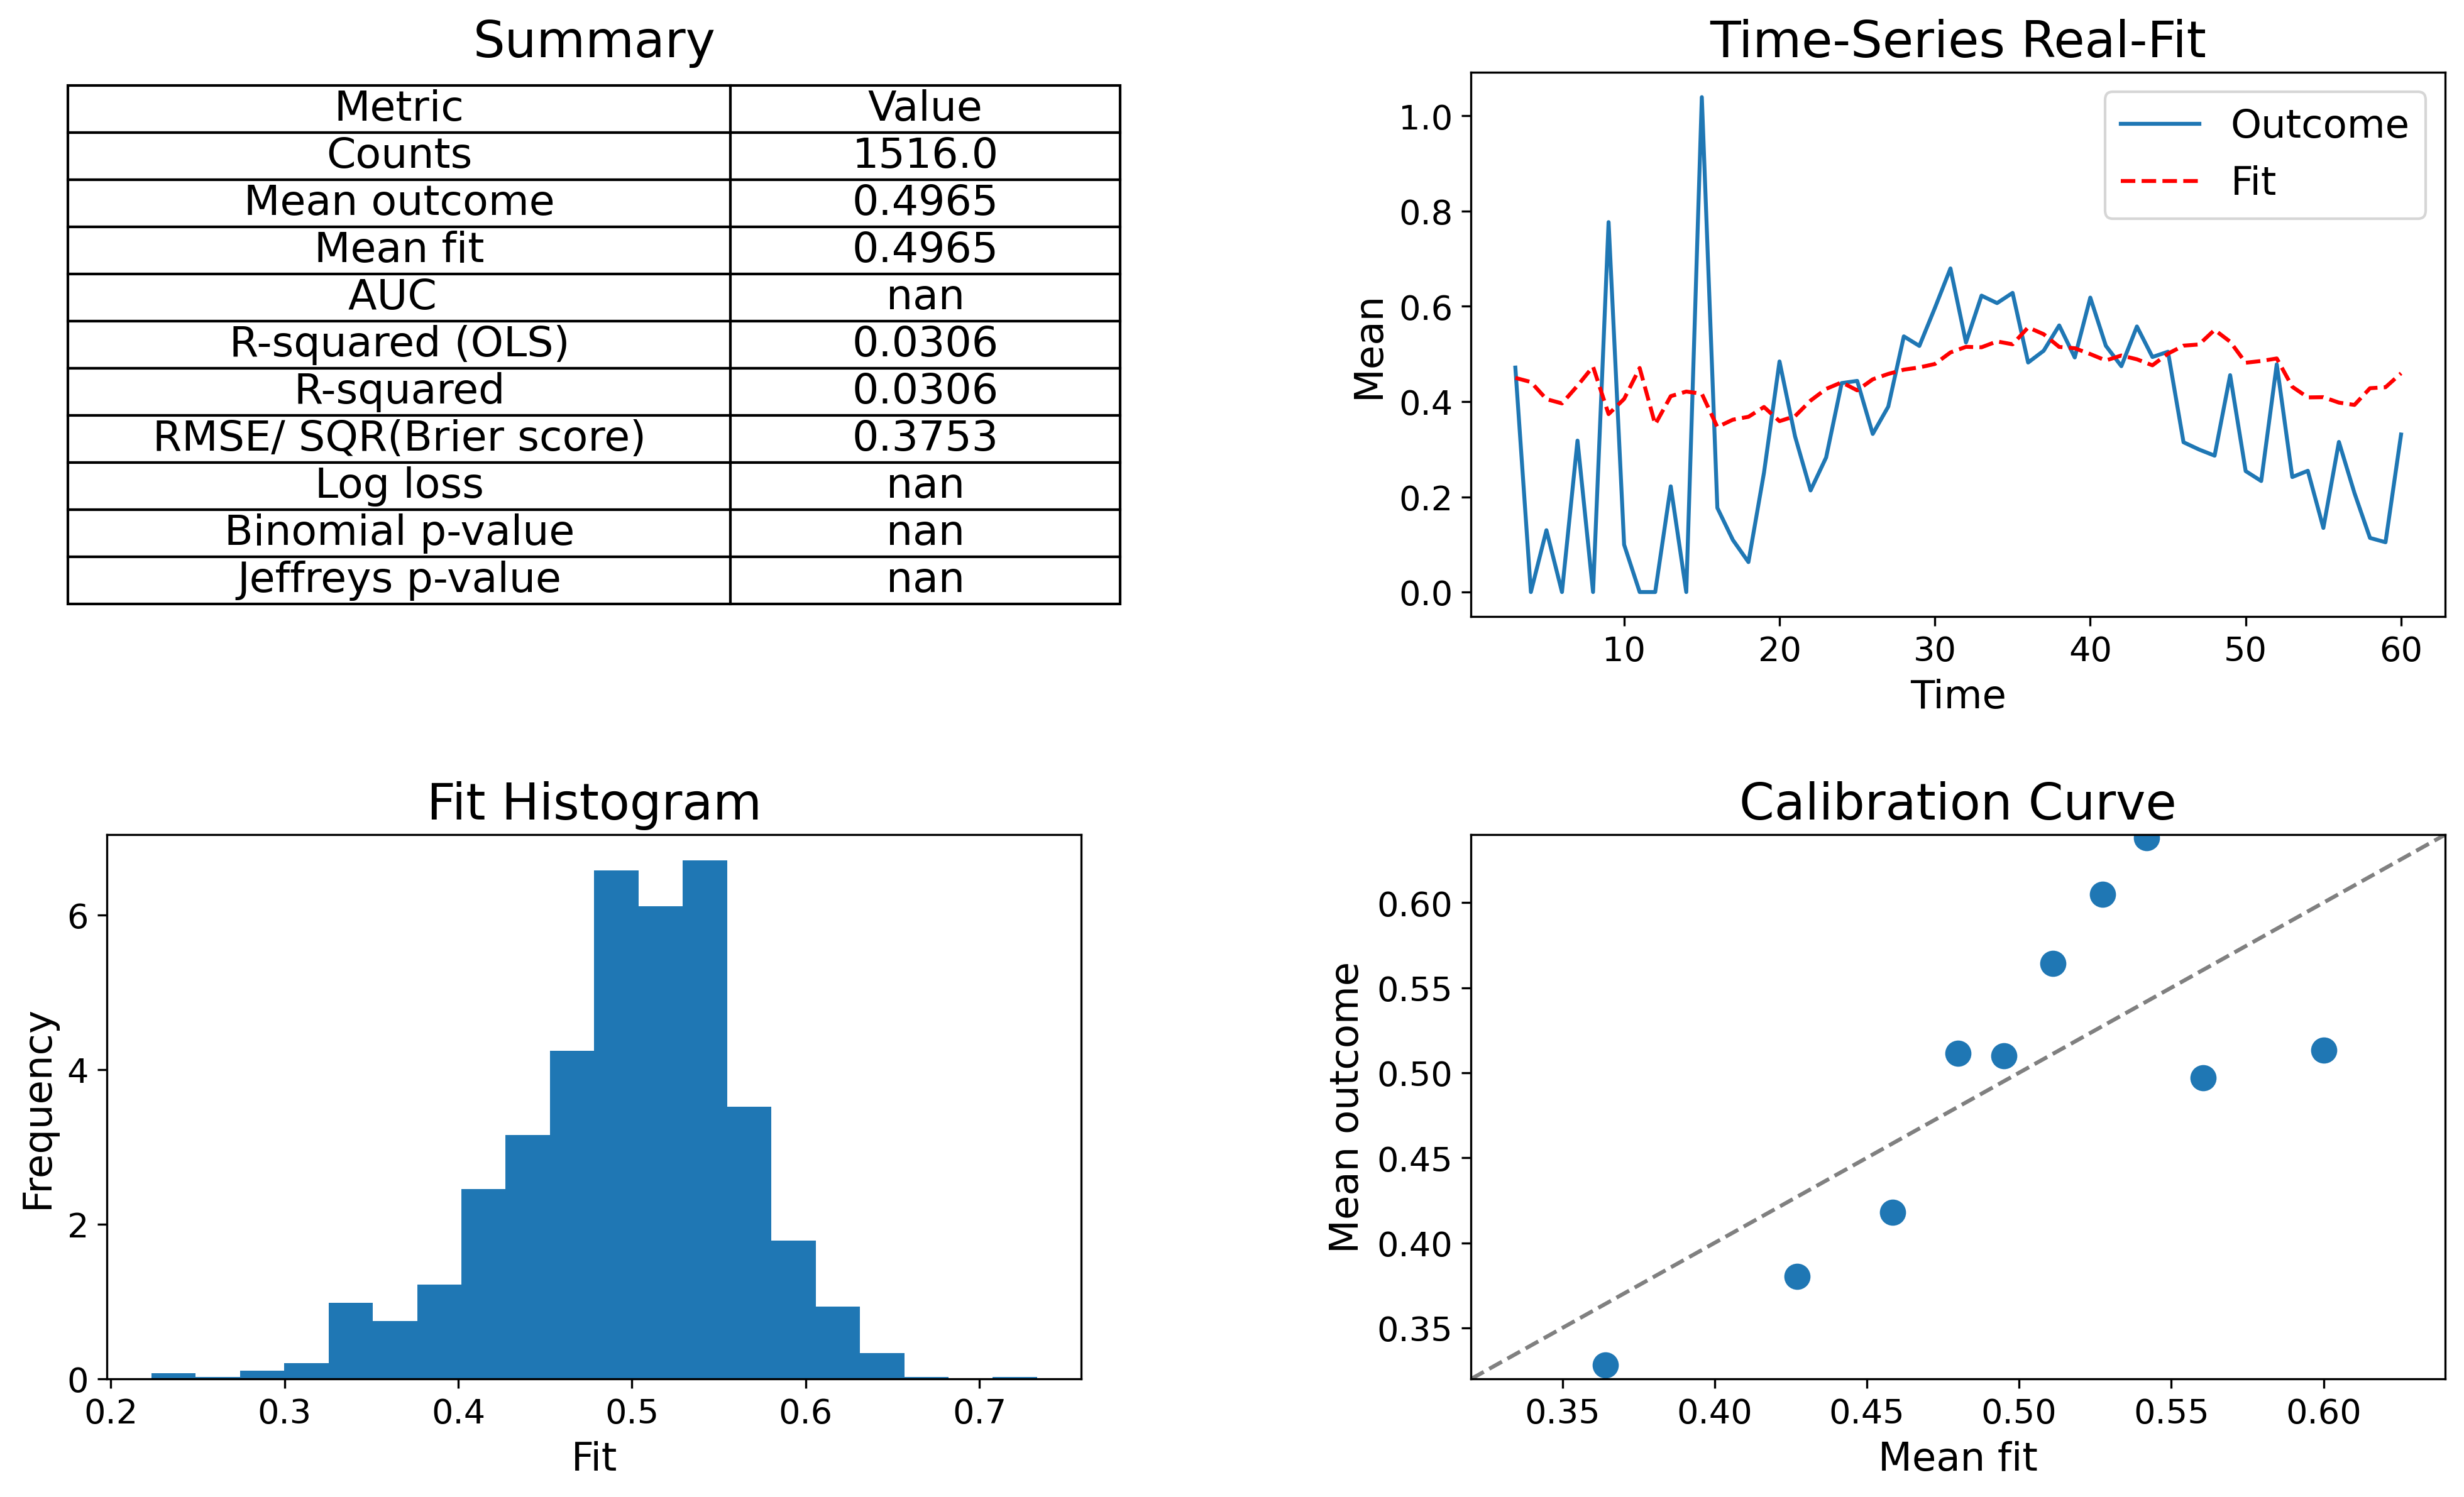

In [332]:
validation(data_default3.LGD_fit, data_default3.lgd_time, data_default3.time)

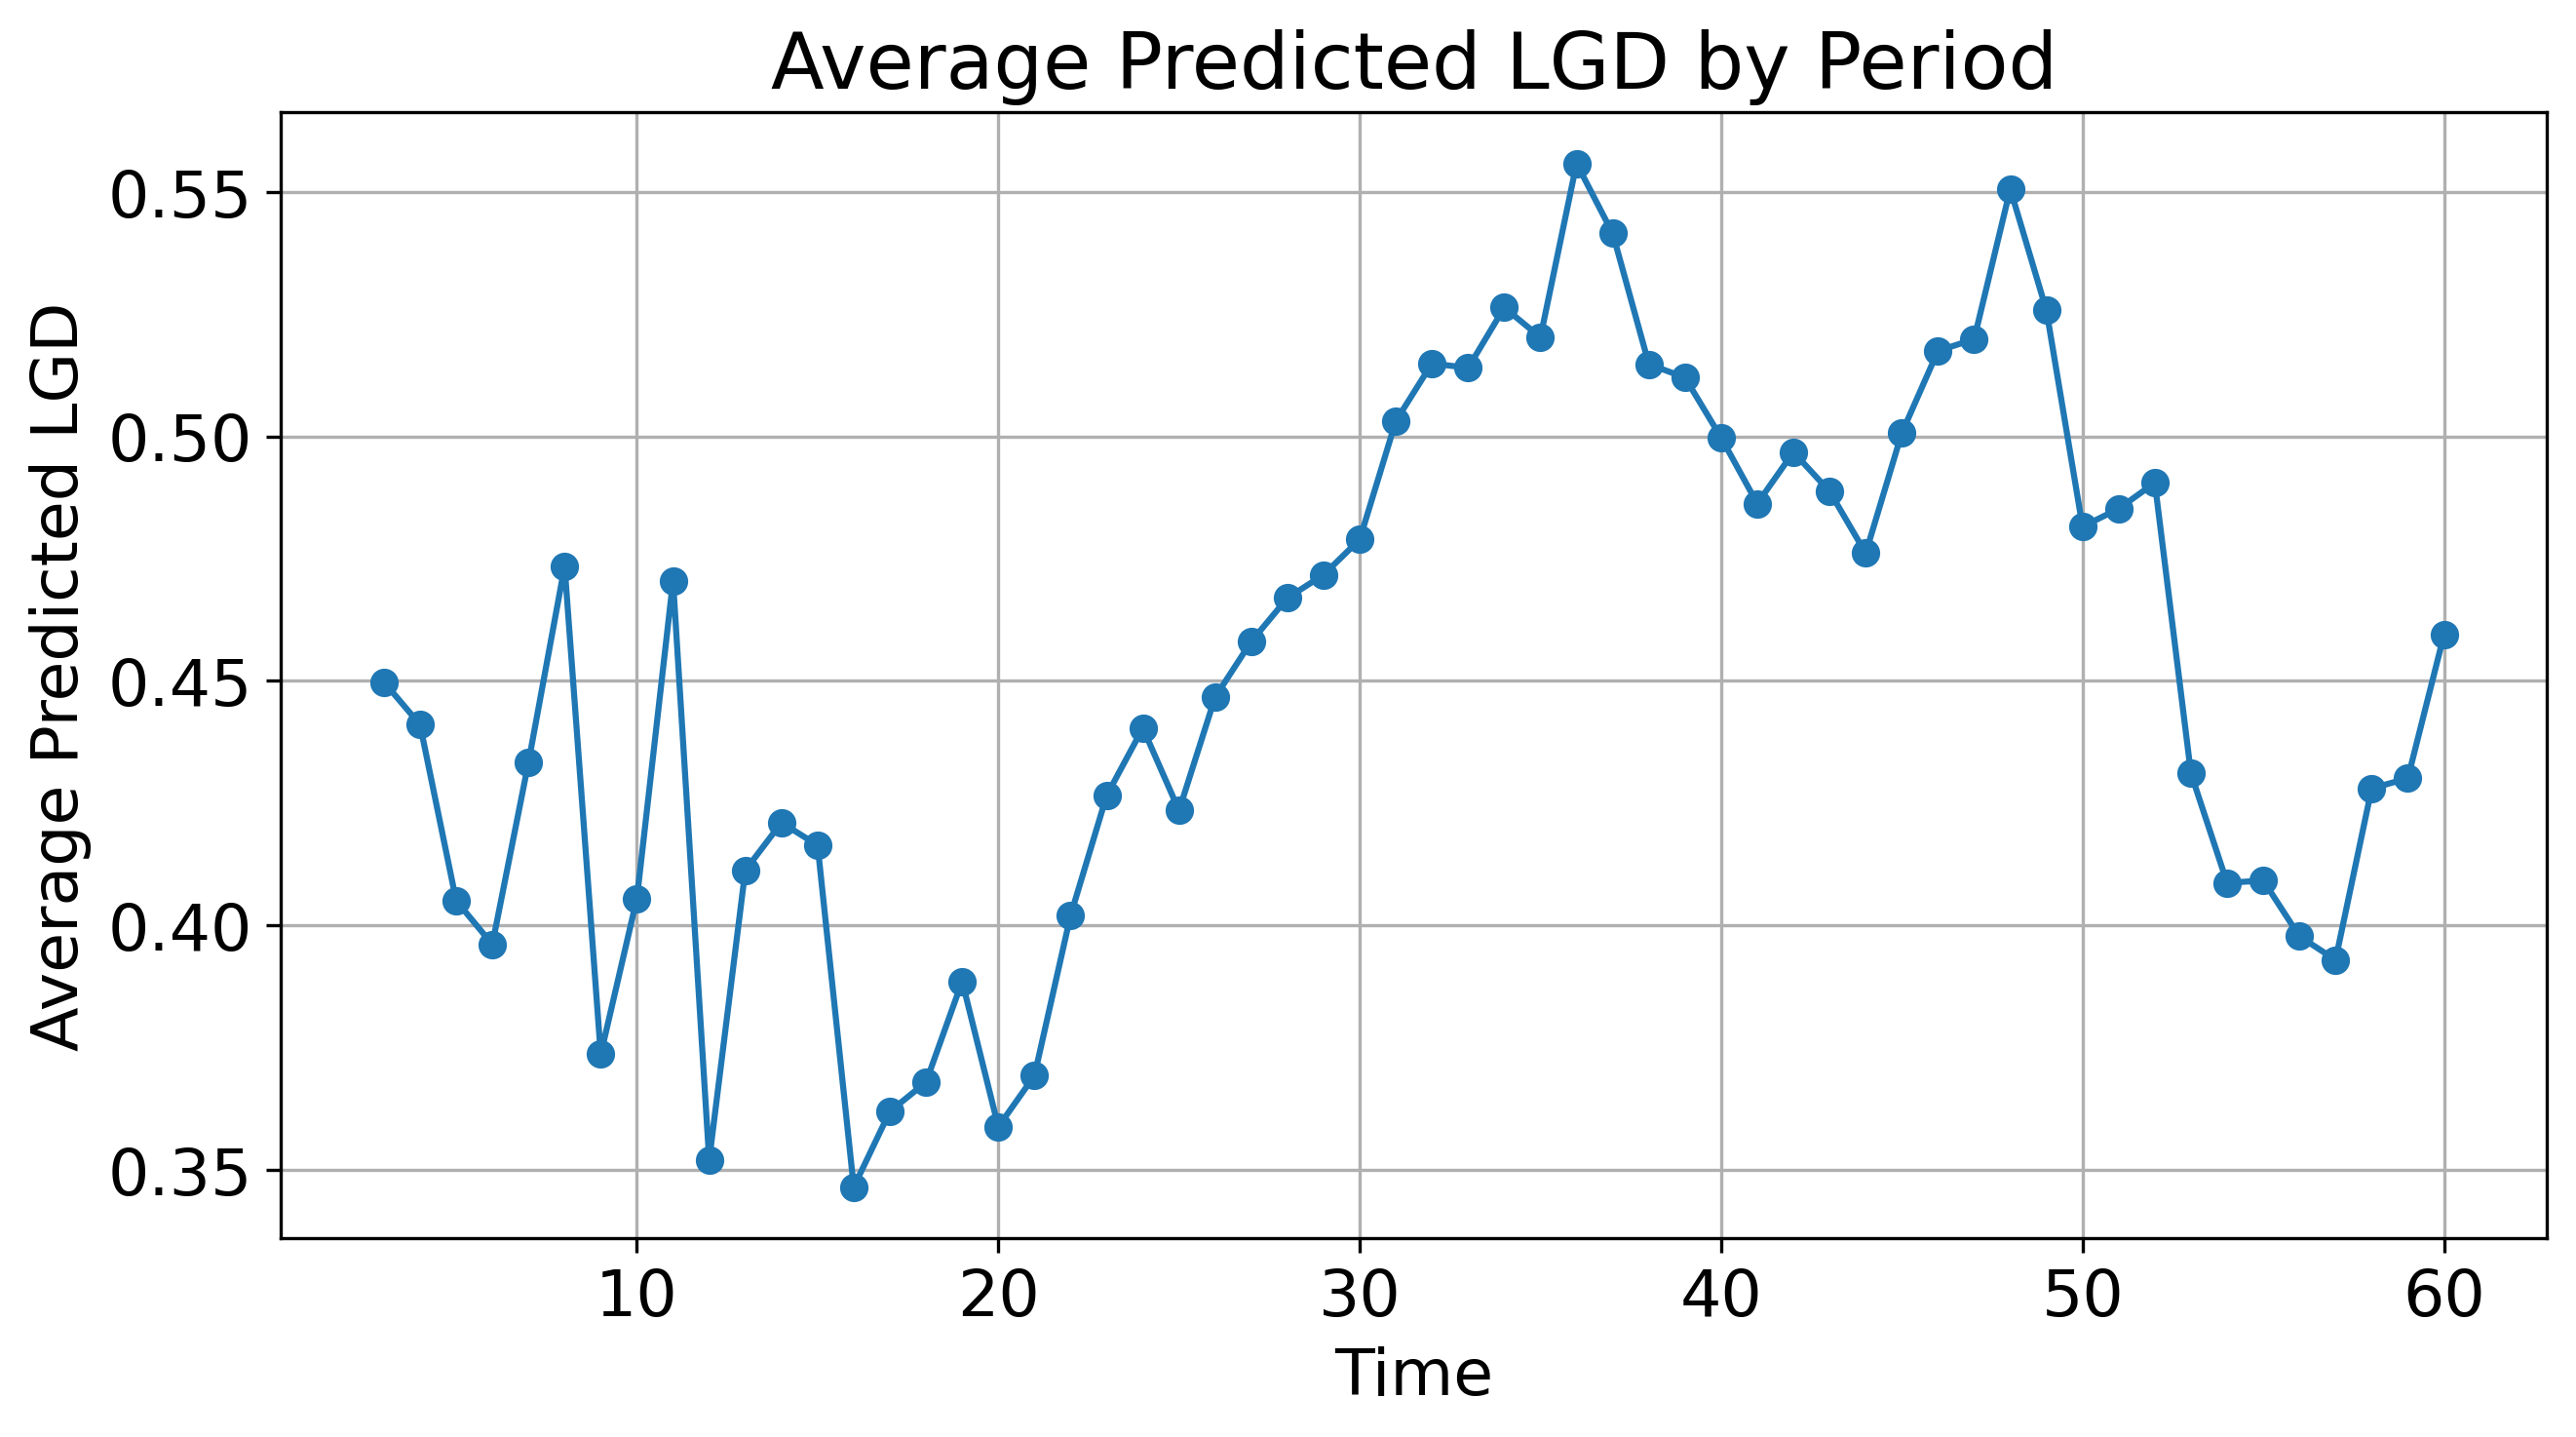

In [333]:
# Compute and plot average predicted LGD by period
avg_predicted_LGD = data_default3.groupby('time')['LGD_fit'].mean().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(avg_predicted_LGD['time'], avg_predicted_LGD['LGD_fit'], marker='o', linestyle='-')
plt.title('Average Predicted LGD by Period')
plt.xlabel('Time')
plt.ylabel('Average Predicted LGD')
plt.grid(True)
plt.show()

When we look at average predicted LGD against time we can see the impact that the 2008 financial crisis had on borrowers.
we can see in the graph that LGD starts its gradual ascend from earlier periods up to around period 34, peaking in this range. This period corresponds to the 2008 financial crisis timeline. The rise in LGD could be interpreted as increasing losses on defaults due to declining asset values (such as property prices), which were a significant feature of the 2008 financial crisis. As asset values decrease, the recovery on defaulted loans also decreases, leading to higher LGD.The peak in LGD around period 34 likely corresponds to the height of the financial crisis, where the maximum impact on borrowers' ability to repay and property values (or other collateral) was felt. During this time, economic downturns, higher unemployment rates, and plummeting real estate prices would exacerbate the losses lenders face when loans default.After the peak, there is a notable decline in LGD, suggesting an economic recovery phase. This could be due to stabilizing property prices, improvements in borrowers' financial conditions, and possibly effective regulatory and policy responses aimed at stabilizing the financial markets. As the economy recovers, asset values would begin to rise, reducing the severity of losses on defaulted loans.

### B) Explain how income may be a potential driver of LGD?

Income is crucial in determining LGD because it directly influences a borrower's ability to fulfill their debt obligations.But in scenarios where a borrower defaults it has hidden benefits:

- Higher Income: Borrowers with higher incomes are generally more likely to manage and restructure their outstanding debts even post-default.Also borrowers with high incomes will have assets which can be liquified, these abilities can lead to lower LGD as they might continue making partial payments or settle their debts more effectively through refinancing or selling assets voluntarily, thereby reducing the loss severity for the lender.

- Lower Income: Conversely, borrowers with lower incomes may struggle more significantly after defaulting, leading to higher LGDs. These borrowers might find it challenging to recover financially to meet their debt obligations, they do not have high value assests or the ability to refinance, thus increasing the likelihood that the recovered amount post-default will be lower.

Besides income, here are two additional features that can be significant in explaining mortgage LGD:
- **Unemployment Rate at Observation Time (uer_time)**

  Rationale: The unemployment rate (uer_time) is a direct indicator of economic conditions that can affect a borrower’s     ability to meet their debt obligations. Higher unemployment rates typically correlate with higher default rates as         individuals lose their income sources.During periods of high unemployment, defaulted borrowers may find it more difficult to secure new employment and thus fail to continue mortgage payments or resolve defaults effectively. Conversely, in a low unemployment scenario, borrowers are more likely to find or maintain employment, ensuring a steadier income stream.
  
- **House Price Index at Observation Time (hpi_time)**

  Rationale: The House Price Index (hpi_time) reflects the relative changes in housing market prices, which directly         impact the recovery value of the collateral (property) tied to the mortgage.An increase in the house price index suggests that property values are rising, which could mitigate LGD. In cases of default, the property serving as collateral might be sold for a higher value.Conversely, if the HPI is falling, the collateral value is likely decreasing, which would increase LGD.

To provide numbers for my rational i will now do the OLS regression again but with added explanatory variables uer_time and hpi_time

In [54]:
data_default = merged_data.query('default_time==1').copy()
data_default4 =data_default[['lgd_time', 'LTV_time', 'FICO_orig_time', 'quarterly_growth_rate','uer_time','hpi_time', 'time']].dropna()
data_default4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1516 entries, 47 to 62177
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lgd_time               1516 non-null   float64
 1   LTV_time               1516 non-null   float64
 2   FICO_orig_time         1516 non-null   int64  
 3   quarterly_growth_rate  1516 non-null   float64
 4   uer_time               1516 non-null   float64
 5   hpi_time               1516 non-null   float64
 6   time                   1516 non-null   int32  
dtypes: float64(5), int32(1), int64(1)
memory usage: 88.8 KB


In [55]:
model_ols2 = smf.ols(formula='lgd_time ~ LTV_time + FICO_orig_time + quarterly_growth_rate + uer_time + hpi_time', data=data_default4).fit()
model_ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lgd_time   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     13.46
Date:                Tue, 14 May 2024   Prob (F-statistic):           7.21e-13
Time:                        17:25:10   Log-Likelihood:                -655.88
No. Observations:                1516   AIC:                             1324.
Df Residuals:                    1510   BIC:                             1356.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0963      0.191     -0.503      0.615      -0.472       0.279
LTV_time                  0.0041      0.001      7.135      0.000       0.003       0.005
FICO_orig_time         7.106e-05      0.000      0.469      0.639      -0.000       0.000
quarterly_growth_rate    -0.0068      0.003     -2.518      0.012      -0.012      -0.002
uer_time                 -0.0125      0.008     -1.494      0.135      -0.029       0.004
hpi_time                  0.0014      0.001      2.109      0.035    9.54e-05       0.003
==============================================================================
Omnibus:                       52.072   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.616
Skew:                           0.462   Prob(JB):                     5.08e-13
Kurtosis:                       3.209   Cond. No.                     1.36e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
fittedvalues=pd.DataFrame(model_ols.fittedvalues, columns=['LGD_fit2'])
data_default4=pd.merge(data_default4, fittedvalues, right_index=True, left_index=True)

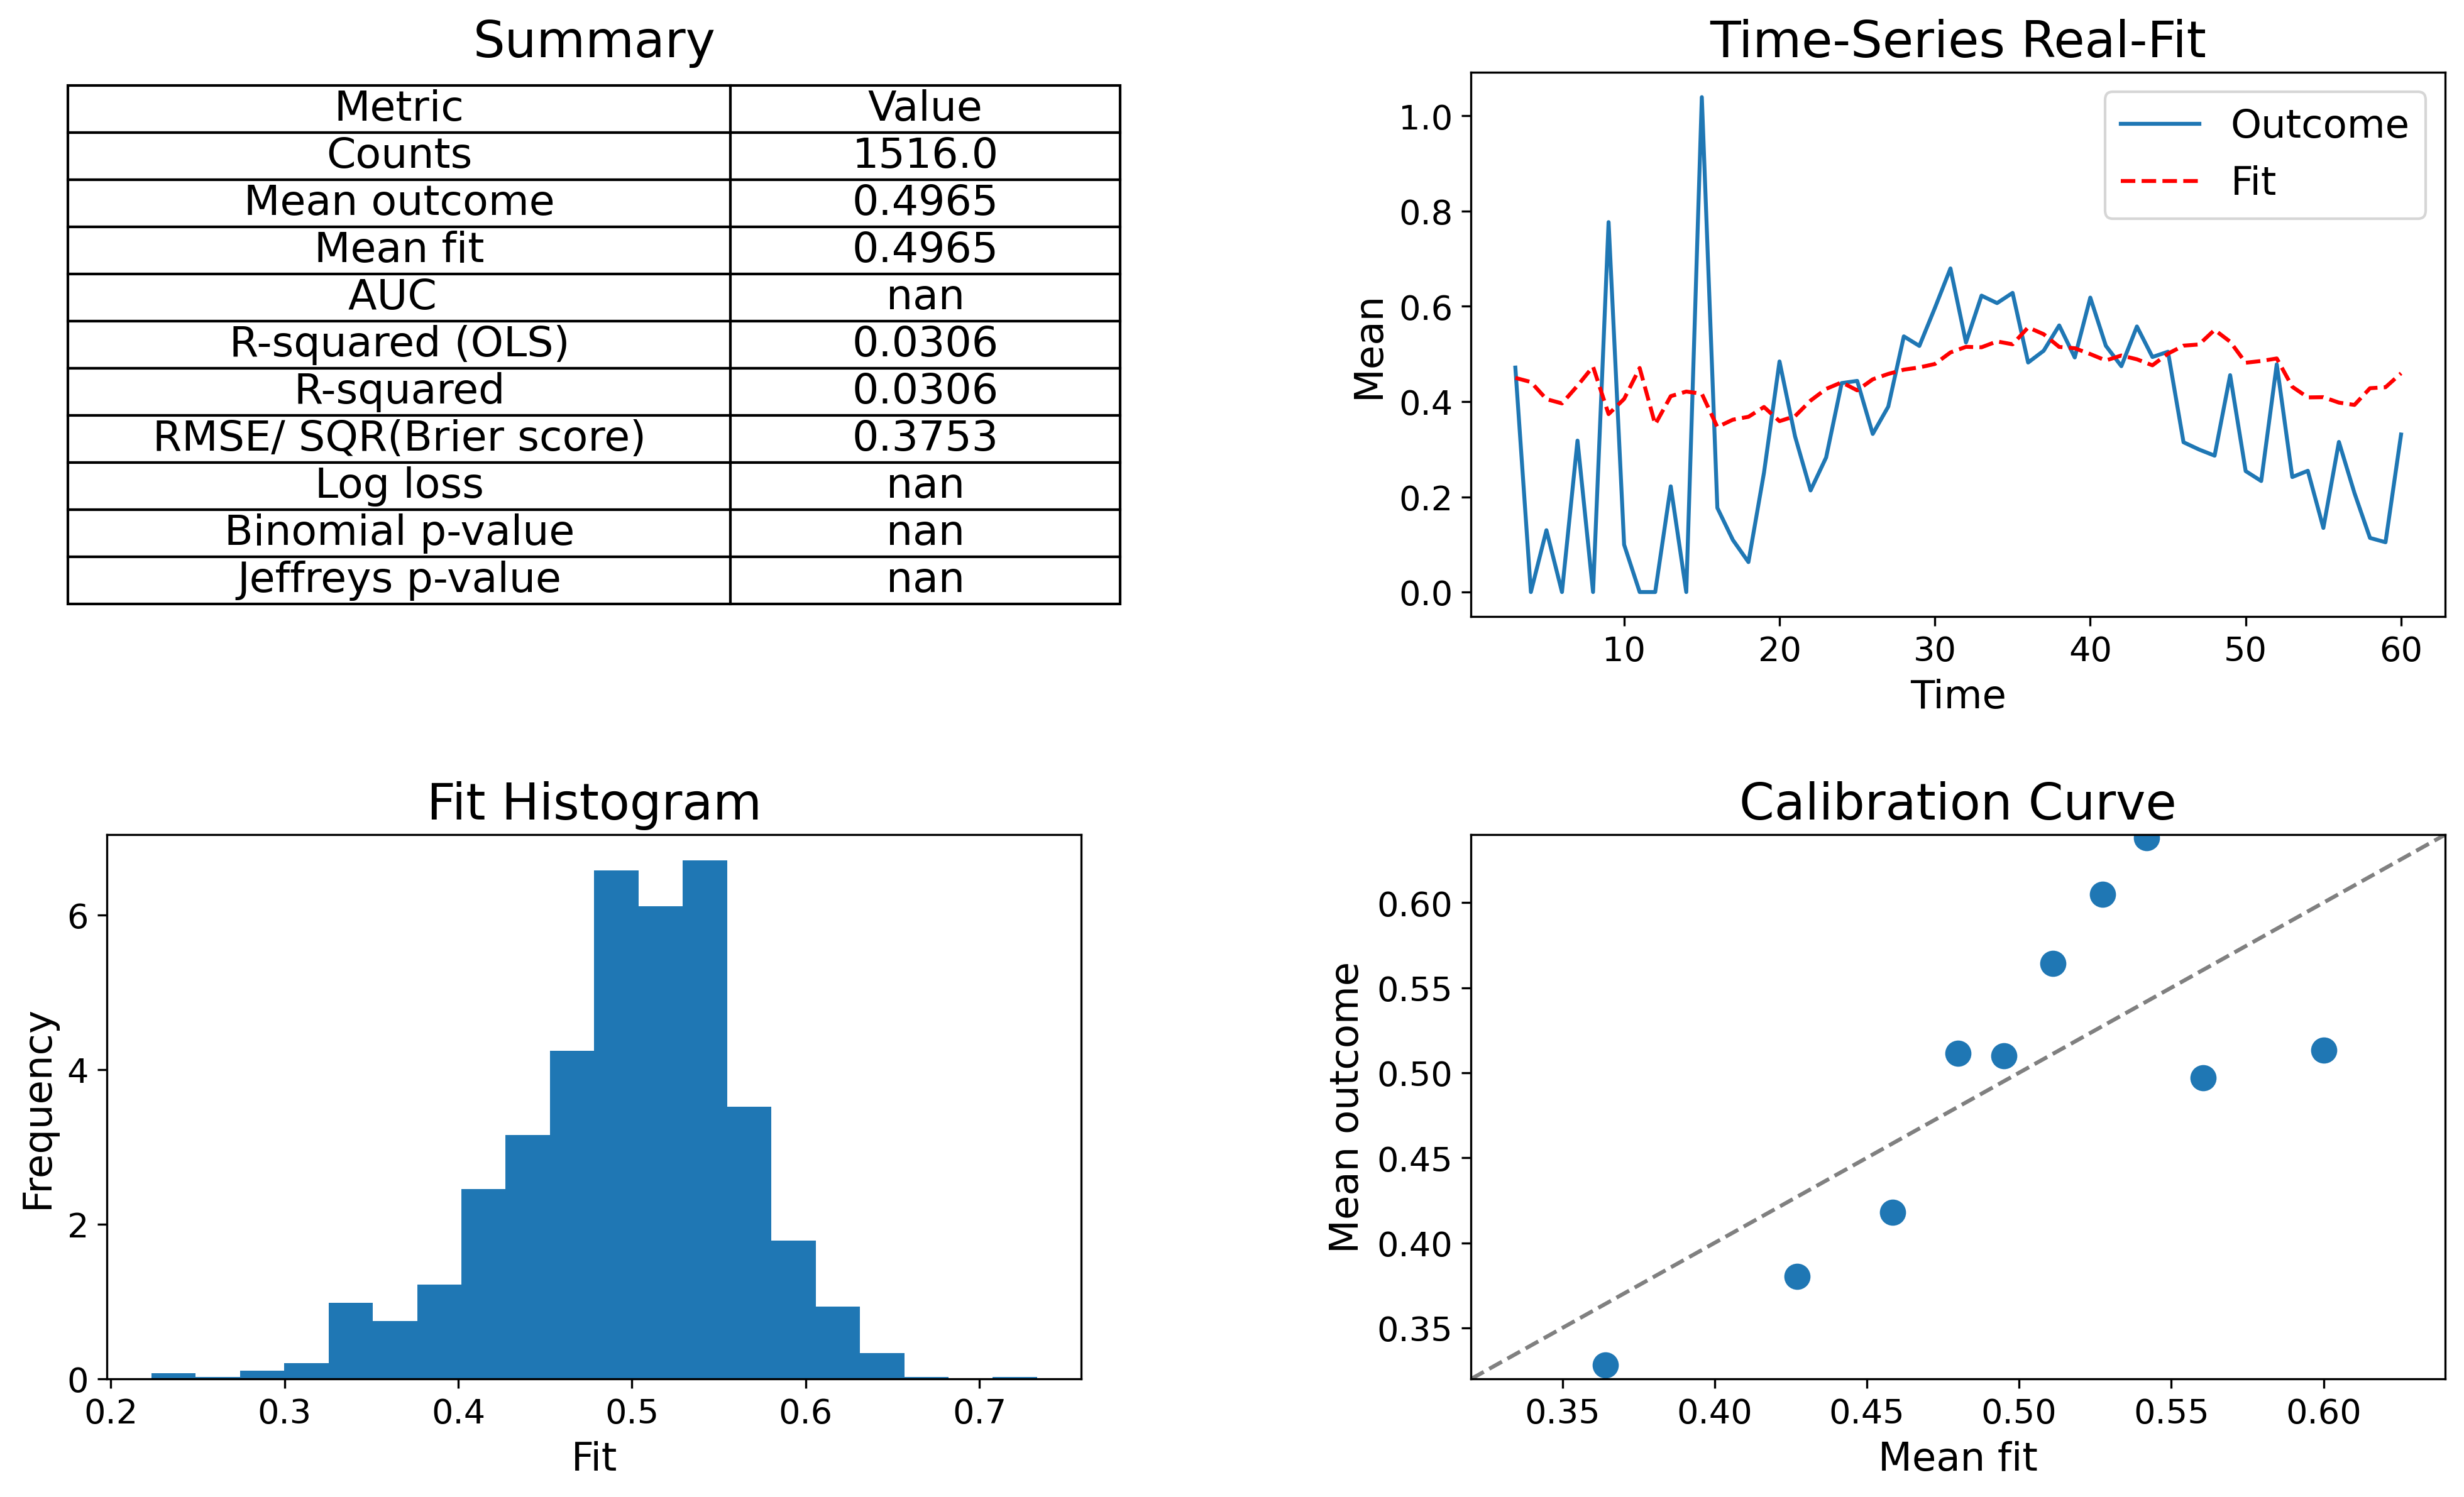

In [57]:
validation(data_default4.LGD_fit2, data_default4.lgd_time, data_default4.time)

Now to compare these two LGD models we will look at their R square values
Both are identical so even though this might have been a good idea in theory but in practice is redundant and income growth in itself explains the variation. 

## Problem 4: Generative AI

### A) Credit Scoring with the help of Gen AI 

One additional area where generative artificial intelligence can significantly impact the credit risk prediction process is through **generative credit scoring**. Although not directly connected to the risk prediction process itself, the credit ratings resulting from this innovative approach can enhance the prediction accuracy. By generating synthetic data or simulating financial histories, AI can create credit profiles for individuals without extensive financial backgrounds, thereby enriching the data points available for AI-based credit scoring systems. This approach is distinct from traditional methods as it specifically addresses financial inclusion, leveraging AI's ability to analyze and synthesize diverse data sources to estimate creditworthiness where substantial historical data does not exist.

AI credit scoring represents a contemporary method for assessing a borrower’s likelihood to repay loans. Unlike traditional methods that depend heavily on static variables and historical data, AI credit scoring utilizes machine learning algorithms to analyze a vast array of data sources, including unconventional ones. This technique provides a fuller, more dynamic evaluation of credit risk, offering lenders a more detailed and accurate insight into a borrower’s financial behavior.

In terms of distinctions from other AI applications, the differences are nuanced:

- <u> Data Augmentation:</u> Unlike generative credit scoring, data augmentation in AI applications generally serves to enrich existing datasets without directly influencing credit decisions. It compensates for limited or imbalanced data, which is crucial in training robust AI models, therefore it aids other applications of AI.

- <u>Feature Generation:</u> While generative credit scoring often incorporates and relies on generated data to construct new credit profiles, feature generation in broader AI applications serves to unearth previously unrecognized predictive indicators within vast datasets. This process is not restricted to credit scoring alone but applies to various predictive modeling tasks where discovering subtle patterns can significantly enhance model accuracy.

- <u>Anomaly and Fraud Detection:</u> While generative credit scoring focuses on evaluating creditworthiness, anomaly and fraud detection use AI to safeguard against atypical patterns and fraudulent activities, ensuring the integrity of the credit process.

- <u>Model Interpretation:</u> Model interpretation in AI credit scoring systems specifically focuses on demystifying the decision-making processes of complex credit models, making them understandable and justifiable to stakeholders. This is critical in credit scoring where regulatory compliance and fairness are paramount. Unlike generative credit scoring, which directly influences how credit profiles are created and scored, model interpretation works to make the outcomes of these models transparent and explainable, ensuring that the models can be audited and trusted by users and regulators alike.

- <u>Scenario Analysis:</u> Scenario analysis uses generative AI to project the future financial states under varying economic conditions, helping lenders assess potential risks and opportunities in different market scenarios. This differs from generative credit scoring as it does not directly contribute to the generation of credit scores but rather evaluates the resilience of existing scores under hypothetical conditions. This capability is crucial for strategic planning and risk management, allowing financial institutions to prepare for and mitigate potential impacts on their portfolios.

### B) Generate scenarios

<i>**Measure = Final Borrower Income - Initial Borrower Income**</i>

- Data Collection: For generating the required scenarios a major issue was data collection. but as a solution to the lack of information about bank lending behaviour online, i will utilize historical mean income data from the United States which i was able to aquire from the world bank data sources , and i will be using this data as proxy for calculating the borrower income growth rate, as for our use case i will combine this with historical growth rates provided from 2002 to 2015. and since whats more important is to see the macroeconomical impact of our genearted scenarios i beilive this method is appropriate if not accurate.
- Scenario Development: Now that we have borrower income growth rates from 2002 to 2022 we can create  detailed scenarios that project future income growth rates based on past trends. These scenarios cover high growth, moderate growth, and low growth/stagnation conditions, spanning a decade from 2023 to 2033.
- Macroeconomic Consideration: Each scenario was developed considering different global economic factors such as technological advancement, government policies, global trade dynamics, and potential economic downturns.

Detailed Future Scenarios for U.S. Income Growth

**1. Optimistic Scenario (High Growth)**

2023-2025: Inspired by growth trends seen in 2005 and 2015, an economic boom driven by technological innovation and strong global trade, with growth rates of about 5% annually.
2026-2028: Sustained high growth due to efficient government policies and a stable geopolitical climate, averaging around 4% annually.
2029-2033: A slight deceleration in growth as the market adjusts to newer economic norms but still maintaining robust growth at about 3.5% annually.

**2. Base Scenario (Moderate Growth)**

2023-2025: Steady economic recovery post-pandemic, following the average growth patterns observed in the early 2000s and 2010s, with growth rates of about 2% annually.
2026-2028: Continued moderate growth driven by incremental advances in technology and stable consumer spending, with growth rates maintaining at about 2%.
2029-2033: Gradual slowing to a growth rate of 1.5% as potential economic challenges surface, similar to the slower growth years following the 2008 financial crisis.

**3. Pessimistic Scenario (Low Growth/Stagnation)**

2023-2025: Minimal growth due to lingering economic uncertainties, weak global demand, or possible new economic crises, with growth rates hovering around 0.5%.
2026-2028: Stagnation continues with minimal recovery, influenced by geopolitical tensions or fiscal policy errors, with growth rates around 1%.
2029-2033: A challenging economic period with potential for mild recessions, mirroring the negative growth rates seen in 2009-2010, with flat or slightly negative growth.

### Problem 5: Stress testing 

### A) Calculate the change of PDs for ONE particular scenario in 4B

For our stress testing we will be taking the optimistic scenario, theoretically we have some idea what what might happen. Since this is a scenario where the macro-economic are favourable we expect the PD to decrease and people with lower FICO scores finding it comparitively easier to be able to acquire loans.

In [142]:
# Create a function to map 'time' values and create new column 'time_year'

def time_to_year(time):
    return 2001 + (time - 1) // 4

merged_data.loc[:,'time_year'] = merged_data['time'].apply(time_to_year)

In [202]:
merged_data

id  time  orig_time  first_time  mat_time  res_time  balance_time  \
0          4    25         -2          25       119       NaN      61031.10   
1          4    26         -2          25       119       NaN      60882.42   
2          4    27         -2          25       119       NaN      60729.80   
3          4    28         -2          25       119       NaN      60576.14   
4          4    29         -2          25       119       NaN      60424.39   
...      ...   ...        ...         ...       ...       ...           ...   
62173  49972    52         25          52       145       NaN     180673.24   
62174  49972    53         25          52       145       NaN     179944.95   
62175  49972    54         25          52       145       NaN     179451.81   
62176  49972    55         25          52       145       NaN     178952.48   
62177  49972    56         25          52       145       NaN     178952.48   

         LTV_time  interest_rate_time  rate_time  ...  hpi_orig_time  \
0       33.911009              10.500       5.90  ...          97.99   
1       34.007232              10.500       5.90  ...          97.99   
2       34.335349              10.500       5.90  ...          97.99   
3       34.672545              10.875       5.90  ...          97.99   
4       34.951639              10.875       5.90  ...          97.99   
...           ...                 ...        ...  ...            ...   
62173  103.306966               7.500       5.15  ...         226.29   
62174   95.736862               7.500       5.15  ...         226.29   
62175   91.867079               7.500       5.15  ...         226.29   
62176   91.560581               7.500       5.15  ...         226.29   
62177   90.874242               7.500       5.15  ...         226.29   

       default_time  payoff_time  status_time  lgd_time  recovery_res  \
0                 0            0            0       NaN           NaN   
1                 0            0            0       NaN           NaN   
2                 0            0            0       NaN           NaN   
3                 0            0            0       NaN           NaN   
4                 0            0            0       NaN           NaN   
...             ...          ...          ...       ...           ...   
62173             0            0            0       NaN           NaN   
62174             0            0            0       NaN           NaN   
62175             0            0            0       NaN           NaN   
62176             0            0            0       NaN           NaN   
62177             1            0            1       0.0     178952.48   

       state_full_name  quarterly_growth_rate  time_year  adjusted_growth_rate  
0             Kentucky               4.117327       2007              9.117327  
1             Kentucky               3.925402       2007              8.925402  
2             Kentucky               3.797452       2007              8.797452  
3             Kentucky               3.669502       2007              8.669502  
4             Kentucky               1.471605       2008              6.471605  
...                ...                    ...        ...                   ...  
62173          Alabama               5.274361       2013              8.774361  
62174          Alabama               5.313919       2014              8.813919  
62175          Alabama               5.366663       2014              8.866663  
62176          Alabama               5.432592       2014              8.932592  
62177          Alabama               5.538079       2014              9.038079  

[62178 rows x 32 columns]

In [172]:
def adjust_growth(row):
    if 2000 <= row['time_year'] <= 2009:
        return row['quarterly_growth_rate'] + 5
    elif 2010 <= row['time_year'] <= 2011:
        return row['quarterly_growth_rate'] + 4
    elif 2012 <= row['time_year'] <= 2015:
        return row['quarterly_growth_rate'] + 3.5
    else:
        return row['quarterly_growth_rate']

In [173]:
merged_data['adjusted_growth_rate'] = merged_data.apply(adjust_growth, axis=1)

In [174]:
merged_data.adjusted_growth_rate

0        9.117327
1        8.925402
2        8.797452
3        8.669502
4        6.471605
           ...   
62173    8.774361
62174    8.813919
62175    8.866663
62176    8.932592
62177    9.038079
Name: adjusted_growth_rate, Length: 62178, dtype: float64

In [272]:
data_stress = merged_data[['default_time', 'time', 'FICO_orig_time', 'LTV_orig_time', 'adjusted_growth_rate']].dropna()

In [273]:
data_stress['FICO_orig_time_original'] = data_stress['FICO_orig_time']

In [274]:
scaler = StandardScaler()
data_stress[['FICO_orig_time', 'LTV_orig_time', 'adjusted_growth_rate']] = scaler.fit_transform(data_stress[['FICO_orig_time', 'LTV_orig_time', 'adjusted_growth_rate']])

In [302]:
data_stress

default_time  time  FICO_orig_time  LTV_orig_time  \
0                 0    25       -1.205210       0.303500   
1                 0    26       -1.205210       0.303500   
2                 0    27       -1.205210       0.303500   
3                 0    28       -1.205210       0.303500   
4                 0    29       -1.205210       0.303500   
...             ...   ...             ...            ...   
62173             0    52        0.480053       0.108096   
62174             0    53        0.480053       0.108096   
62175             0    54        0.480053       0.108096   
62176             0    55        0.480053       0.108096   
62177             1    56        0.480053       0.108096   

       adjusted_growth_rate  FICO_orig_time_original  
0                  0.821100                      587  
1                  0.769762                      587  
2                  0.735536                      587  
3                  0.701310                      587  
4                  0.113385                      587  
...                     ...                      ...  
62173              0.729359                      708  
62174              0.739940                      708  
62175              0.754049                      708  
62176              0.771685                      708  
62177              0.799902                      708  

[61414 rows x 6 columns]

In [240]:
formula = 'default_time ~ FICO_orig_time + LTV_orig_time + adjusted_growth_rate'

Logit_result3 = smf.glm(formula=formula, data=data_stress, family=sm.families.Binomial()).fit()

Logit_result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           default_time   No. Observations:                61414
Model:                            GLM   Df Residuals:                    61410
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6974.3
Date:                Tue, 14 May 2024   Deviance:                       13949.
Time:                        20:45:35   Pearson chi2:                 6.04e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.004368
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.7627      0.028   -133.871      0.000      -3.818      -3.708
FICO_orig_time          -0.3154      0.026    -12.223      0.000      -0.366      -0.265
LTV_orig_time            0.1963      0.027      7.344      0.000       0.144       0.249
adjusted_growth_rate    -0.1712      0.026     -6.619      0.000      -0.222      -0.121
========================================================================================
"""

In [269]:
Logit_result_stress = pd.DataFrame(Logit_result3.predict(data_stress), columns=['Logit_result3'])
Logit_result_stress

Logit_result3
0           0.030367
1           0.030627
2           0.030801
3           0.030977
4           0.034145
...              ...
62173       0.017676
62174       0.017644
62175       0.017602
62176       0.017550
62177       0.017467

[61414 rows x 1 columns]

In [303]:
data_stress_logit = pd.merge(data_stress, Logit_result_stress, right_index=True, left_index=True)

In [304]:
data_stress_logit

default_time  time  FICO_orig_time  LTV_orig_time  \
0                 0    25       -1.205210       0.303500   
1                 0    26       -1.205210       0.303500   
2                 0    27       -1.205210       0.303500   
3                 0    28       -1.205210       0.303500   
4                 0    29       -1.205210       0.303500   
...             ...   ...             ...            ...   
62173             0    52        0.480053       0.108096   
62174             0    53        0.480053       0.108096   
62175             0    54        0.480053       0.108096   
62176             0    55        0.480053       0.108096   
62177             1    56        0.480053       0.108096   

       adjusted_growth_rate  FICO_orig_time_original  Logit_result3  
0                  0.821100                      587       0.030367  
1                  0.769762                      587       0.030627  
2                  0.735536                      587       0.030801  
3                  0.701310                      587       0.030977  
4                  0.113385                      587       0.034145  
...                     ...                      ...            ...  
62173              0.729359                      708       0.017676  
62174              0.739940                      708       0.017644  
62175              0.754049                      708       0.017602  
62176              0.771685                      708       0.017550  
62177              0.799902                      708       0.017467  

[61414 rows x 7 columns]

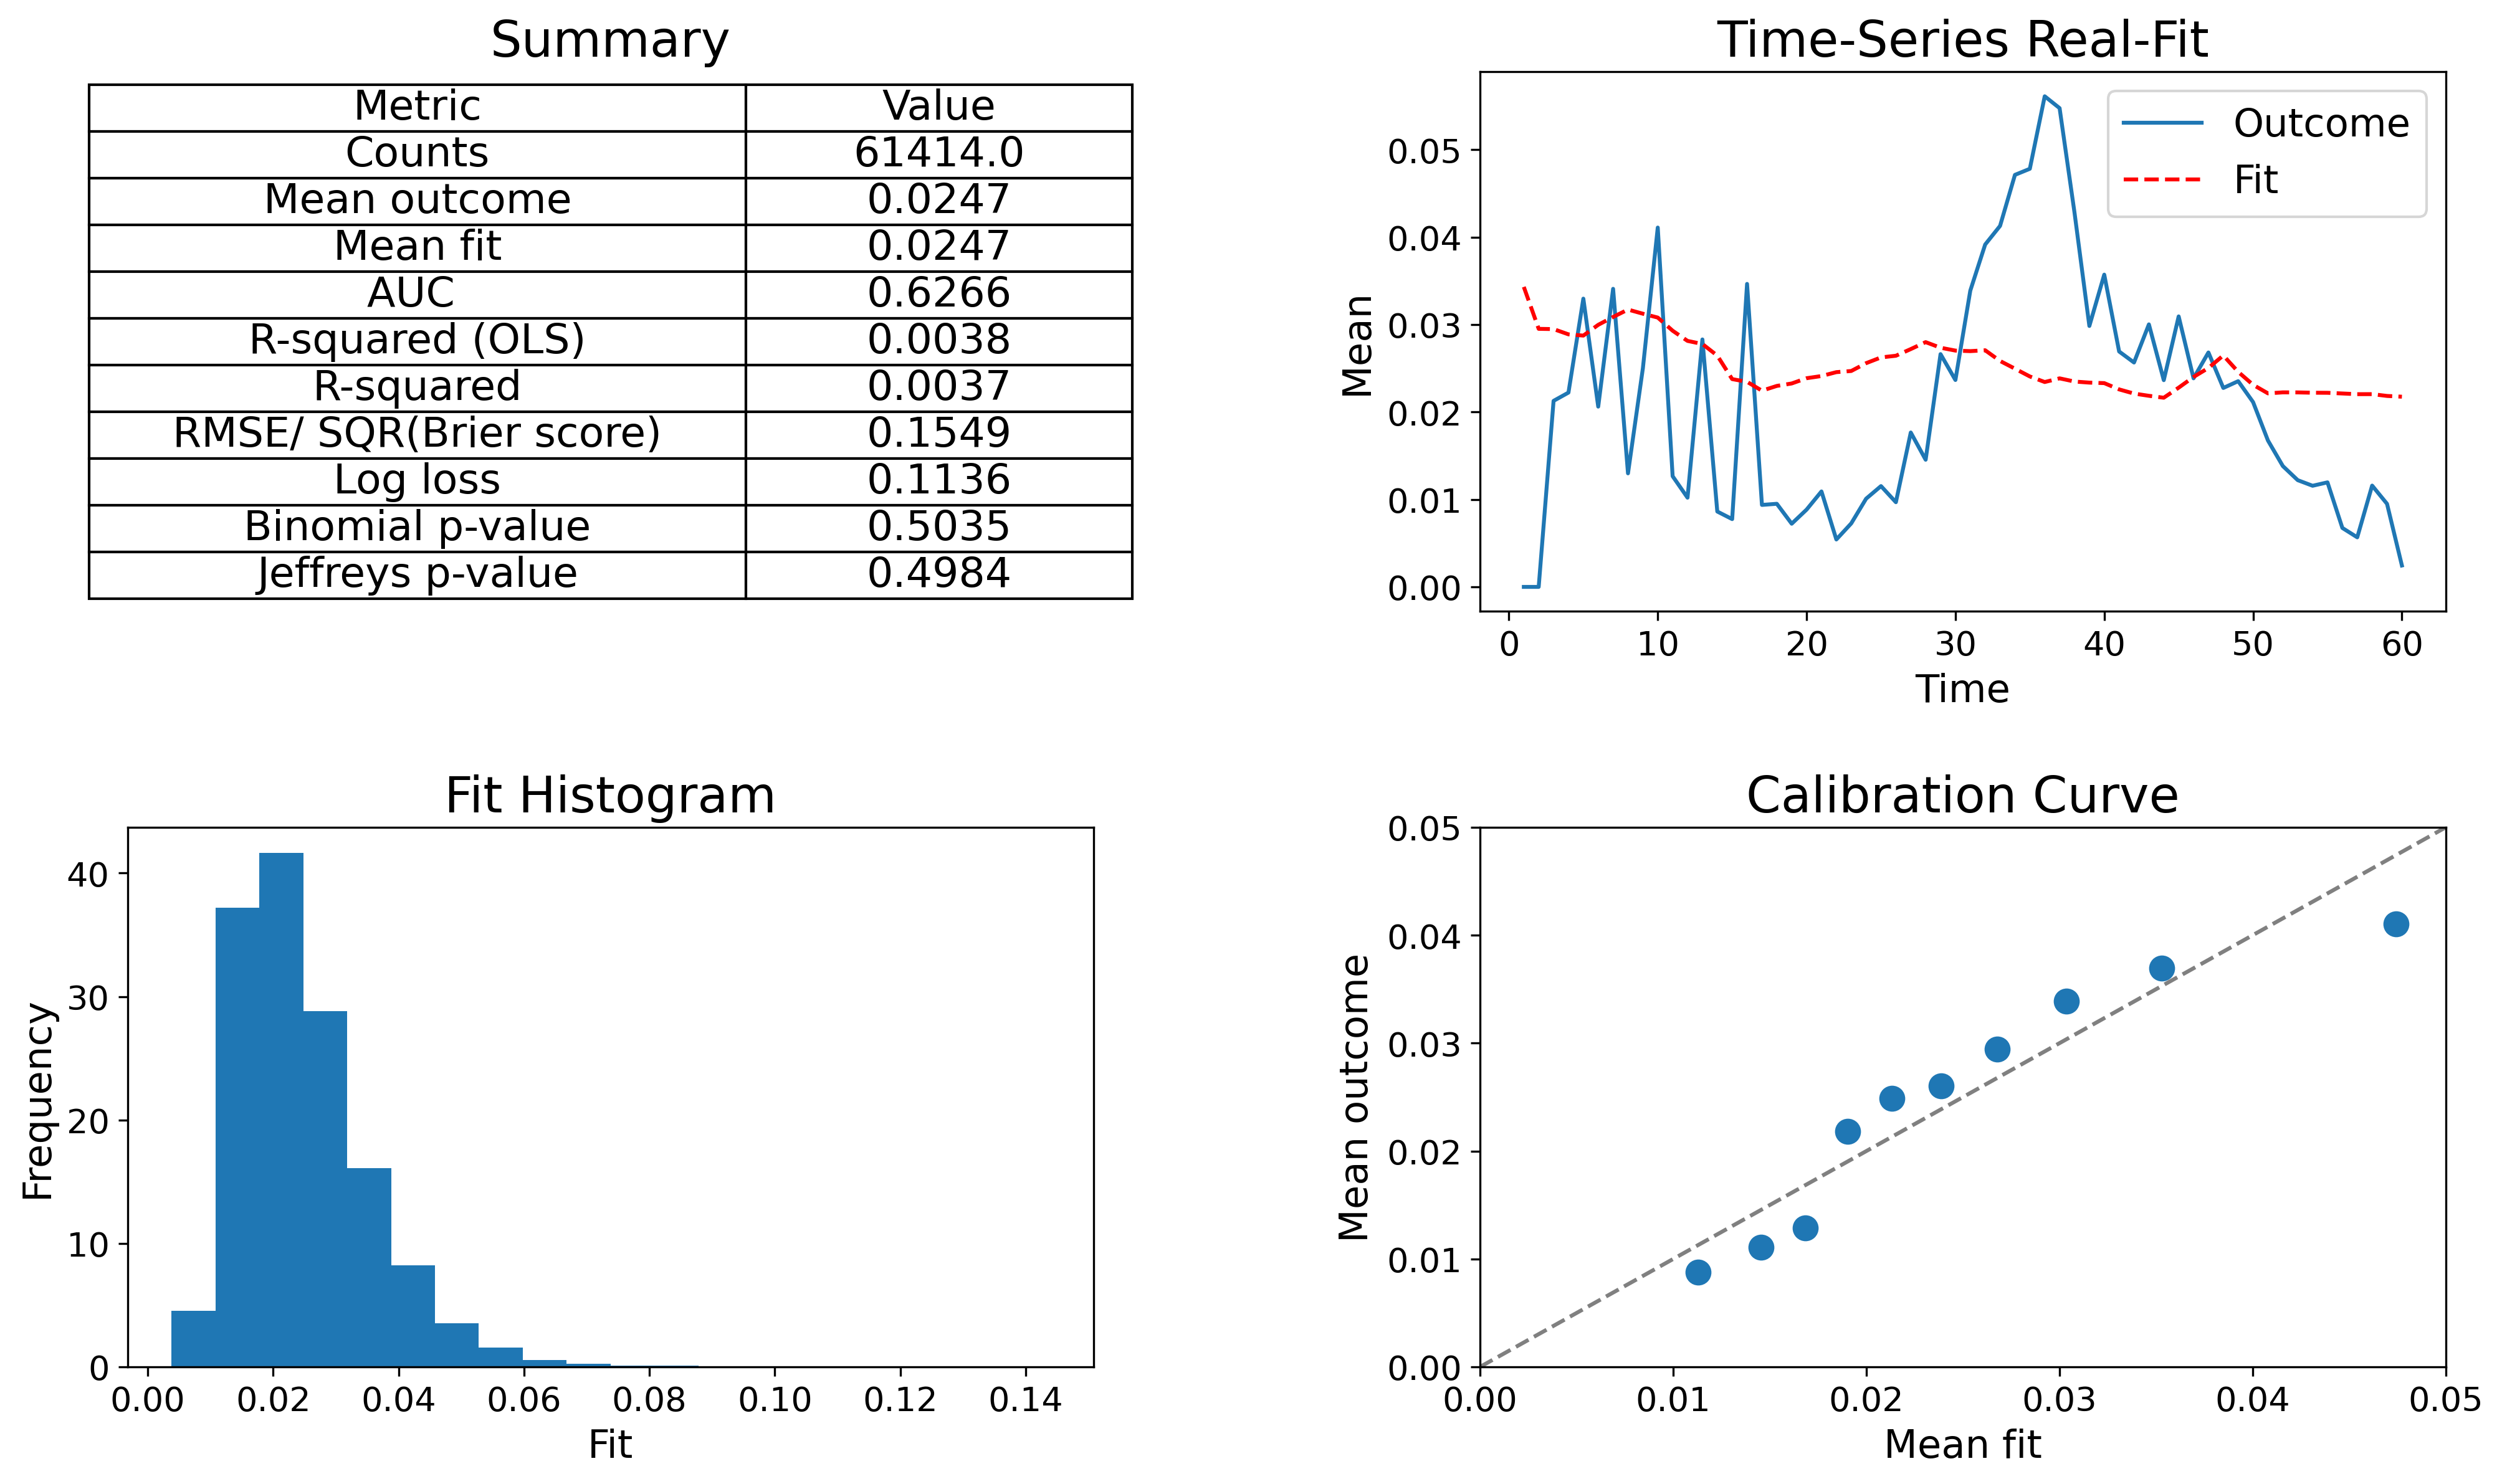

In [245]:
validation(data_stress_logit.Logit_result3, data_stress_logit.default_time, data_stress_logit.time)

In [246]:
average_pd_by_time3 = data_stress_logit.groupby('time')['Logit_result3'].mean()

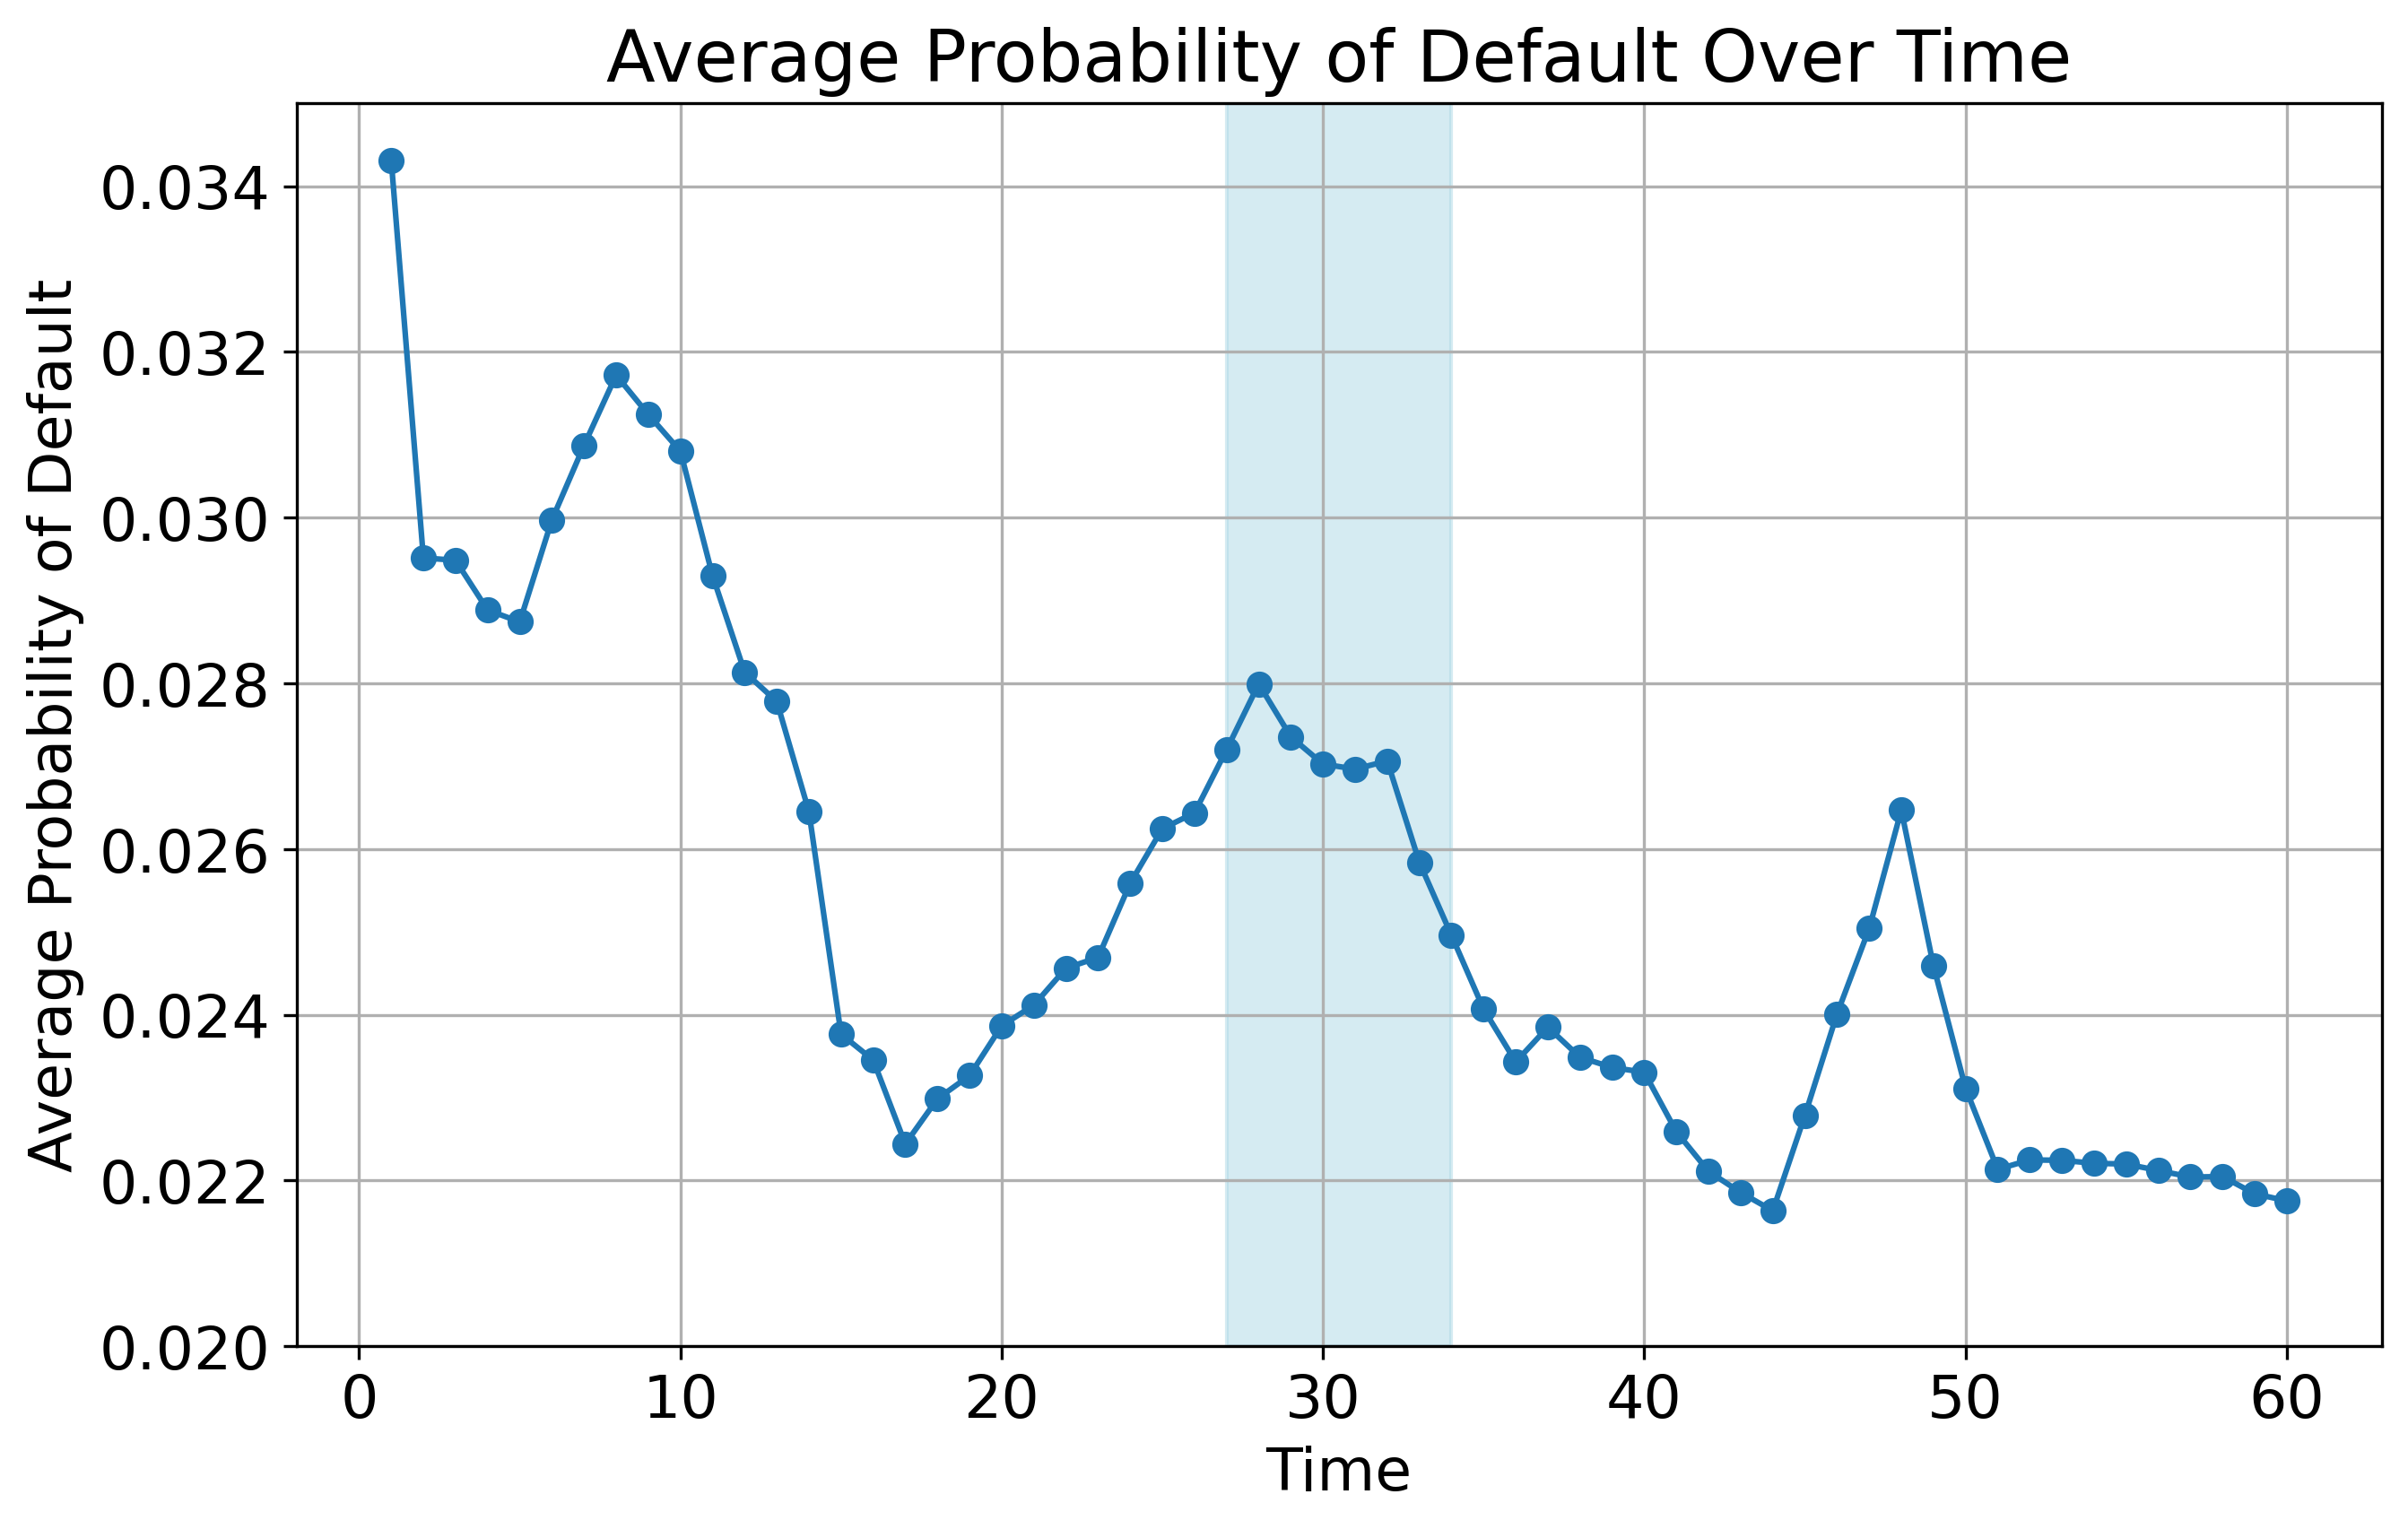

In [298]:
plt.figure(figsize=(10, 6))
plt.plot(average_pd_by_time3, marker='o', linestyle='-')
plt.ylim(0.020, 0.0350)
plt.axvspan(27, 34, color="lightblue", alpha=0.5)
plt.title('Average Probability of Default Over Time')
plt.xlabel('Time')
plt.ylabel('Average Probability of Default')
plt.grid(True)
plt.show()

In [307]:
# Define credit score bins
bins = [400,450,500,550,600,650,700,750,800,850]
merged_data_PD2['credit_score_bin'] = pd.cut(merged_data_PD2['FICO_orig_time_original'], bins=bins)
data_stress_logit['credit_score_bin'] = pd.cut(data_stress_logit['FICO_orig_time_original'], bins=bins)

# Calculate average PD for each bin before and after the adjustment
average_pd_before = merged_data_PD2.groupby('credit_score_bin')['Logit_result2'].mean()
average_pd_after = data_stress_logit.groupby('credit_score_bin')['Logit_result3'].mean()

pd_change = average_pd_after - average_pd_before

In [308]:
pd_change

credit_score_bin
(400, 450]   -0.000947
(450, 500]    0.000403
(500, 550]   -0.000005
(550, 600]   -0.000070
(600, 650]    0.000014
(650, 700]    0.000009
(700, 750]   -0.000001
(750, 800]   -0.000002
(800, 850]   -0.000042
dtype: float64

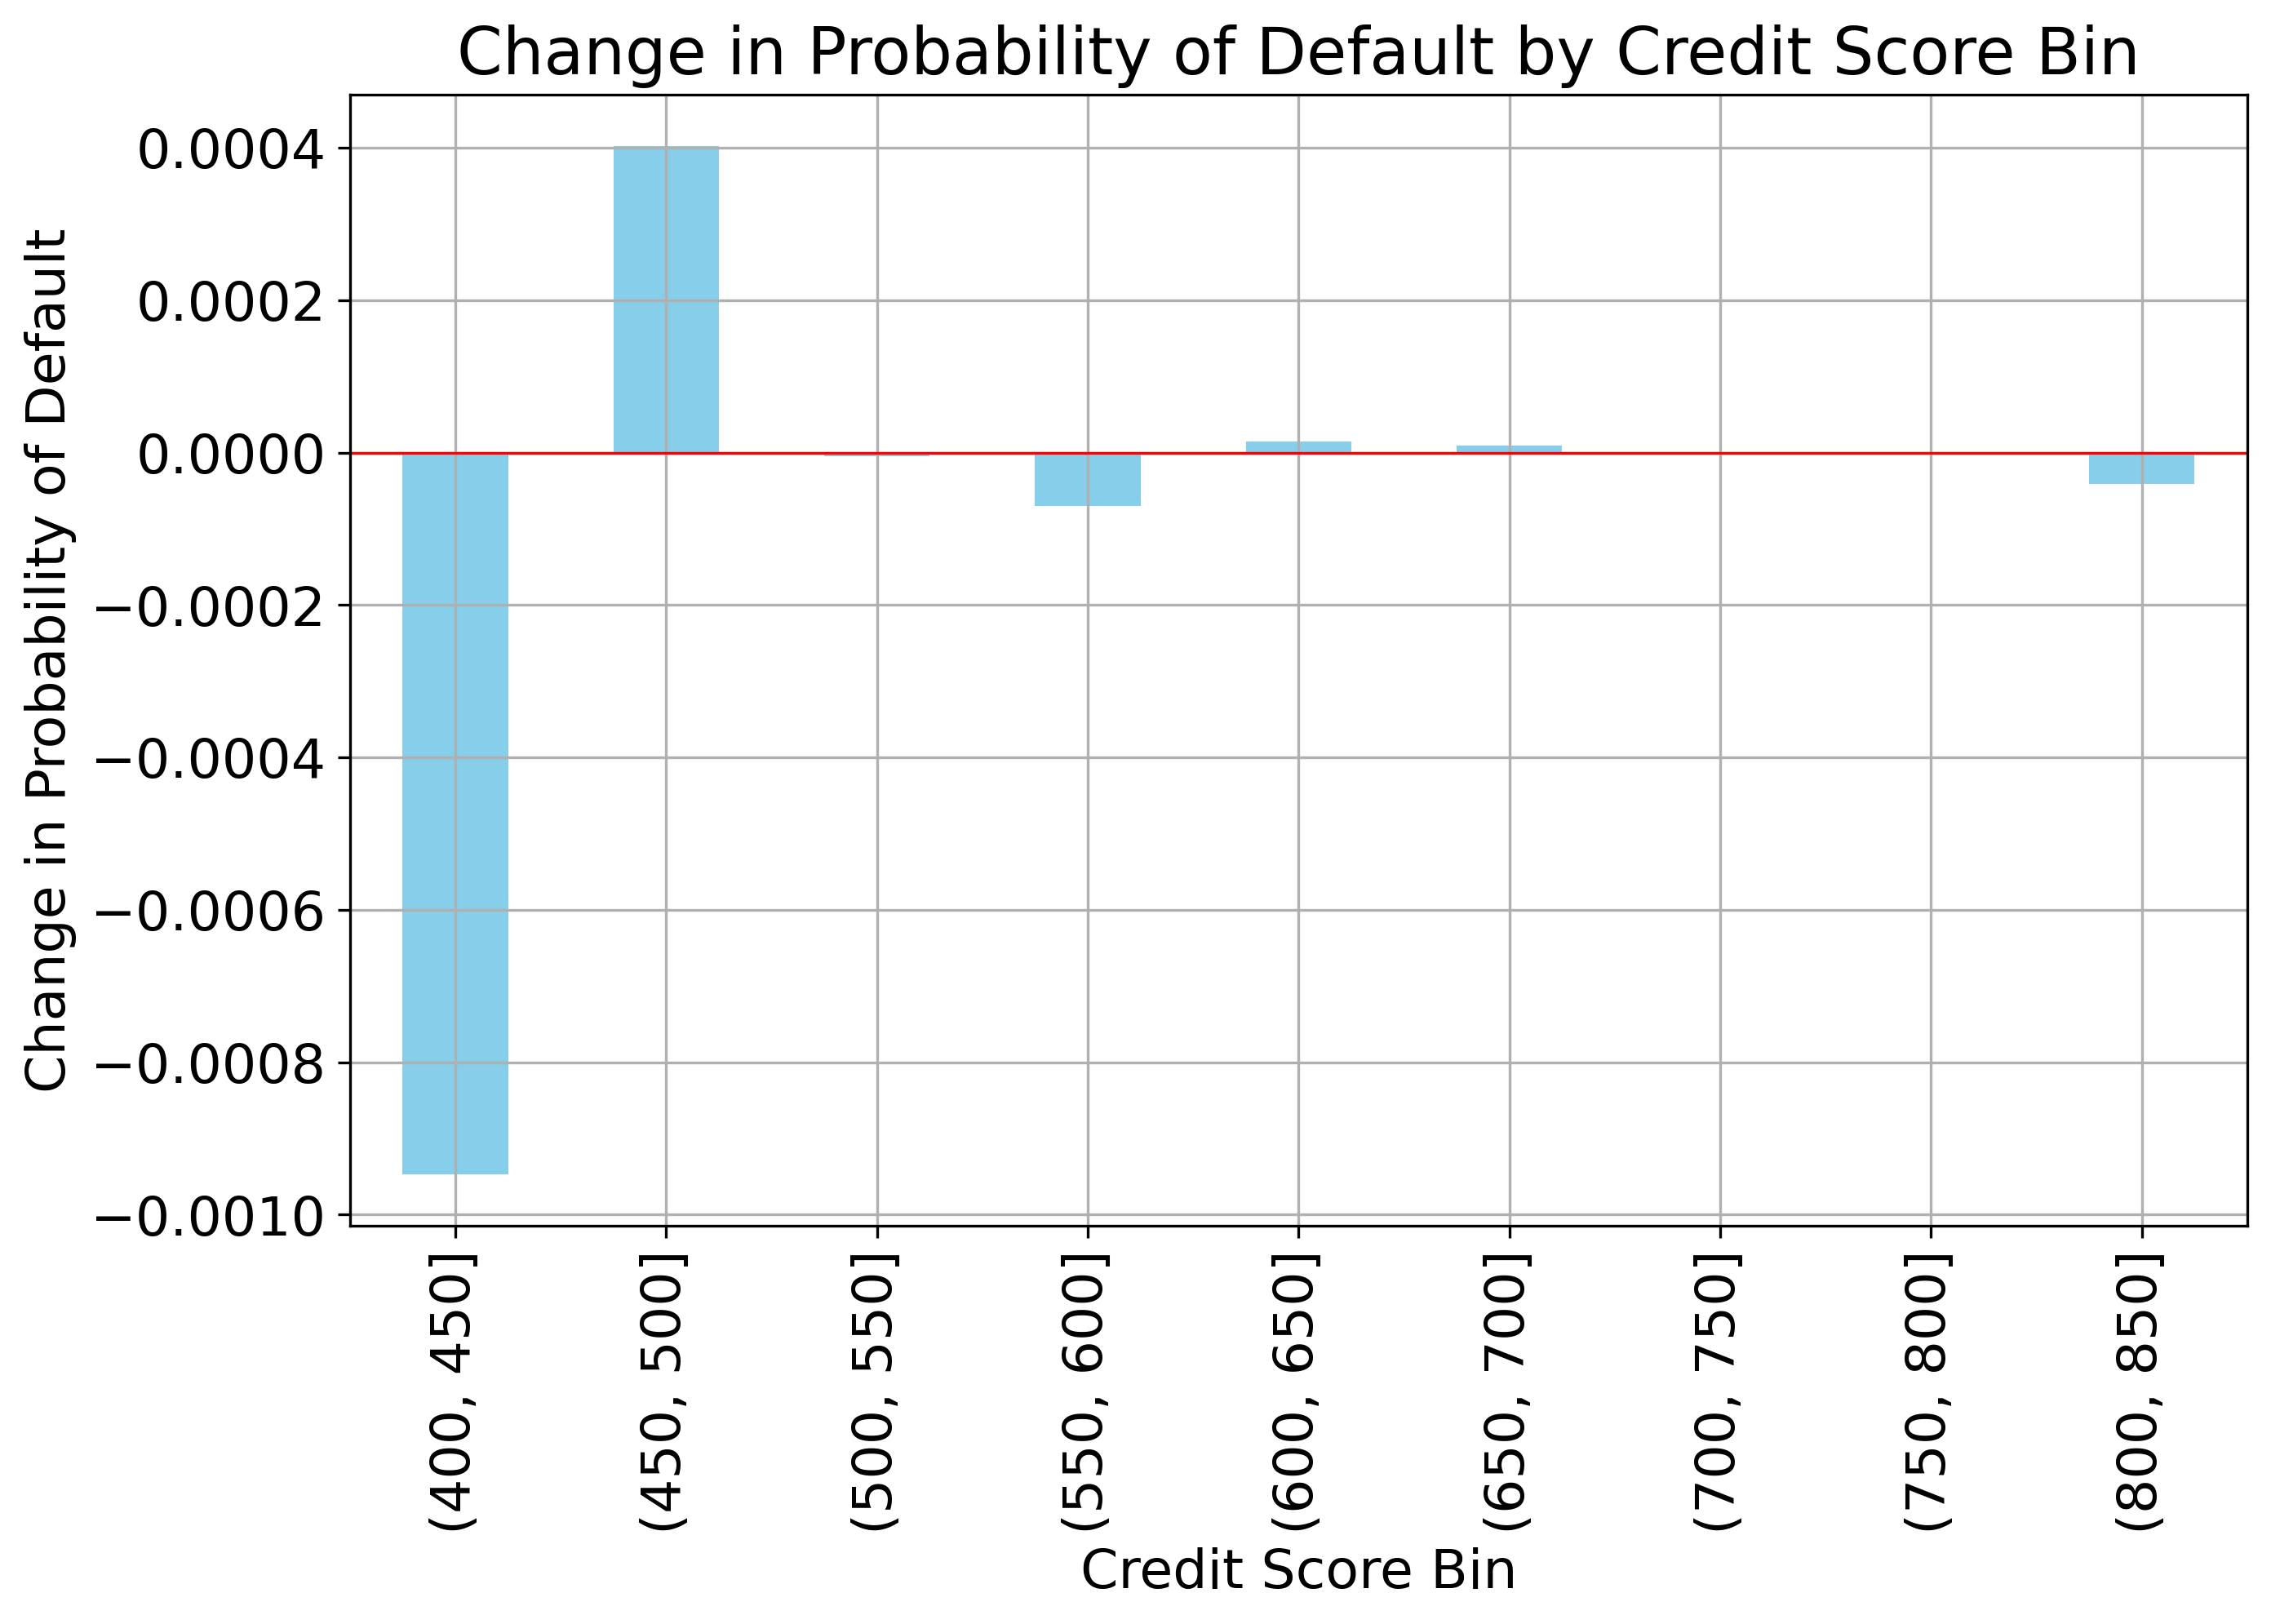

In [309]:
plt.figure(figsize=(10, 6))
pd_change.plot(kind='bar', color='skyblue')
plt.title('Change in Probability of Default by Credit Score Bin')
plt.xlabel('Credit Score Bin')
plt.ylabel('Change in Probability of Default')
plt.axhline(0, color='red', linewidth=0.8) 
plt.grid(True)
plt.show()

During times of economic prosperity, individuals with lower credit scores may see comparatively larger improvements in their creditworthiness or ability to manage loans, as opposed to those with higher credit scores who already have less room for improvement.
The substantial decrease in the probability of default for borrowers in the 400-450 score range indicates that these individuals benefit the most from favorable economic conditions. This could be due to several factors such as improved employment rates, higher disposable incomes, or better access to refinancing options.
The minimal changes observed in the higher credit score bins (600 and above) suggest that these borrowers already have a lower baseline default probability, and their financial situation may not improve as dramatically with economic growth.

Economic Insights:

- Credit Accessibility: Improved economic conditions often lead to easier credit access, particularly for those at the lower end of the credit spectrum, who might now qualify for loans previously out of reach.
- Risk Sensitivity: Lower credit score individuals are more sensitive to economic changes. In prosperity, they can significantly improve their financial stability, which is reflected in the probability of default.
- Leverage Effect: Economic growth might also increase the leverage or borrowing capacity of lower-score individuals more significantly, allowing them to consolidate debt, increase spending on capital improvements, or cover expenses that were previously unmanageable.

### B) The Double-trigger hypothesis

The Double-trigger hypothesis in credit risk, particularly in the context of mortgage defaults, posits that defaults are typically the result of two concurrent issues: a reduction in the borrower's ability to repay (income shock) and a situation where the value of the mortgage exceeds the value of the property (negative equity). This concept suggests that neither factor alone is usually sufficient to cause a default, but together they substantially increase the likelihood.

Macroeconomic Factors Corresponding to the Triggers:

- **Unemployment Rate (Reduction in Ability to Repay)**

  The unemployment rate is a critical macroeconomic indicator that directly impacts a borrower's ability to generate         income. An increase in unemployment can lead to income shocks for households as individuals lose their jobs or find       their hours reduced. Without a steady income, the ability of borrowers to meet their mortgage obligations diminishes,     significantly increasing the risk of default. This factor directly correlates with the first trigger of the double-       trigger hypothesis, where a borrower’s capacity to repay their debt is compromised.

- **House Price Index (Negative Equity)**

  The House Price Index (HPI) measures the price changes of residential housing. A decline in home prices can lead to       negative equity, which occurs when the market value of a property falls below the balance of the mortgage owed on it.     This situation can be exacerbated in a declining economy or a bursting real estate bubble. Negative equity discourages     continued investment in the property (as the asset is worth less than its debt), and if paired with an income shock,       makes strategic default (choosing to default despite having the means to pay) more likely. This aligns with the second     trigger in the double-trigger hypothesis, where the economic rationality of continuing to repay a mortgage is undermined   by the reduced value of the collateral securing the loan.
  
The interplay between these two factors underscores the vulnerability of the housing market to broader economic downturns. For instance, a recession that leads to both job losses (increasing unemployment rates) and declining property values can thus dramatically increase default rates.

This concludes this assignment :)